In [7]:
import numpy as np
import json
import os
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import butter, filtfilt
from scipy import integrate
from scipy.signal import sosfilt, iirfilter, zpk2sos

## High pass filter

In [136]:
def highpass(data, freq, df, corners=4, zerophase=False):
    fe = 0.5 * df
    f = freq / fe
    
    z, p, k = iirfilter(corners, f, btype='highpass', ftype='butter', output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)

## Low pass filter

In [137]:
def lowpass(data, freq, df, corners=4, zerophase=False):
    fe = 0.5 * df
    f = freq / fe
    
    z, p, k = iirfilter(corners, f, btype='lowpass', ftype='butter', output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)

## 微分: 速度 -> 加速度

In [141]:
# 速度微分 -> 加速度
# 100.0: sampling_rate
def v_to_a(z, n, e, sample_rate):
    d_z = np.gradient(z, 1.0/sample_rate)
    d_n = np.gradient(n, 1.0/sample_rate)
    d_e = np.gradient(e, 1.0/sample_rate)

    return d_z, d_n, d_e

## 積分: 加速度 -> 速度

In [142]:
# 加速度積分 -> 速度
# 100.0: sampling_rate
def a_to_v(z, n, e, sample_rate):
    i_z = integrate.cumtrapz(z)/sample_rate
    i_n = integrate.cumtrapz(n)/sample_rate
    i_e = integrate.cumtrapz(e)/sample_rate
    
    return i_z, i_n, i_e

## 計算 PGA

In [165]:
def calc_pga(z, n, e, waveType, sample_rate):
    # 檢查波形是 速度 or 加速度
    if waveType == 'Velocity':
        z, n, e = v_to_a(z, n, e, sample_rate)
        
    # 10Hz low pass filter
    z = lowpass(z, 10, sample_rate)
    n = lowpass(n, 10, sample_rate)
    e = lowpass(e, 10, sample_rate)
    
    # 合成震波
    acc = np.sqrt(z**2+n**2+e**2)
    
    # Max=PGA
    pga = max(acc)
    pga_z = max(z)
    pga_n = max(n)
    pga_e = max(e)
    
    return pga, pga_z, pga_n, pga_e

## 用 PGA 計算震度 (震度四級以下)

In [144]:
def pga_to_intensity(pga):
    if pga < 0.8:
        return 0
    elif pga >= 0.8 and pga < 2.5:
        return 1
    elif pga >= 2.5 and pga < 8.0:
        return 2
    elif pga >= 8.0 and pga < 25.0:
        return 3
    elif pga >= 25.0 and pga < 80.0:
        return 4
    else:
        return 5

## 計算 PGV

In [166]:
def calc_pgv(z, n, e, waveType, sample_rate):
    # 檢查波形是 速度 or 加速度
    if waveType == 'Acceleration':
        z, n, e = a_to_v(z, n, e, sample_rate)
 
    # 0.075Hz high pass filter
    z = highpass(z, 0.075, sample_rate)
    n = highpass(n, 0.075, sample_rate)
    e = highpass(e, 0.075, sample_rate)
        
    # 合成震波
    acc = np.sqrt(z**2+n**2+e**2)
    
    # Max=PGV
    pgv = max(acc)
    pgv_z = max(z)
    pgv_n = max(n)
    pgv_e = max(e)
    
    return pgv, pgv_z, pgv_n, pgv_e

## 用 PGV 計算震度(震度五級以上)

In [146]:
def pgv_to_intensity(pgv):
    if pgv >= 15 and pgv < 30:
        return "5 weak"
    elif pgv >= 30 and pgv < 50:
        return "5 strong"
    elif pgv >= 50 and pgv < 80:
        return "6 weak"
    elif pgv >= 80 and pgv < 140:
        return "6 strong"
    elif pgv >= 140:
        return '7'
    else:
        return '4'

## 計算震度

In [181]:
def calc_intensity(z, n, e, waveType, sample_rate):
    # 先計算 PGA 檢查震度是否 > 5
    pga, pga_z, pga_n, pga_e = calc_pga(z, n, e, waveType, sample_rate)
    print(f"pgaZ:{pga_z}, pgaN:{pga_n}, pgaE: {pga_e}")
    
    # 依照 pga 推測震度
    intensity = pga_to_intensity(pga)
    
    pgv, pgv_z, pgv_n, pgv_e = calc_pgv(z, n, e, waveType, sample_rate)
    print(f"pgvZ:{pgv_z}, pgvN:{pgv_n}, pgvE: {pgv_e}")
    
    # 震度五級以上，則用 PGV 決定震度
    if intensity == 5:    
        # 依照 pgv 推測震度
        intensity = pgv_to_intensity(pgv)
    
    intensity = str(intensity)
    return intensity, pga, pgv

## 修改數據

In [182]:
def modify(p):
    for k in p.keys():
        try:
            # 看測站內有多少組波形資料
            n_data = p[k]['numberOfData']
            
            for w in range(n_data):
                # get Z, N, E, convert to ndarray
                z, n, e = p[k][str(w)]['Z'], p[k][str(w)]['N'], p[k][str(w)]['E']
                z, n, e = np.array(z), np.array(n), np.array(e)
                
                # multiply z, n, e by factor
                z, n, e = z*p[k][str(w)]['factor'][0], n*p[k][str(w)]['factor'][1], e*p[k][str(w)]['factor'][2]
                
                # get the type of waveform: velocity or acceleration
                waveType = p[k][str(w)]['datatype']
                
                # get the sampling rate
                sampleRate = p[k][str(w)]['sampling_rate']
                
                intensity, pga, pgv = calc_intensity(z, n, e, waveType, sampleRate)
                
                p[k][str(w)]['intensity'] = intensity
                p[k][str(w)]['pga'], p[k][str(w)][pgv] = pga, pgv
                p[k][str(w)]['DataAvailable']['intensity'] = True
                p[k][str(w)]['DataAvailable']['pga'] = True
                p[k][str(w)]['DataAvailable']['pgv'] = True
                
                print(f"station: {k}, distance: {p[k]['distance']}, intensity: {intensity}, pga: {pga}, pgv: {pgv},  waveType: {waveType}")
                if p[k][str(w)]['DataAvailable']['intensity']:
                    print(f"original intensity: {p[k][str(w)]['intensity']}")
                if p[k][str(w)]['DataAvailable']['pga']:
                    print(f"original pga: {p[k][str(w)]['pga']}")
                if p[k][str(w)]['DataAvailable']['pgv']:
                    print(f"original pgv: {p[k][str(w)]['pgv']}")
                
                draw(z, n, e)
        except Exception as e:
            #print(k, e)
            pass
    
    return p

In [158]:
def draw(z, n, e):
    #plt.figure(figsize=(15, 10))
    plt.subplot(311)
    plt.plot(z)
    
    plt.subplot(312)
    plt.plot(n)
    
    plt.subplot(313)
    plt.plot(e)
    plt.show()

## 指定路徑後，更改 json 裡面的數據

In [2]:
year = '2012'
root = "/mnt/nas6/CWBDatasets/"
files = os.listdir(root)

5.75 2020-12-10 18:15:08.560000 24.53 121.97
pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: ESA, distance: 14.0, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 3
original pga: 13.0
original pgv: 0.3


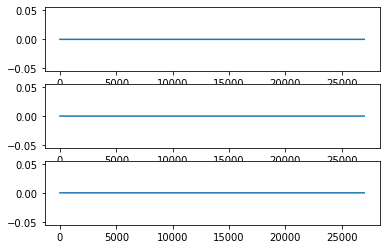

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: ESA, distance: 14.0, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Acceleration
original intensity: 3
original pga: 13.0
original pgv: 0.3


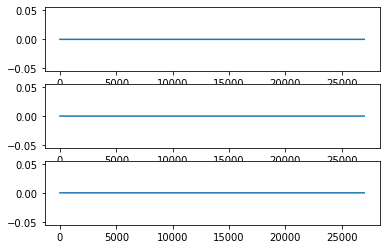

pgaZ:14.25492500897512, pgaN:6.780891960894165, pgaE: 9.567378038181088
pgvZ:3.459708765878673, pgvN:0.30465906447839375, pgvE: 0.25306849253308705
station: ESA, distance: 14.0, intensity: 3, pga: 15.656428317078673, pgv: 3.480702586112554,  waveType: Acceleration
original intensity: 3
original pga: 13.0
original pgv: 0.3


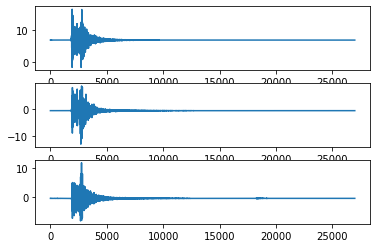

pgaZ:5.186072992728235, pgaN:7.592616391450418, pgaE: 5.752595687683524
pgvZ:0.10781930260402273, pgvN:0.33908988044031224, pgvE: 0.1542819954187901
station: TWC, distance: 14.5, intensity: 3, pga: 8.778181930936565, pgv: 0.3701384125146179,  waveType: Velocity
original intensity: 3
original pga: 8.2
original pgv: 0.3


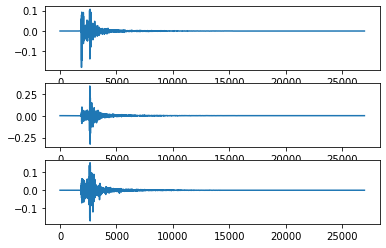

pgaZ:5.62663915227966, pgaN:6.484949600606338, pgaE: 6.597049278447848
pgvZ:0.3040704695723043, pgvN:0.23146978715696395, pgvE: 0.33147842323565596
station: TWC, distance: 14.5, intensity: 3, pga: 8.642451096404924, pgv: 0.47739448476096324,  waveType: Acceleration
original intensity: 3
original pga: 8.2
original pgv: 0.3


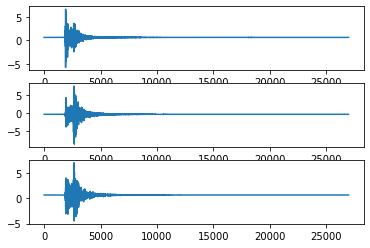

pgaZ:195.2872657585871, pgaN:-0.25554097156319294, pgaE: 15.129127394643097
pgvZ:88.85597063076307, pgvN:25.32584389711284, pgvE: 6.612928132377928
station: EWT, distance: 21.7, intensity: 6 strong, pga: 204.6024546458207, pgv: 93.09435892110375,  waveType: Acceleration


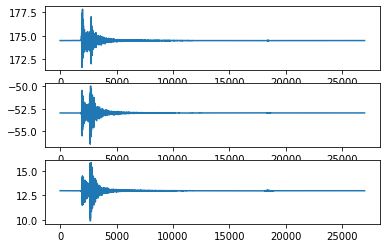

pgaZ:1.872173928997664, pgaN:2.543339440438758, pgaE: 2.061538207065665
pgvZ:0.10741058564713413, pgvN:0.1036297959142316, pgvE: 0.1292805943670124
station: EWT, distance: 21.7, intensity: 2, pga: 3.456381900460389, pgv: 0.16219183203475615,  waveType: Velocity


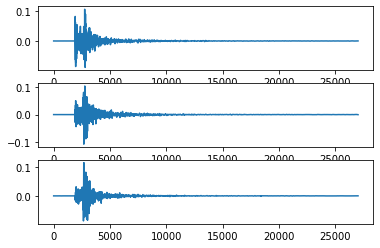

pgaZ:4.279547402562593, pgaN:16.799477706735065, pgaE: 19.459286448987086
pgvZ:2.9557437669300066, pgvN:2.8954192683183075, pgvE: 1.5282104529264038
station: EWT, distance: 21.7, intensity: 4, pga: 26.030452188932514, pgv: 4.767489144642202,  waveType: Acceleration


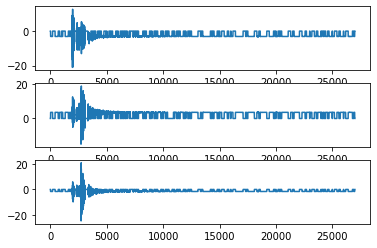

pgaZ:9.62948228194129, pgaN:42.1092443989881, pgaE: 23.393425381188536
pgvZ:0.2715742314692554, pgvN:0.9727823954009654, pgvE: 1.6669811598900186
station: ENA, distance: 25.3, intensity: 4, pga: 42.5364532497353, pgv: 1.8935204979319251,  waveType: Acceleration
original intensity: 4
original pga: 40.9
original pgv: 1.1


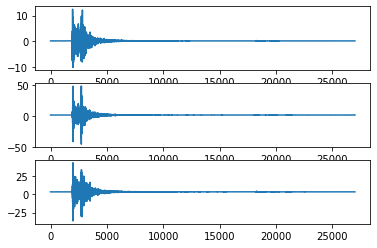

pgaZ:9.070589268167497, pgaN:38.291555719899065, pgaE: 20.14345583317463
pgvZ:0.2782087334594111, pgvN:0.9896275870903718, pgvE: 0.7234885687652719
station: ENA, distance: 25.3, intensity: 4, pga: 38.72137605816367, pgv: 1.0752551491140145,  waveType: Velocity
original intensity: 4
original pga: 40.9
original pgv: 1.1


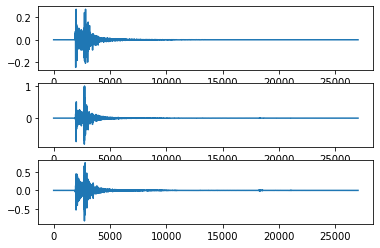

pgaZ:1.4819435763845157, pgaN:1.6230910854193896, pgaE: 1.8421089977087581
pgvZ:0.057002483788831416, pgvN:0.0799337410155271, pgvE: 0.0756908754050649
station: NDS, distance: 28.5, intensity: 2, pga: 2.5199943890093137, pgv: 0.12795973565744523,  waveType: Velocity
original intensity: 3
original pga: 17.1
original pgv: 0.9


pgaZ:295.2079666414734, pgaN:-0.13397741830834028, pgaE: -0.15101649133389905
pgvZ:134.32084663631593, pgvN:13.277414461884767, pgvE: 14.966022076076328
station: NDS, distance: 28.5, intensity: 6 strong, pga: 298.89881493953374, pgv: 136.0002153872613,  waveType: Acceleration
original intensity: 3
original pga: 17.1
original pgv: 0.9


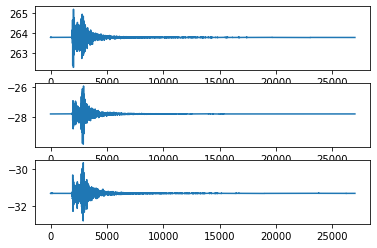

pgaZ:6.6722816899318, pgaN:9.177588162955741, pgaE: 7.457593235361041
pgvZ:1.506887026986354, pgvN:1.975548999936406, pgvE: 1.956288849220841
station: NDS, distance: 28.5, intensity: 3, pga: 9.751641610044523, pgv: 3.1435973878041845,  waveType: Acceleration
original intensity: 3
original pga: 17.1
original pgv: 0.9


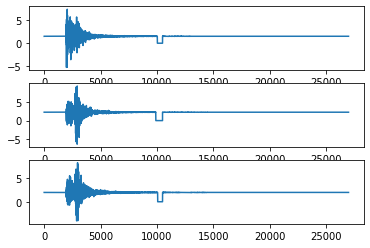

pgaZ:2.1221462589604987, pgaN:1.9947058781428124, pgaE: 1.3793922814559332
pgvZ:0.07218263595281332, pgvN:0.08274442511039005, pgvE: 0.10371297164548537
station: EAH, distance: 32.3, intensity: 1, pga: 2.3611194313861525, pgv: 0.10745477892085112,  waveType: Velocity
original intensity: 3
original pga: 23.8
original pgv: 0.7


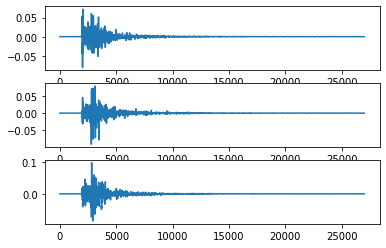

pgaZ:30.83341842885592, pgaN:-0.4050839841605605, pgaE: -0.7905396313312687
pgvZ:14.029156192424162, pgvN:40.14729889421389, pgvE: 78.3460423282429
station: EAH, distance: 32.3, intensity: 6 strong, pga: 208.34396216695137, pgv: 94.79745768704385,  waveType: Acceleration
original intensity: 3
original pga: 23.8
original pgv: 0.7


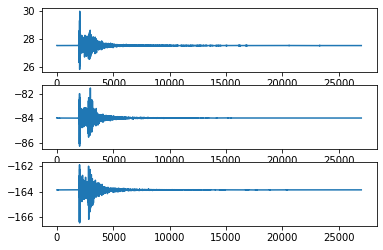

pgaZ:3.2524516191040287, pgaN:1.3163901824522344, pgaE: 7.565697051431781
pgvZ:1.850874856803431, pgvN:3.294811915451378, pgvE: 0.341781514714234
station: EAH, distance: 32.3, intensity: 3, pga: 16.770342701804594, pgv: 4.039589384780721,  waveType: Acceleration
original intensity: 3
original pga: 23.8
original pgv: 0.7


pgaZ:14.066596975750922, pgaN:14.685031869579552, pgaE: 10.464012269198994
pgvZ:2.1385277013781985, pgvN:2.37556643437363, pgvE: 0.5772247887499957
station: EHP, distance: 33.3, intensity: 3, pga: 23.727910645610812, pgv: 3.344490509253819,  waveType: Acceleration
original intensity: 3
original pga: 18.8
original pgv: 0.7


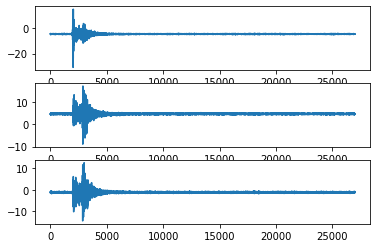

pgaZ:6.32919256475909, pgaN:10.1038621565491, pgaE: 2.869760421364012
pgvZ:0.6266101788764201, pgvN:0.5981985067521721, pgvE: 2.352526805765769
station: ILA, distance: 34.1, intensity: 3, pga: 13.220429576193007, pgv: 2.593388791866695,  waveType: Acceleration
original intensity: 3
original pga: 11.3
original pgv: 0.7


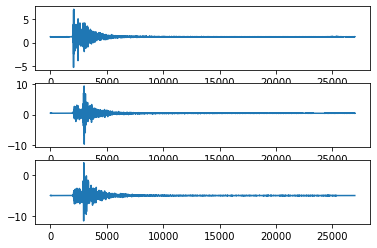

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: ILA, distance: 34.1, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 3
original pga: 11.3
original pgv: 0.7


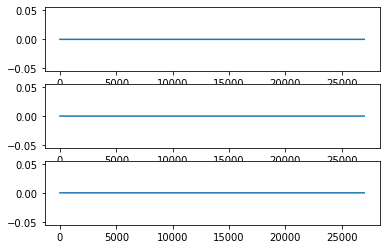

pgaZ:3.563399117177272, pgaN:1.516213279328646, pgaE: 2.400225300126513
pgvZ:0.09340544979502322, pgvN:0.12471444945155377, pgvE: 0.1368125243250371
station: ILA, distance: 34.1, intensity: 2, pga: 3.5756994067273324, pgv: 0.19246656883673577,  waveType: Velocity
original intensity: 3
original pga: 11.3
original pgv: 0.7


pgaZ:0.5570439360932924, pgaN:1.8676826131806525, pgaE: -0.1332077618664237
pgvZ:1.4815669648236423, pgvN:0.20152926754710157, pgvE: 13.199983778994866
station: ILA, distance: 34.1, intensity: 4, pga: 31.095127063731788, pgv: 14.147736096005788,  waveType: Acceleration
original intensity: 3
original pga: 11.3
original pgv: 0.7


pgaZ:3.939674330975873, pgaN:4.615269666720977, pgaE: 6.189038869322444
pgvZ:0.12126828012901487, pgvN:0.18882585582447098, pgvE: 0.31450150143156014
station: TWE, distance: 36.1, intensity: 2, pga: 7.0880992412160415, pgv: 0.32463166592324655,  waveType: Velocity
original intensity: 2
original pga: 6.7
original pgv: 0.4


pgaZ:-0.021583544501939503, pgaN:8.1689744721083, pgaE: 9.716991850820897
pgvZ:2.1394670694939375, pgvN:1.8567618317378916, pgvE: 1.7547835251992863
station: TWE, distance: 36.1, intensity: 3, pga: 11.61099916334015, pgv: 3.423103950638953,  waveType: Acceleration
original intensity: 2
original pga: 6.7
original pgv: 0.4


pgaZ:0.022839817648034298, pgaN:0.03867877626557467, pgaE: 0.047473865574025984
pgvZ:0.0009724924674065512, pgvN:0.0025146308895959836, pgvE: 0.0024355916242912033
station: LATB, distance: 45.3, intensity: 0, pga: 0.05718831393045632, pgv: 0.0029181950305871168,  waveType: Velocity


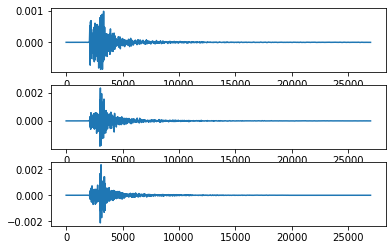

pgaZ:0.013846720165191624, pgaN:0.02154959249975514, pgaE: 0.024092398533384678
pgvZ:0.000940884765586494, pgvN:0.001489903406896781, pgvE: 0.0016903930784480361
station: FUSB, distance: 46.7, intensity: 0, pga: 0.03649507277155359, pgv: 0.00198334553502932,  waveType: Velocity


pgaZ:8.788729052287426, pgaN:3.395347267000446, pgaE: 5.635349388200076
pgvZ:3.312366398582632, pgvN:0.1494238574805092, pgvE: 0.3002355979738688
station: NDT, distance: 47.4, intensity: 3, pga: 9.855196107463435, pgv: 3.3169554232759144,  waveType: Acceleration
original intensity: 2
original pga: 7.3
original pgv: 0.3


pgaZ:0.5764320755794176, pgaN:1.3677310419962472, pgaE: 1.5556079803654832
pgvZ:0.029344145602215984, pgvN:0.08084975152668838, pgvE: 0.09934236452799212
station: TIPB, distance: 51.3, intensity: 1, pga: 2.4170664529528554, pgv: 0.10572011496124692,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


pgaZ:0.5726282624274793, pgaN:1.3393703976860598, pgaE: 1.5249326034727633
pgvZ:0.02930945569664224, pgvN:0.07856317780892413, pgvE: 0.09684078661102108
station: TIPB, distance: 51.3, intensity: 1, pga: 2.366101151158319, pgv: 0.10184734224190721,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


pgaZ:0.36733328889569783, pgaN:0.609654729315295, pgaE: 0.6818345488610178
pgvZ:0.013209724899870962, pgvN:0.023033795457363858, pgvE: 0.03403707645938556
station: TWB1, distance: 53.0, intensity: 1, pga: 0.803142466281292, pgv: 0.03626821770615499,  waveType: Velocity
original intensity: 1
original pga: 0.9
original pgv: 0.1


pgaZ:0.44044745261322266, pgaN:2.649099311535441, pgaE: 1.5994350183988117
pgvZ:0.014346620256719, pgvN:1.0213081460929236, pgvE: 0.46231067692175487
station: TWB1, distance: 53.0, intensity: 2, pga: 2.824987477090199, pgv: 1.1211629761129176,  waveType: Acceleration
original intensity: 1
original pga: 0.9
original pgv: 0.1


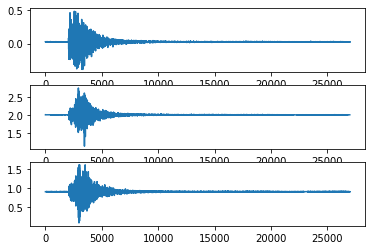

pgaZ:-0.004366175469033918, pgaN:-0.026987786812249986, pgaE: 5.571201820623332
pgvZ:0.43252666196672007, pgvN:2.675636238546784, pgvE: 2.4852478743902378
station: TWB1, distance: 53.0, intensity: 3, pga: 8.371387151287559, pgv: 3.809169972484206,  waveType: Acceleration
original intensity: 1
original pga: 0.9
original pgv: 0.1


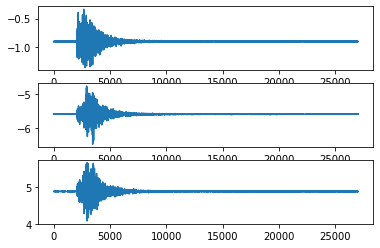

pgaZ:0.4060301527086351, pgaN:0.6332120985856801, pgaE: 0.6798022573012377
pgvZ:0.01281578977215738, pgvN:0.02248100733142284, pgvE: 0.04637716390785521
station: TWB1, distance: 53.0, intensity: 0, pga: 0.7852687418604277, pgv: 0.05106108878855797,  waveType: Velocity
original intensity: 1
original pga: 0.9
original pgv: 0.1


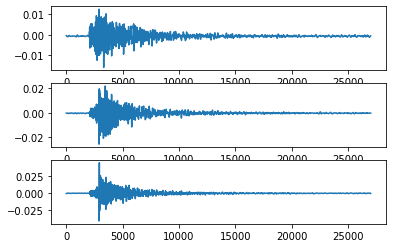

pgaZ:9.104205022696615, pgaN:11.649371791619792, pgaE: 12.585478646500887
pgvZ:3.6095597552328726, pgvN:0.36409069847670583, pgvE: 2.6473257820497818
station: ETL, distance: 54.1, intensity: 3, pga: 17.75184032595496, pgv: 4.49312435088183,  waveType: Acceleration
original intensity: 3
original pga: 12.6
original pgv: 0.4


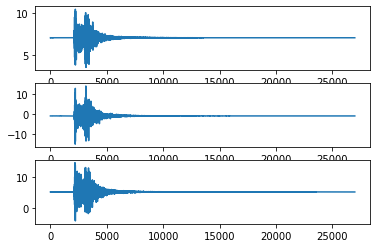

pgaZ:1.9140279776711988, pgaN:1.8263427548717894, pgaE: 1.5162179893608707
pgvZ:0.04979029547772778, pgvN:0.07543608508150527, pgvE: 0.09665450111002283
station: NACB, distance: 54.8, intensity: 1, pga: 2.213104158256397, pgv: 0.1082772768336268,  waveType: Velocity


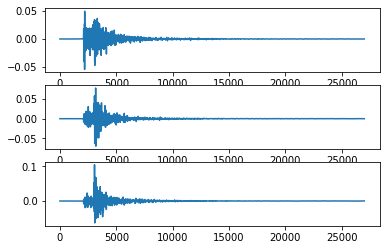

pgaZ:1.4249990613184704, pgaN:3.799054931003996, pgaE: 1.9191500264298935
pgvZ:0.10787448720696013, pgvN:0.23501610531794478, pgvE: 0.1436743872450953
station: NWL, distance: 55.1, intensity: 2, pga: 4.236019113335718, pgv: 0.27823648471985407,  waveType: Velocity
original intensity: 3
original pga: 22.0
original pgv: 1.1


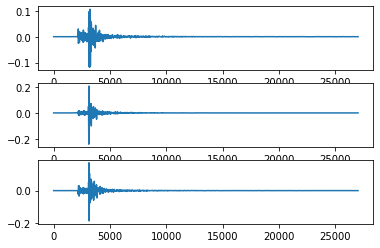

pgaZ:0.019543693405949115, pgaN:-0.25366799068997264, pgaE: -0.8160313397705281
pgvZ:0.6888557565681723, pgvN:25.13929606239771, pgvE: 80.87218223781423
station: NWL, distance: 55.1, intensity: 6 strong, pga: 198.22883197844587, pgv: 90.19526336587208,  waveType: Acceleration
original intensity: 3
original pga: 22.0
original pgv: 1.1


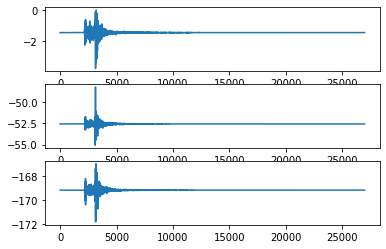

pgaZ:3.995759866088265, pgaN:3.9803079496269085, pgaE: 9.214466409406192
pgvZ:0.7336183783714392, pgvN:0.7256066979553146, pgvE: 0.27623402079544734
station: NWL, distance: 55.1, intensity: 3, pga: 10.357008374766421, pgv: 1.3731287251335538,  waveType: Acceleration
original intensity: 3
original pga: 22.0
original pgv: 1.1


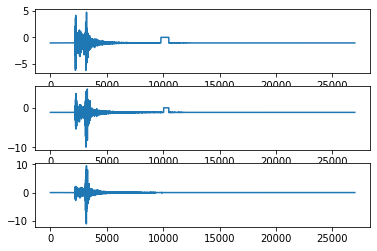

pgaZ:2.569725183473989, pgaN:7.57833794690851, pgaE: 6.950076544764746
pgvZ:0.10637111252991971, pgvN:0.4024257402095686, pgvE: 0.39854019509356836
station: NNS, distance: 60.8, intensity: 3, pga: 9.917109649519656, pgv: 0.4741633393091909,  waveType: Velocity
original intensity: 3
original pga: 9.8
original pgv: 0.4


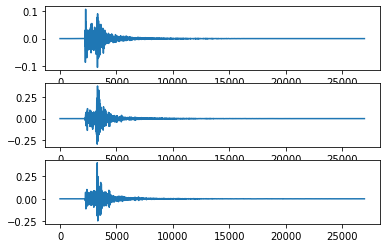

pgaZ:-0.02200135839871126, pgaN:7.490914704568658, pgaE: 2.6210776478452056
pgvZ:2.1813413770006114, pgvN:0.32558390546865595, pgvE: 2.5029668723583045
station: NNS, distance: 60.8, intensity: 3, pga: 14.979199933036668, pgv: 3.536333750267693,  waveType: Acceleration
original intensity: 3
original pga: 9.8
original pgv: 0.4


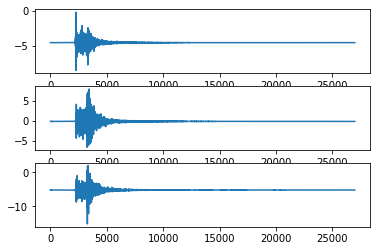

pgaZ:1.6761609881374293, pgaN:3.653127144908488, pgaE: 2.4511272753882345
pgvZ:0.05342074294561209, pgvN:0.11162926307773455, pgvE: 0.09679789905111089
station: NNSB, distance: 60.8, intensity: 2, pga: 4.053041336897355, pgv: 0.14268265758424664,  waveType: Velocity


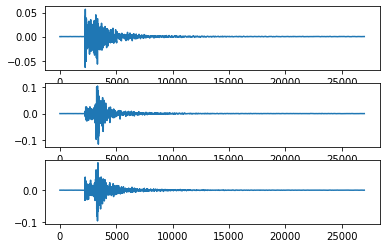

pgaZ:1.0360960976393858, pgaN:1.130636833529755, pgaE: 1.5882304186120004
pgvZ:0.04656093614757227, pgvN:0.052082988347209855, pgvE: 0.04113264857692393
station: ETLH, distance: 61.2, intensity: 1, pga: 1.7328245581095907, pgv: 0.07610084237323397,  waveType: Velocity
original intensity: 3
original pga: 15.7
original pgv: 0.6


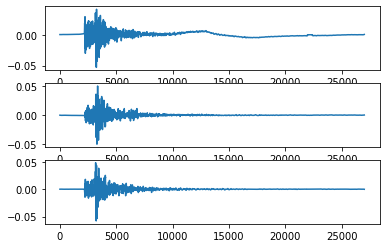

pgaZ:0.9495805919385828, pgaN:1.1889609678403283, pgaE: 1.6526774723710589
pgvZ:0.04173224940535003, pgvN:0.051856036087352474, pgvE: 0.042353114544616176
station: ETLH, distance: 61.2, intensity: 1, pga: 1.822022988105226, pgv: 0.07611106479026392,  waveType: Acceleration
original intensity: 3
original pga: 15.7
original pgv: 0.6


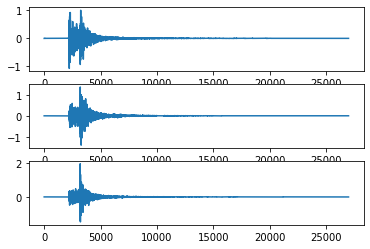

pgaZ:13.057609524978478, pgaN:4.987823570987415, pgaE: 15.804819437886232
pgvZ:4.220472604979702, pgvN:3.4477002000230765, pgvE: 5.546022496091067
station: ETLH, distance: 61.2, intensity: 3, pga: 23.726293947002233, pgv: 7.739070883421954,  waveType: Acceleration
original intensity: 3
original pga: 15.7
original pgv: 0.6


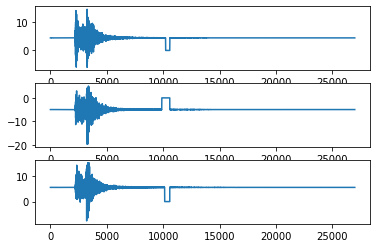

pgaZ:0.558682850857452, pgaN:0.9312400186086864, pgaE: 0.9893142428740627
pgvZ:0.021464742049122704, pgvN:0.046343671614698975, pgvE: 0.043258467527628346
station: NNSH, distance: 61.6, intensity: 1, pga: 1.3927115660914742, pgv: 0.07072075691430683,  waveType: Velocity


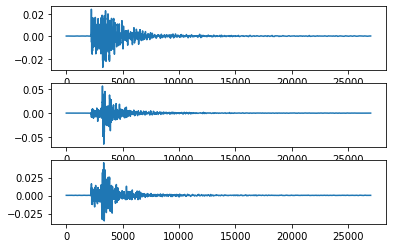

pgaZ:-0.01936185560418415, pgaN:124.59264240257737, pgaE: 31.035833907926058
pgvZ:1.918083214123505, pgvN:56.69015062852844, pgvE: 14.12175833276644
station: NNSH, distance: 61.6, intensity: 6 weak, pga: 128.47843488041576, pgv: 58.45826804881423,  waveType: Acceleration


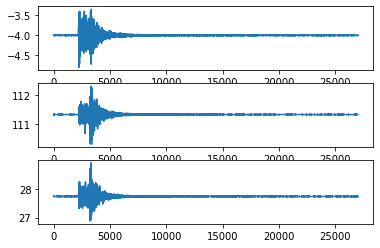

pgaZ:4.480336671409443, pgaN:4081.262959418632, pgaE: 3.658620070677729
pgvZ:1.5220357288990405, pgvN:1856.9839014156528, pgvE: 0.5063796379268831
station: NNSH, distance: 61.6, intensity: 7, pga: 4081.2644833987265, pgv: 1856.9845942091163,  waveType: Acceleration


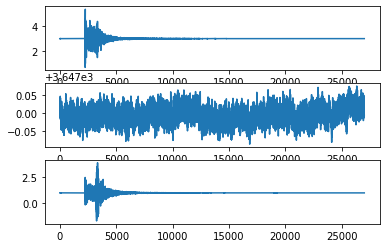

pgaZ:-0.1826763514781172, pgaN:-0.20432602479825077, pgaE: -0.18707091203265175
pgvZ:18.105123944500733, pgvN:20.24996766925817, pgvE: 18.539286917729015
station: TWD, distance: 62.0, intensity: 4, pga: 76.97568149049489, pgv: 35.0240575782477,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


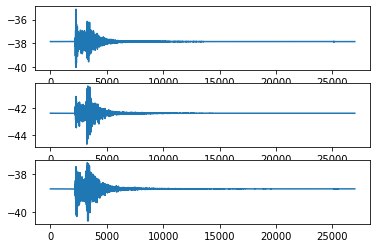

pgaZ:1.8702530238901955, pgaN:1.6714555725480278, pgaE: 1.667695063024027
pgvZ:0.05560115253796808, pgvN:0.08709331213695044, pgvE: 0.053368519476937396
station: TWD, distance: 62.0, intensity: 2, pga: 2.5043753459592075, pgv: 0.09958089935100448,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


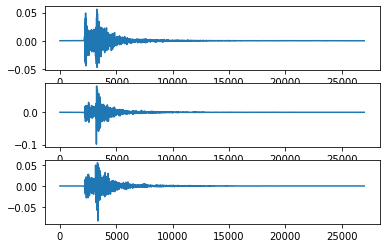

pgaZ:3.101535435940574, pgaN:6.2892070826284945, pgaE: 3.571692372894227
pgvZ:0.10225867822922084, pgvN:0.2716346493017758, pgvE: 0.25293447972574024
station: YHNB, distance: 62.6, intensity: 2, pga: 7.030440521665562, pgv: 0.388170121585354,  waveType: Velocity


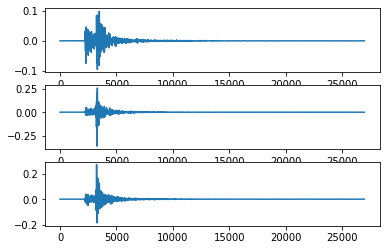

pgaZ:0.974217743099734, pgaN:3.0573672525694673, pgaE: 2.8517331719795487
pgvZ:0.04180903529330997, pgvN:0.2412234297683718, pgvE: 0.15046287282632215
station: WFSB, distance: 63.2, intensity: 2, pga: 3.656505294592849, pgv: 0.3109998299366413,  waveType: Velocity


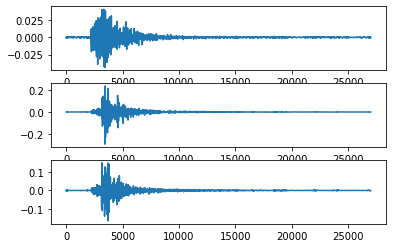

pgaZ:4.701094565986018, pgaN:4.71385552091853, pgaE: 2.081122770018256
pgvZ:1.2510567924463607, pgvN:1.518160280127455, pgvE: 2.53140307161471
station: NSK, distance: 63.6, intensity: 3, pga: 13.584931501101739, pgv: 3.3833657980002396,  waveType: Acceleration
original intensity: 3
original pga: 9.1
original pgv: 0.5


pgaZ:2.2750144501891914, pgaN:7.856741200104504, pgaE: 7.708584906563285
pgvZ:0.07164271989914672, pgvN:0.25304773306294615, pgvE: 0.34656198537956545
station: NSK, distance: 63.6, intensity: 3, pga: 9.41462065145888, pgv: 0.41592033184693683,  waveType: Velocity
original intensity: 3
original pga: 9.1
original pgv: 0.5


pgaZ:8.102088113694734e-06, pgaN:3.889396444907481e-05, pgaE: 9.335048617792766e-06
pgvZ:5.538748265302995e-07, pgvN:1.8031329865924057e-06, pgvE: 7.356135056367097e-07
station: NHDH, distance: 66.2, intensity: 0, pga: 4.4758722014159446e-05, pgv: 2.0057653831050493e-06,  waveType: Velocity
original intensity: 3
original pga: 8.6
original pgv: 0.4


pgaZ:0.023269123779695287, pgaN:0.04137270441954134, pgaE: 0.03647843201013807
pgvZ:0.00552011464861255, pgvN:0.010402514837053154, pgvE: 0.008846980733626436
station: NHDH, distance: 66.2, intensity: 0, pga: 0.07384240463962873, pgv: 0.021722307870093504,  waveType: Acceleration
original intensity: 3
original pga: 8.6
original pgv: 0.4


pgaZ:1.977667551834573, pgaN:5.781743716310795, pgaE: 7.208171940814018
pgvZ:0.08474932863496219, pgvN:0.2706451475137825, pgvE: 0.4027615327791203
station: NHDH, distance: 66.2, intensity: 3, pga: 8.5525886225616, pgv: 0.41705471333448246,  waveType: Acceleration
original intensity: 3
original pga: 8.6
original pgv: 0.4


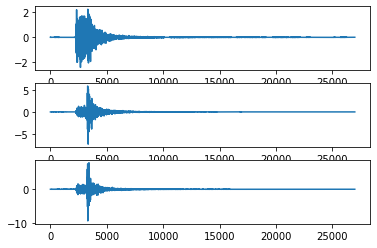

pgaZ:0.32823491772229074, pgaN:0.5585445394656099, pgaE: 0.8125836736310244
pgvZ:0.027658152114819628, pgvN:0.04962939622169194, pgvE: 0.0816648553043721
station: TATO, distance: 69.8, intensity: 1, pga: 0.8170245661179302, pgv: 0.08687347345358389,  waveType: Velocity


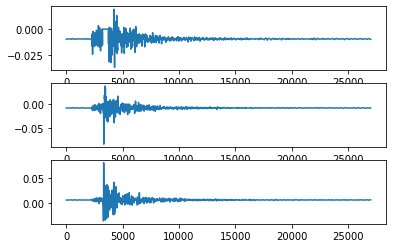

pgaZ:6.735229495751656, pgaN:3.735036356054646, pgaE: 2.504948394891923
pgvZ:0.18278075392292523, pgvN:2.0314970751747516, pgvE: 1.0850681858214761
station: NHY, distance: 70.0, intensity: 3, pga: 11.893591823944023, pgv: 2.4523551517628155,  waveType: Acceleration
original intensity: 3
original pga: 8.2
original pgv: 0.4


pgaZ:6.375691296690054, pgaN:-0.03346418786158241, pgaE: 5.298581998323144
pgvZ:2.253704076294952, pgvN:3.3165590616236944, pgvE: 0.2940656392392276
station: HWA, distance: 71.2, intensity: 3, pga: 11.856886898166257, pgv: 4.20024570433281,  waveType: Acceleration
original intensity: 2
original pga: 5.7
original pgv: 0.2


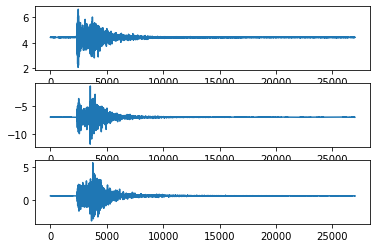

pgaZ:0.788709770617946, pgaN:0.9257119086312282, pgaE: 0.9832880939348629
pgvZ:0.05403216885467076, pgvN:0.08662423247858524, pgvE: 0.07458932960754026
station: HWA, distance: 71.2, intensity: 1, pga: 1.1135237764823591, pgv: 0.09050620882383585,  waveType: Velocity
original intensity: 2
original pga: 5.7
original pgv: 0.2


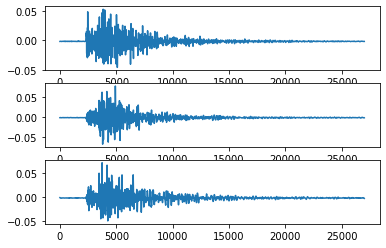

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: HWA, distance: 71.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Acceleration
original intensity: 2
original pga: 5.7
original pgv: 0.2


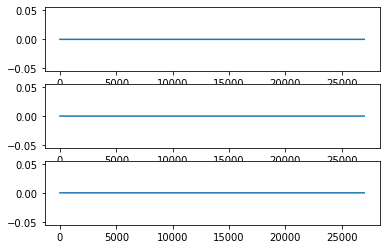

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: HWA, distance: 71.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 2
original pga: 5.7
original pgv: 0.2


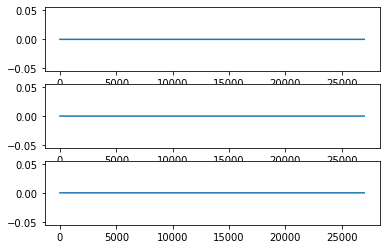

pgaZ:5.887129351468304, pgaN:10.537349089534159, pgaE: 1.880267500181636
pgvZ:2.6782039789493646, pgvN:4.794160584764497, pgvE: 0.447588505003829
station: NOU, distance: 71.7, intensity: 3, pga: 12.110407356611065, pgv: 5.509723247668639,  waveType: Acceleration
original intensity: 1
original pga: 1.6
original pgv: 0.1


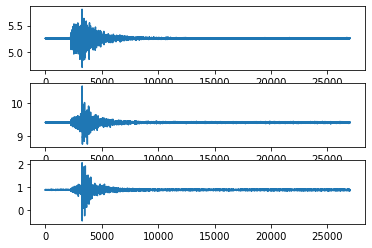

pgaZ:0.031114919186398093, pgaN:-0.00015329862399539234, pgaE: 0.09907425182572442
pgvZ:0.014000663367821378, pgvN:0.011651661952945806, pgvE: 0.04544147595193811
station: TAP, distance: 73.2, intensity: 0, pga: 0.10736337293023214, pgv: 0.0491897830749939,  waveType: Acceleration


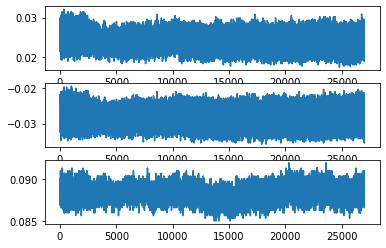

pgaZ:1.5256220324249716, pgaN:1.6607575240244208, pgaE: 2.720764549108686
pgvZ:0.0471491778102564, pgvN:0.09853036702755724, pgvE: 0.15899002494745265
station: TAP, distance: 73.2, intensity: 2, pga: 3.1828781646848134, pgv: 0.16246198417615054,  waveType: Velocity


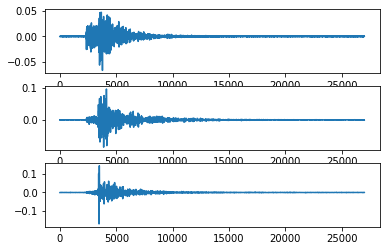

pgaZ:3.2781061875249415, pgaN:3.0732048224625, pgaE: 5.918762057591671
pgvZ:0.7936467635940446, pgvN:0.3997590509435902, pgvE: 1.4513280656680998
station: BAC, distance: 74.9, intensity: 2, pga: 6.341779100537055, pgv: 1.707881152133358,  waveType: Acceleration
original intensity: 2
original pga: 4.2
original pgv: 0.3


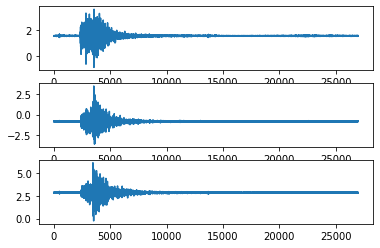

pgaZ:-0.1454894117377447, pgaN:-0.1532189688280222, pgaE: -0.15782995096937377
pgvZ:14.419925147065761, pgvN:15.186287015644986, pgvE: 15.639587509002638
station: EYL, distance: 78.7, intensity: 4, pga: 61.180286393826634, pgv: 27.835237702811348,  waveType: Acceleration
original intensity: 2
original pga: 7.9
original pgv: 0.5


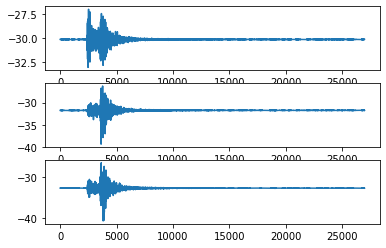

pgaZ:0.27779568775193186, pgaN:10.09336249044102, pgaE: -0.06378274807588682
pgvZ:1.1178281532324892, pgvN:2.922629533400219, pgvE: 6.32022525543681
station: ETM, distance: 79.0, intensity: 3, pga: 18.144148621045, pgv: 7.433957829343425,  waveType: Acceleration
original intensity: 2
original pga: 5.0
original pgv: 0.2


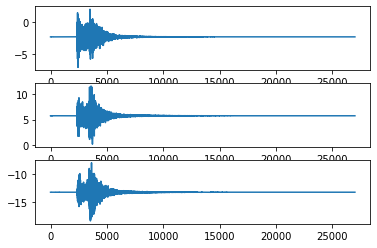

pgaZ:3.386010727508543, pgaN:7.475543126465852, pgaE: 6.392214969486454
pgvZ:0.1423135177874426, pgvN:0.26512206004639705, pgvE: 0.2415538226298824
station: YM01, distance: 79.8, intensity: 3, pga: 8.202786347748441, pgv: 0.30299659564870857,  waveType: Velocity


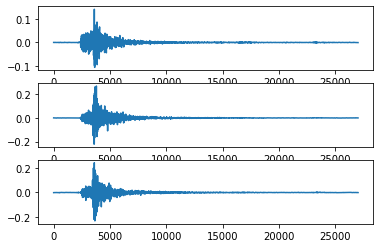

pgaZ:0.025358761382092882, pgaN:0.056708701391121795, pgaE: 0.019745253129793305
pgvZ:0.0010245376411850483, pgvN:0.0025863865089118454, pgvE: 0.0007253166625533754
station: LXIB, distance: 79.8, intensity: 0, pga: 0.06093961353972725, pgv: 0.002763725336479655,  waveType: Velocity


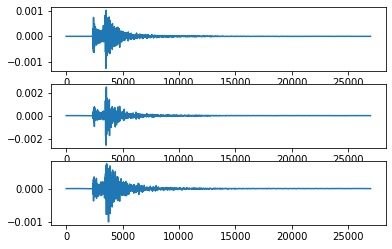

pgaZ:0.5918321950923292, pgaN:1.022155279075091, pgaE: 0.9675181464259281
pgvZ:0.03076922442530746, pgvN:0.04433796543132154, pgvE: 0.040560103903358014
station: FUSS, distance: 80.2, intensity: 1, pga: 1.142864092005228, pgv: 0.07555502105983483,  waveType: Velocity
original intensity: 2
original pga: 2.8
original pgv: 0.1


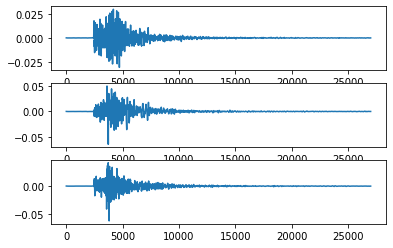

pgaZ:-0.01410776987128361, pgaN:-0.0076445169908514405, pgaE: 4.792861037534993
pgvZ:1.397984867911092, pgvN:0.7575590133714649, pgvE: 2.0106859751839825
station: FUSS, distance: 80.2, intensity: 2, pga: 5.777935460660708, pgv: 2.6288023216413614,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.1


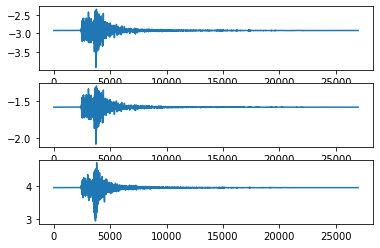

pgaZ:0.21640205384746367, pgaN:2.0251447376924308, pgaE: 0.7094231296971006
pgvZ:0.7643826861791401, pgvN:11.552221013904376, pgvE: 3.036947367917449
station: FUSS, distance: 80.2, intensity: 3, pga: 20.87479267109688, pgv: 16.378839773061568,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.1


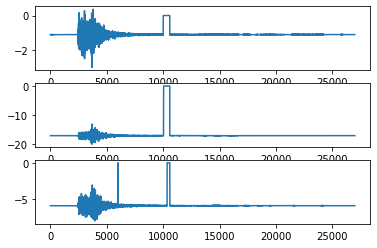

pgaZ:-0.004258616733873634, pgaN:-0.021770597174914925, pgaE: 3.5625383829518027
pgvZ:0.4092308536976269, pgvN:2.1582618308896566, pgvE: 1.3226091100240431
station: NWR, distance: 81.2, intensity: 2, pga: 6.454881509517718, pgv: 2.686179831433482,  waveType: Acceleration
original intensity: 1
original pga: 1.8
original pgv: 0.1


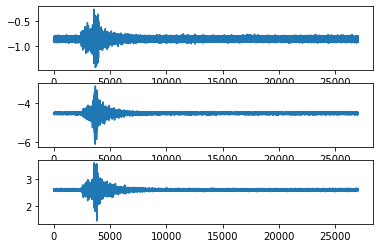

pgaZ:0.3746121235147587, pgaN:0.9913005965850911, pgaE: 0.903205924534995
pgvZ:0.02133799809267155, pgvN:0.05164638109274516, pgvE: 0.04783483059548971
station: ZUZH, distance: 82.6, intensity: 1, pga: 1.225771801731366, pgv: 0.05347175636443715,  waveType: Velocity
original intensity: 2
original pga: 4.4
original pgv: 0.1


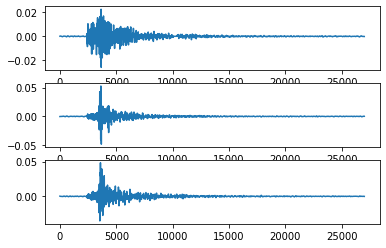

pgaZ:12.001189972906456, pgaN:-0.05991929682821436, pgaE: -0.022423916506497558
pgvZ:5.460056964574397, pgvN:5.939071623731234, pgvE: 2.222483524231105
station: ZUZH, distance: 82.6, intensity: 3, pga: 19.085788272053186, pgv: 8.683801666726813,  waveType: Acceleration
original intensity: 2
original pga: 4.4
original pgv: 0.1


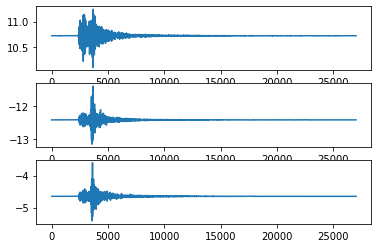

pgaZ:-0.033773790964945656, pgaN:2.611641001107861, pgaE: 4.167429420131636
pgvZ:3.3466297243672214, pgvN:1.2373991154609838, pgvE: 0.5482908827384246
station: ZUZH, distance: 82.6, intensity: 3, pga: 9.83988012804759, pgv: 3.8399107605308593,  waveType: Acceleration
original intensity: 2
original pga: 4.4
original pgv: 0.1


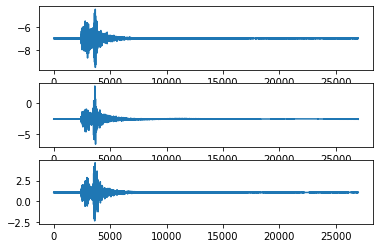

pgaZ:0.8956876552851235, pgaN:1.708478873149124, pgaE: 2.1918945886655794
pgvZ:0.03853202632187909, pgvN:0.07399550180357319, pgvE: 0.073590614303052
station: YM08, distance: 82.8, intensity: 2, pga: 2.7359661482133744, pgv: 0.09742217745462517,  waveType: Velocity


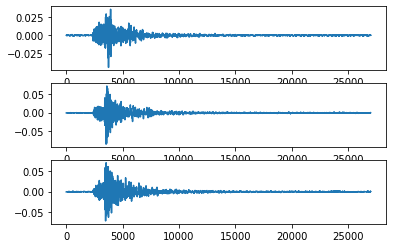

pgaZ:2.833646804358165, pgaN:6.427955637223054, pgaE: 11.190309387259973
pgvZ:0.17746632649379138, pgvN:0.20444769594956338, pgvE: 0.549953781725244
station: WHF, distance: 82.8, intensity: 3, pga: 11.814004793986049, pgv: 0.5699524808427504,  waveType: Velocity
original intensity: 3
original pga: 12.1
original pgv: 0.5


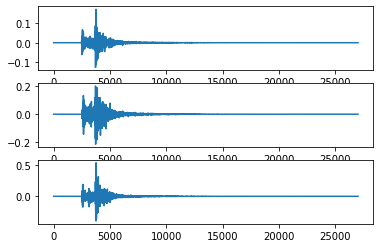

pgaZ:2.7896425848809434, pgaN:1.4308625402833612, pgaE: 10.223616723125827
pgvZ:0.1242551495702211, pgvN:2.351338768966686, pgvE: 0.7702246357905835
station: WHF, distance: 82.8, intensity: 3, pga: 14.120795702326193, pgv: 2.635434446503831,  waveType: Acceleration
original intensity: 3
original pga: 12.1
original pgv: 0.5


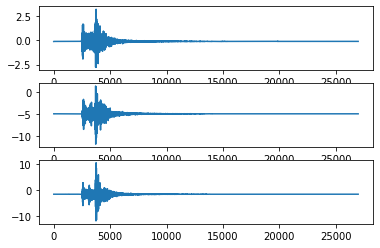

pgaZ:1.0263809643026247, pgaN:1.9208407405408998, pgaE: 2.1103743610630543
pgvZ:0.045373135125680905, pgvN:0.15140269087125885, pgvE: 0.08220072888318043
station: TWS1, distance: 84.5, intensity: 2, pga: 4.082151187174643, pgv: 0.16366267598662954,  waveType: Velocity
original intensity: 2
original pga: 3.3
original pgv: 0.2


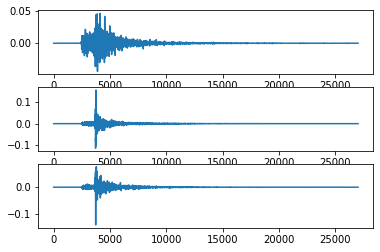

pgaZ:-0.02571358978369772, pgaN:8.109212235264978, pgaE: -0.024141527423901837
pgvZ:2.5510974328198834, pgvN:2.5583397399968586, pgvE: 2.3934327233188437
station: TWS1, distance: 84.5, intensity: 3, pga: 11.710163880661545, pgv: 4.518730425207475,  waveType: Acceleration
original intensity: 2
original pga: 3.3
original pgv: 0.2


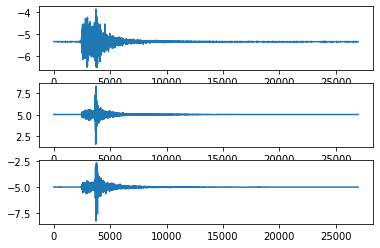

pgaZ:7.343050328318177, pgaN:0.7557873088733059, pgaE: 5.505650029896394
pgvZ:2.9027676878719446, pgvN:2.1063253669790787, pgvE: 0.24960711690785697
station: NTY, distance: 85.3, intensity: 3, pga: 12.923440725863166, pgv: 3.671097589006743,  waveType: Acceleration
original intensity: 2
original pga: 7.1
original pgv: 0.3


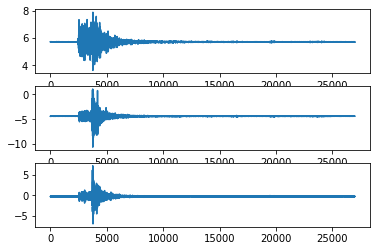

pgaZ:0.5534559943427984, pgaN:-0.0188271751253949, pgaE: -0.004390051771475893
pgvZ:0.1273616913707539, pgvN:1.8663941963008734, pgvE: 0.43580251656891067
station: ANP, distance: 85.4, intensity: 2, pga: 4.718509801693576, pgv: 2.0447269001120554,  waveType: Acceleration
original intensity: 1
original pga: 0.9
original pgv: 0.1


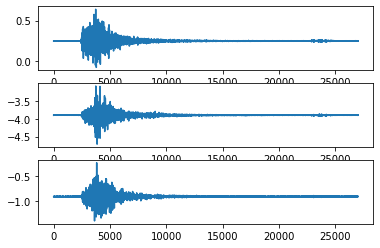

pgaZ:0.6380354235897746, pgaN:1.6243686076541457, pgaE: 1.2875674065480263
pgvZ:0.03379930731030073, pgvN:0.09819021683160019, pgvE: 0.07503635062791553
station: ANP, distance: 85.4, intensity: 1, pga: 1.866070496372693, pgv: 0.12958985743924686,  waveType: Velocity
original intensity: 1
original pga: 0.9
original pgv: 0.1


pgaZ:0.8010944235491858, pgaN:1.3432147178569527, pgaE: 0.9960730917064532
pgvZ:0.06742844431742173, pgvN:0.07637282971916037, pgvE: 0.06442016021298758
station: KSHI, distance: 85.4, intensity: 1, pga: 1.3671769188285396, pgv: 0.08056182655468214,  waveType: Velocity
original intensity: 2
original pga: 3.9
original pgv: 0.2


pgaZ:4.13091258650396, pgaN:3.688388521762925, pgaE: 4.725305819185466
pgvZ:1.6942365864894247, pgvN:1.1763502369172583, pgvE: 1.8867191730439223
station: KSHI, distance: 85.4, intensity: 2, pga: 6.442243850156722, pgv: 2.795343758614702,  waveType: Acceleration
original intensity: 2
original pga: 3.9
original pgv: 0.2


pgaZ:-0.043290329074149814, pgaN:0.8275125902952101, pgaE: 0.8979300910552992
pgvZ:4.29021051204229, pgvN:1.646265727591751, pgvE: 1.692005492512516
station: KSHI, distance: 85.4, intensity: 3, pga: 12.385854617128814, pgv: 5.216100997583842,  waveType: Acceleration
original intensity: 2
original pga: 3.9
original pgv: 0.2


pgaZ:0.8656378225187338, pgaN:1.2751084052523873, pgaE: 1.276729743033964
pgvZ:0.07070058438856479, pgvN:0.07278391640900857, pgvE: 0.12609250590819787
station: NFF, distance: 87.5, intensity: 1, pga: 1.8080395668050588, pgv: 0.15038666409135257,  waveType: Velocity
original intensity: 3
original pga: 13.4
original pgv: 0.7


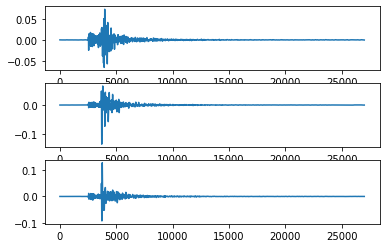

pgaZ:-0.07610049691652031, pgaN:-0.25847280288657887, pgaE: -0.6194232400882849
pgvZ:7.541386512546826, pgvN:25.615542138895947, pgvE: 61.38690657418685
station: NFF, distance: 87.5, intensity: 6 weak, pga: 156.6872583329913, pgv: 71.29293906246004,  waveType: Acceleration
original intensity: 3
original pga: 13.4
original pgv: 0.7


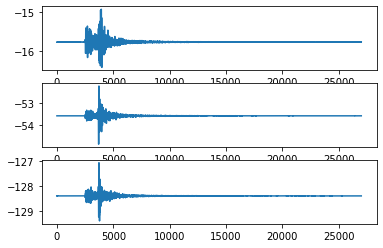

pgaZ:0.6317582626050197, pgaN:3.9260611305177937, pgaE: 5.282306900918601
pgvZ:3.601578932382953, pgvN:0.4888899260174273, pgvE: 0.22432492230923085
station: NFF, distance: 87.5, intensity: 3, pga: 9.935117281281228, pgv: 4.983051709815421,  waveType: Acceleration
original intensity: 3
original pga: 13.4
original pgv: 0.7


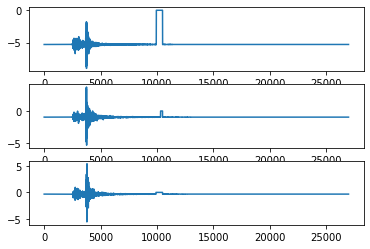

pgaZ:4.6205231927568535, pgaN:7.563482514610662, pgaE: 4.4748833648161375
pgvZ:0.24349009256016038, pgvN:0.269346632337267, pgvE: 0.22252999830696332
station: TWT, distance: 87.9, intensity: 2, pga: 7.675905364555681, pgv: 0.3037023614737789,  waveType: Velocity
original intensity: 3
original pga: 8.1
original pgv: 0.3


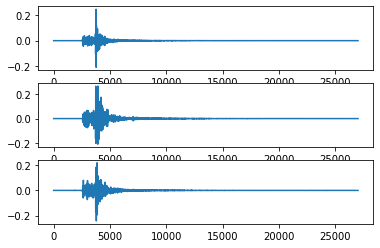

pgaZ:6.128837638044984, pgaN:8.828489869463919, pgaE: -0.0349596009093806
pgvZ:0.4926998876570516, pgvN:0.5690691421421293, pgvE: 3.4608315856390917
station: TWT, distance: 87.9, intensity: 3, pga: 12.703397428103877, pgv: 3.761470608269222,  waveType: Acceleration
original intensity: 3
original pga: 8.1
original pgv: 0.3


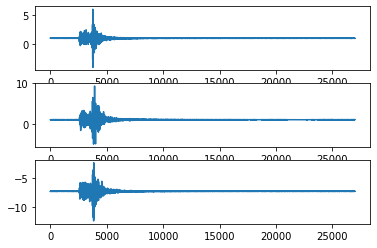

pgaZ:0.8604089575291536, pgaN:1.1018022729160184, pgaE: 1.5519630403670452
pgvZ:0.04842354667371919, pgvN:0.064180900382794, pgvE: 0.061374599882093456
station: TDCB, distance: 88.1, intensity: 1, pga: 1.8382154655075562, pgv: 0.07457333183703257,  waveType: Velocity


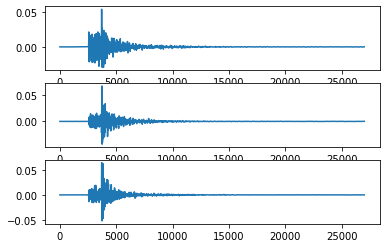

pgaZ:0.47611471598754257, pgaN:1.5570749730183597, pgaE: 1.1546002437756193
pgvZ:0.03808000208431092, pgvN:0.07157434989146497, pgvE: 0.05350411457316417
station: NTS, distance: 88.3, intensity: 1, pga: 1.5721190167129957, pgv: 0.1135593570189962,  waveType: Velocity
original intensity: 3
original pga: 9.0
original pgv: 0.3


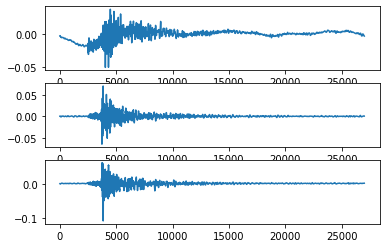

pgaZ:-0.16460866983292152, pgaN:-0.029694817050354025, pgaE: -0.2916568143060297
pgvZ:16.312838902643136, pgvN:2.9450135167806994, pgvE: 28.904190104692745
station: NTS, distance: 88.3, intensity: 4, pga: 77.99390193942874, pgv: 35.48464098496299,  waveType: Acceleration
original intensity: 3
original pga: 9.0
original pgv: 0.3


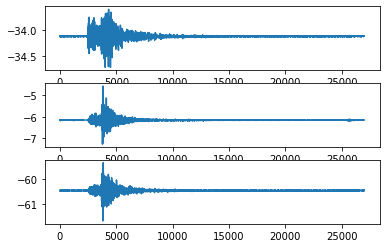

pgaZ:3.3801144172490183, pgaN:0.8988802807755145, pgaE: 5.399550043965942
pgvZ:1.0308209451187096, pgvN:1.1397498550629281, pgvE: 0.5723589791422432
station: NTS, distance: 88.3, intensity: 2, pga: 6.31828332981399, pgv: 1.693331490585091,  waveType: Acceleration
original intensity: 3
original pga: 9.0
original pgv: 0.3


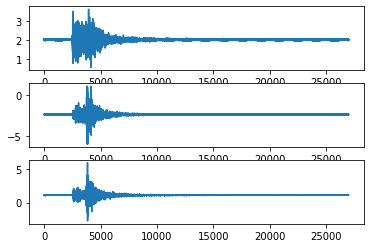

pgaZ:2.6778782656623212, pgaN:4.440608631346444, pgaE: -0.010610669464779116
pgvZ:1.2080467767323164, pgvN:1.9878887668502399, pgvE: 1.0554465316465207
station: TWY, distance: 90.4, intensity: 2, pga: 5.675499740950511, pgv: 2.5833487620160542,  waveType: Acceleration
original intensity: 0
original pga: 0.6


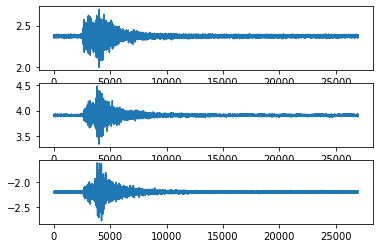

pgaZ:1.1821254320120016, pgaN:0.9882618764763923, pgaE: 1.181324566223836
pgvZ:0.1164560877076911, pgvN:0.08438730101802697, pgvE: 0.13209236742511968
station: TWY, distance: 90.4, intensity: 1, pga: 1.4370182963320306, pgv: 0.16230430077262445,  waveType: Velocity
original intensity: 0
original pga: 0.6


pgaZ:0.5032806374244638, pgaN:1.108902853517149, pgaE: 1.0838138683574858
pgvZ:0.04399920219909013, pgvN:0.06621842231718247, pgvE: 0.053750945709858215
station: SHUL, distance: 91.9, intensity: 1, pga: 1.1510293123504987, pgv: 0.07479645855004804,  waveType: Velocity
original intensity: 2
original pga: 7.3
original pgv: 0.4


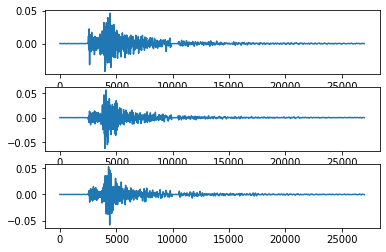

pgaZ:0.1361640622027826, pgaN:26.675749346834507, pgaE: 125.82456076388651
pgvZ:0.736355618213242, pgvN:19.765387946325024, pgvE: 105.74274531452416
station: SHUL, distance: 91.9, intensity: 6 strong, pga: 128.62433919980924, pgv: 107.30017671435483,  waveType: Acceleration
original intensity: 2
original pga: 7.3
original pgv: 0.4


pgaZ:2.9162387207131584, pgaN:7.273555029779677, pgaE: 0.09409682974363515
pgvZ:0.8930191417807527, pgvN:2.047026614764056, pgvE: 1.2863965125470171
station: SHUL, distance: 91.9, intensity: 2, pga: 7.876979367847347, pgv: 2.6193104288629043,  waveType: Acceleration
original intensity: 2
original pga: 7.3
original pgv: 0.4


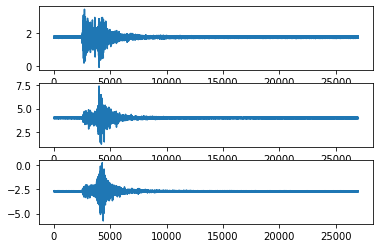

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: NCU, distance: 92.7, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 2
original pga: 2.9
original pgv: 0.2


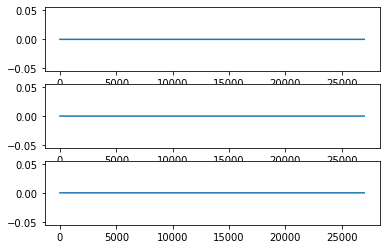

pgaZ:5.244086169384307, pgaN:13.399328517450407, pgaE: 4.4050095255540835
pgvZ:2.0904443343236765, pgvN:5.3769144701275255, pgvE: 0.8572149728143302
station: NCU, distance: 92.7, intensity: 3, pga: 14.055251135023495, pgv: 5.8323223713705845,  waveType: Acceleration
original intensity: 2
original pga: 2.9
original pgv: 0.2


pgaZ:0.3932924607726308, pgaN:1.3561141144797155, pgaE: 6.439580684276261
pgvZ:0.3848656045329254, pgvN:0.33366018770197714, pgvE: 2.1692009052548005
station: ESL, distance: 95.9, intensity: 2, pga: 6.528771192131366, pgv: 2.23591916059247,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


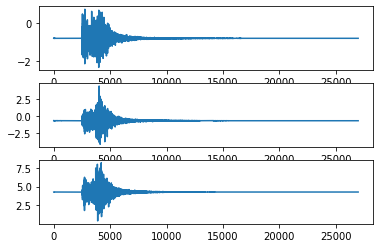

pgaZ:1.2172887724362043, pgaN:2.208541234145707, pgaE: 2.0146538876644624
pgvZ:0.04644344830018317, pgvN:0.06954073034996508, pgvE: 0.0544854606149505
station: ESL, distance: 95.9, intensity: 1, pga: 2.351899783484032, pgv: 0.0840919344007777,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


pgaZ:1.4172699499301604, pgaN:3.370985009175819, pgaE: 2.439556754620402
pgvZ:0.05870901127855706, pgvN:0.18448535496549284, pgvE: 0.09501091381864281
station: LIOB, distance: 97.9, intensity: 2, pga: 3.409438259974891, pgv: 0.22023760811231527,  waveType: Velocity
original intensity: 2
original pga: 3.4
original pgv: 0.2


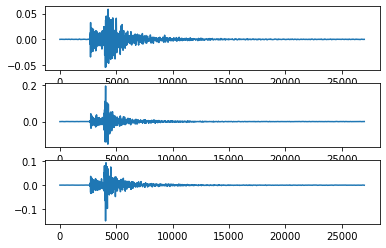

pgaZ:1.3517786549550217, pgaN:3.3193896746358322, pgaE: 2.3609968817516394
pgvZ:0.05429167474688025, pgvN:0.18076187411030648, pgvE: 0.08816520027345598
station: LIOB, distance: 97.9, intensity: 2, pga: 3.3526815076259457, pgv: 0.2124435395661211,  waveType: Acceleration
original intensity: 2
original pga: 3.4
original pgv: 0.2


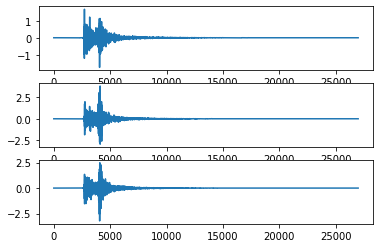

pgaZ:1.1850537391731195, pgaN:3.2058954831741704, pgaE: 2.7127625229672248
pgvZ:0.05006726112885152, pgvN:0.18451804368672875, pgvE: 0.08740731845747439
station: NST, distance: 98.5, intensity: 2, pga: 3.7031019947402655, pgv: 0.2258631139795711,  waveType: Velocity
original intensity: 2
original pga: 3.7
original pgv: 0.3


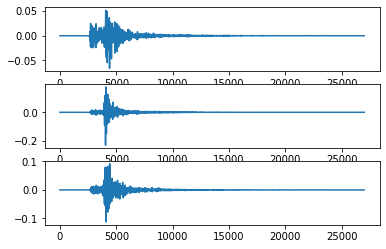

pgaZ:7.254636982865068, pgaN:12.31376606549958, pgaE: 3.780125930458343
pgvZ:3.109665261473151, pgvN:4.988436603806337, pgvE: 0.42190094303601244
station: NST, distance: 98.5, intensity: 3, pga: 13.634926773729626, pgv: 5.8934300873381416,  waveType: Acceleration
original intensity: 2
original pga: 3.7
original pgv: 0.3


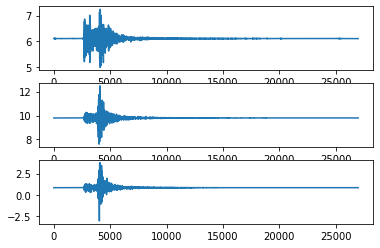

pgaZ:-0.014416082366311797, pgaN:4.628165350551499, pgaE: 0.30509635679606795
pgvZ:1.4290543406377987, pgvN:0.5221108432267455, pgvE: 0.9316383899371674
station: EGC, distance: 100.5, intensity: 2, pga: 6.311567927484039, pgv: 1.8898122536530348,  waveType: Acceleration
original intensity: 2
original pga: 5.2
original pgv: 0.2


pgaZ:2.886268831381546, pgaN:6.559904049298432, pgaE: -0.05380931995006894
pgvZ:0.9984282332077244, pgvN:2.5704796096229496, pgvE: 5.333356529227917
station: HSN1, distance: 100.7, intensity: 3, pga: 14.776111356893537, pgv: 6.314921387348712,  waveType: Acceleration
original intensity: 1
original pga: 2.5
original pgv: 0.1


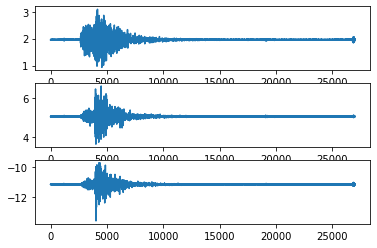

pgaZ:1.8953145583918063, pgaN:1.1124637515702827, pgaE: 2.212392636157628
pgvZ:0.46328849804747824, pgvN:0.1468578709801372, pgvE: 0.48537650289562556
station: HSN, distance: 102.8, intensity: 2, pga: 2.6940052990012826, pgv: 0.6889612662846195,  waveType: Acceleration
original intensity: 1
original pga: 1.8
original pgv: 0.1


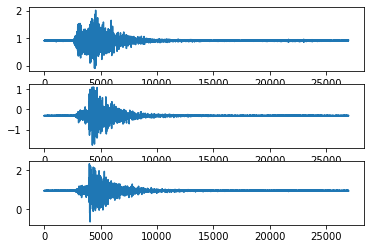

pgaZ:0.8625393156365765, pgaN:1.3268068772920516, pgaE: 1.2399007416184906
pgvZ:0.04641524722050395, pgvN:0.06549683263240237, pgvE: 0.05352063557558614
station: HSN, distance: 102.8, intensity: 1, pga: 1.6891551236265314, pgv: 0.0823575914843275,  waveType: Velocity
original intensity: 1
original pga: 1.8
original pgv: 0.1


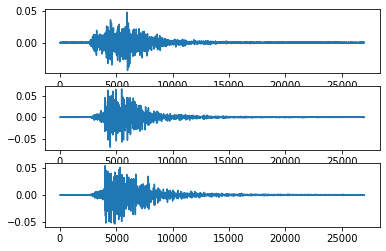

pgaZ:0.34044781692888126, pgaN:0.6807812364812548, pgaE: 0.8026850862797941
pgvZ:0.03086400327761013, pgvN:0.033616691624072936, pgvE: 0.041817659490393615
station: HSN, distance: 102.8, intensity: 1, pga: 0.836518177936891, pgv: 0.046020436204163954,  waveType: Velocity
original intensity: 1
original pga: 1.8
original pgv: 0.1


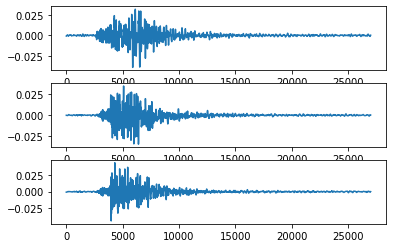

pgaZ:8.13546481555387, pgaN:2.1622537103075095, pgaE: 2.9126527804875337
pgvZ:3.7025538303520453, pgvN:0.7456592714333217, pgvE: 1.0672646578734204
station: HSN, distance: 102.8, intensity: 3, pga: 8.623507871366169, pgv: 3.924788716055266,  waveType: Acceleration
original intensity: 1
original pga: 1.8
original pgv: 0.1


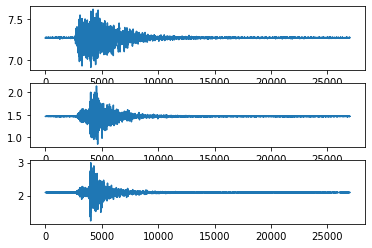

pgaZ:1.488735333781741, pgaN:0.06499492693819194, pgaE: -0.007502623404014291
pgvZ:0.24248127029929264, pgvN:0.6596770785895005, pgvE: 0.7436224947399721
station: HSN, distance: 102.8, intensity: 2, pga: 3.7340373629374213, pgv: 1.08690120824662,  waveType: Acceleration
original intensity: 1
original pga: 1.8
original pgv: 0.1


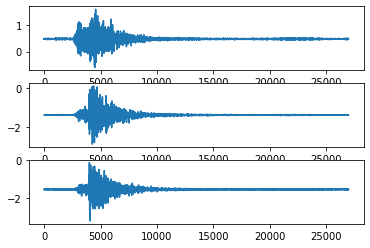

pgaZ:0.5325875205456898, pgaN:0.5740982970305064, pgaE: 0.8139709701955394
pgvZ:0.02578516267748158, pgvN:0.03296857368367398, pgvE: 0.03227446795002896
station: OWD, distance: 102.8, intensity: 1, pga: 0.9456533569529199, pgv: 0.07211307952564841,  waveType: Velocity
original intensity: 2
original pga: 5.1
original pgv: 0.2


pgaZ:0.5491781226786077, pgaN:0.5562973460744094, pgaE: 0.834220742612592
pgvZ:0.025719327009312908, pgvN:0.03318114207276579, pgvE: 0.03131955788138025
station: OWD, distance: 102.8, intensity: 1, pga: 0.9696813657079759, pgv: 0.07241329868957391,  waveType: Acceleration
original intensity: 2
original pga: 5.1
original pgv: 0.2


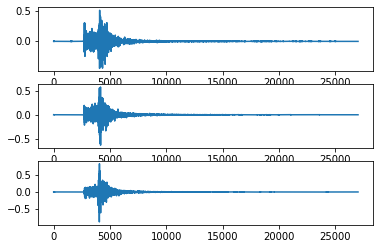

pgaZ:-0.03761978291400653, pgaN:6.2673283144370595, pgaE: 6.812498915520083
pgvZ:3.7275010218780427, pgvN:1.3905283788888894, pgvE: 1.47106734874636
station: OWD, distance: 102.8, intensity: 3, pga: 12.642278120404896, pgv: 4.456242462798017,  waveType: Acceleration
original intensity: 2
original pga: 5.1
original pgv: 0.2


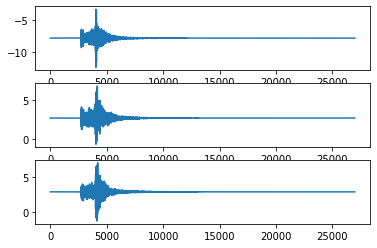

pgaZ:0.9537441406301457, pgaN:1.0507917947439298, pgaE: 1.0270195175708425
pgvZ:0.05602422728115416, pgvN:0.09171162259054332, pgvE: 0.07913738237292954
station: SBCB, distance: 104.4, intensity: 1, pga: 1.2663147997532704, pgv: 0.09531473350953534,  waveType: Velocity


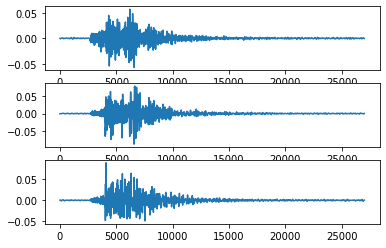

pgaZ:0.1761416821666762, pgaN:0.13795420228513336, pgaE: 0.1614684753587755
pgvZ:0.009895257812898748, pgvN:0.010553664821927685, pgvE: 0.013621493044791242
station: YOJ, distance: 104.9, intensity: 0, pga: 0.2165013608659831, pgv: 0.015274836887794109,  waveType: Velocity


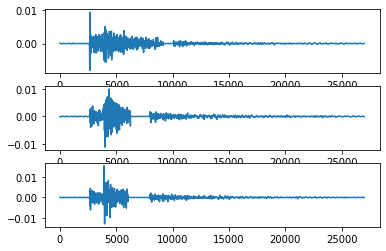

pgaZ:1.9912934157555864, pgaN:5.715865962809334, pgaE: 4.897517413061341
pgvZ:0.12922760065035757, pgvN:0.2533391606083515, pgvE: 0.28766540825957304
station: WUSB, distance: 105.2, intensity: 2, pga: 6.571035714211741, pgv: 0.30773635502950764,  waveType: Velocity


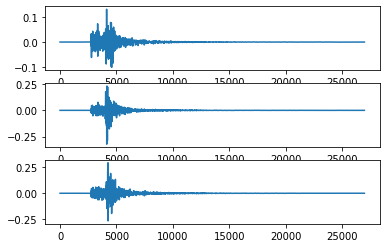

pgaZ:0.03767325057900353, pgaN:0.05466600163772817, pgaE: 0.05689996099929479
pgvZ:0.0015859651008289604, pgvN:0.0017614198160125331, pgvE: 0.002267162313488142
station: WARB, distance: 107.6, intensity: 0, pga: 0.07185824506842026, pgv: 0.002894199648994669,  waveType: Velocity


pgaZ:-0.021801469016442757, pgaN:-0.01835525583191889, pgaE: 3.776192155441132
pgvZ:2.161972354499126, pgvN:1.8175523992108902, pgvE: 0.312873783732964
station: NHW, distance: 107.8, intensity: 2, pga: 7.458628015650145, pgv: 3.023653150493326,  waveType: Acceleration
original intensity: 2
original pga: 3.8
original pgv: 0.2


pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: WHP, distance: 107.8, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 2
original pga: 3.1
original pgv: 0.2


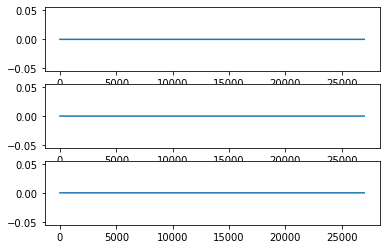

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: WHP, distance: 107.8, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Acceleration
original intensity: 2
original pga: 3.1
original pgv: 0.2


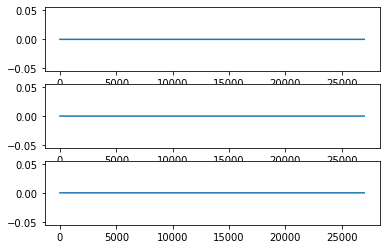

pgaZ:-0.03077845608629059, pgaN:6.842236795999791, pgaE: 7.403437859983186
pgvZ:3.050617358972957, pgvN:2.382610566072249, pgvE: 2.7311051263277926
station: WHP, distance: 107.8, intensity: 3, pga: 11.71719835589272, pgv: 4.86717728956232,  waveType: Acceleration
original intensity: 2
original pga: 3.1
original pgv: 0.2


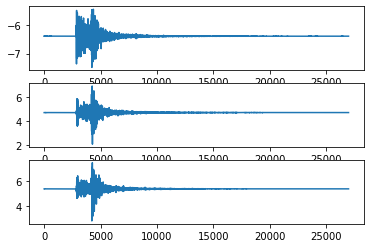

pgaZ:1.1074704515564073, pgaN:10.527356368696006, pgaE: 0.29413301568742206
pgvZ:6.474297412593291, pgvN:8.511185275803246, pgvE: 1.7296740239177955
station: EGFH, distance: 110.0, intensity: 3, pga: 14.462258582360342, pgv: 11.189739540982725,  waveType: Acceleration
original intensity: 2
original pga: 2.9
original pgv: 0.1


pgaZ:0.8856154161404761, pgaN:4.7058722535579065, pgaE: -0.016333818093940432
pgvZ:0.23089083814859807, pgvN:0.9713570956926653, pgvE: 1.6163188601146397
station: NJN, distance: 113.2, intensity: 2, pga: 6.146505205481554, pgv: 1.9902543946020843,  waveType: Acceleration
original intensity: 2
original pga: 3.1
original pgv: 0.2


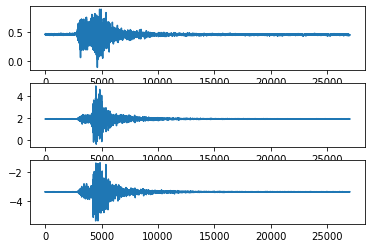

pgaZ:1.616043654041086, pgaN:1.2379802733783714, pgaE: 0.764581221741679
pgvZ:0.16946585537932735, pgvN:0.09610108264609989, pgvE: 0.5359875922330436
station: WPL, distance: 117.8, intensity: 2, pga: 2.895706633496344, pgv: 0.5951564955148483,  waveType: Acceleration
original intensity: 1
original pga: 2.1
original pgv: 0.1


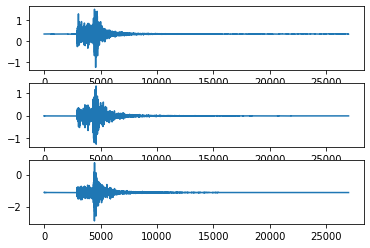

pgaZ:0.9872496482677433, pgaN:0.8768602439689159, pgaE: 1.887671401322696
pgvZ:0.056178805633088, pgvN:0.062048661588495105, pgvE: 0.16724789611727453
station: DPDB, distance: 119.5, intensity: 1, pga: 2.0693309210600255, pgv: 0.17322804576706644,  waveType: Velocity
original intensity: 1
original pga: 2.2
original pgv: 0.2


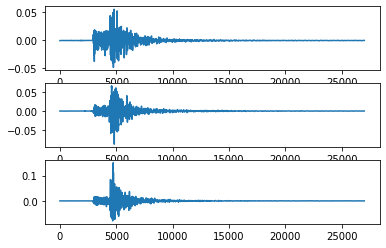

pgaZ:1.7252954226904682, pgaN:1.4043602836597884, pgaE: 1.6880098212978714
pgvZ:0.3589956774816456, pgvN:0.22200573999876302, pgvE: 0.1729585286910456
station: DPDB, distance: 119.5, intensity: 1, pga: 2.4346961589839915, pgv: 0.45644936518136797,  waveType: Acceleration
original intensity: 1
original pga: 2.2
original pgv: 0.2


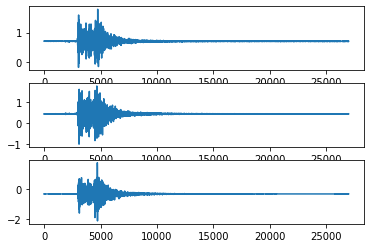

pgaZ:0.44942758620267725, pgaN:0.40604160075199075, pgaE: 0.5716369736908925
pgvZ:0.02775167101037415, pgvN:0.03694690647244036, pgvE: 0.054966851567675376
station: WCS, distance: 119.7, intensity: 0, pga: 0.6028169686021473, pgv: 0.06605267504243609,  waveType: Velocity
original intensity: 2
original pga: 4.0
original pgv: 0.2


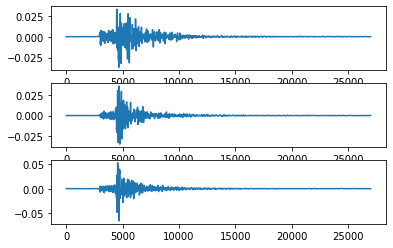

pgaZ:27.048069989637494, pgaN:2.277052922095951, pgaE: 13.28447637591613
pgvZ:12.30736624910944, pgvN:0.8993217639890397, pgvE: 6.044220255102887
station: WCS, distance: 119.7, intensity: 4, pga: 30.199044701142046, pgv: 13.740911254974998,  waveType: Acceleration
original intensity: 2
original pga: 4.0
original pgv: 0.2


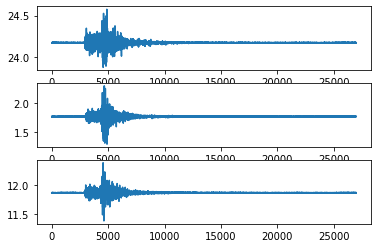

pgaZ:-0.015051820777586806, pgaN:4.846248180521742, pgaE: -0.01493158656268846
pgvZ:1.4917859285795068, pgvN:1.72803446217876, pgvE: 1.481915464848088
station: WCS, distance: 119.7, intensity: 2, pga: 7.009350293754772, pgv: 2.82872246921982,  waveType: Acceleration
original intensity: 2
original pga: 4.0
original pgv: 0.2


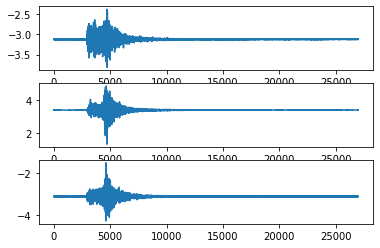

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: NMLH, distance: 120.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 2
original pga: 6.9
original pgv: 0.3


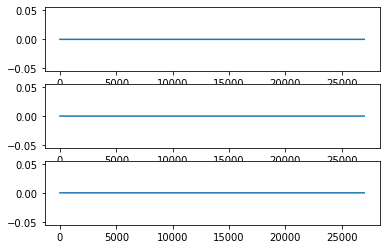

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: NMLH, distance: 120.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Acceleration
original intensity: 2
original pga: 6.9
original pgv: 0.3


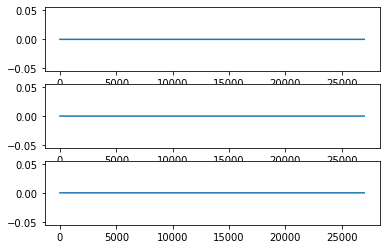

pgaZ:-0.02998040148490281, pgaN:-0.029625710550952686, pgaE: 1.9374352986770778
pgvZ:2.9774756568796557, pgvN:2.9357712655850747, pgvE: 0.4545310914428542
station: NMLH, distance: 120.2, intensity: 3, pga: 11.551318984219115, pgv: 4.479087400798723,  waveType: Acceleration
original intensity: 2
original pga: 6.9
original pgv: 0.3


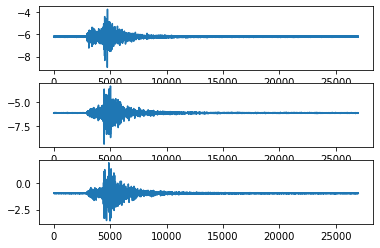

pgaZ:1.0620409175209404, pgaN:1.0081951356338097, pgaE: 1.1825721050932976
pgvZ:0.03911633156064379, pgvN:0.06418049960291608, pgvE: 0.08819603540223818
station: VWDT, distance: 120.3, intensity: 1, pga: 1.841030001000138, pgv: 0.09599306928316913,  waveType: Velocity


pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: PCY, distance: 122.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Acceleration
original intensity: 0
original pga: 0.1


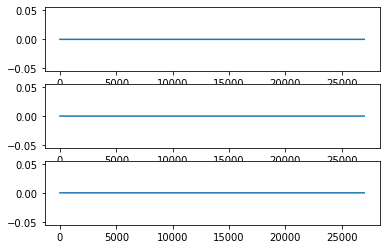

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: PCY, distance: 122.2, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 0
original pga: 0.1


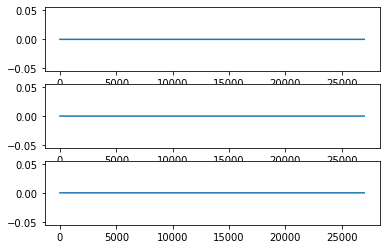

pgaZ:0.5965609357191486, pgaN:-0.0008214650652351306, pgaE: 0.119769953127129
pgvZ:0.24218897642092968, pgvN:0.0826751323824621, pgvE: 0.01555169524467653
station: PCY, distance: 122.2, intensity: 0, pga: 0.621730555033303, pgv: 0.25817149661359906,  waveType: Acceleration
original intensity: 0
original pga: 0.1


pgaZ:0.1216430271211502, pgaN:0.11666180653955555, pgaE: 0.13275422165585377
pgvZ:0.007977328967886822, pgvN:0.008104890251975375, pgvE: 0.015822797323998654
station: PCY, distance: 122.2, intensity: 0, pga: 0.1455540039101963, pgv: 0.01804251349584087,  waveType: Velocity
original intensity: 0
original pga: 0.1


pgaZ:4.99941558026191, pgaN:4.025726313399782, pgaE: 0.19315153205985394
pgvZ:2.084317739433506, pgvN:1.3720973713148084, pgvE: 0.43883244854949155
station: TWQ1, distance: 122.6, intensity: 2, pga: 6.066651817509812, pgv: 2.5389070405656433,  waveType: Acceleration
original intensity: 1
original pga: 1.5
original pgv: 0.1


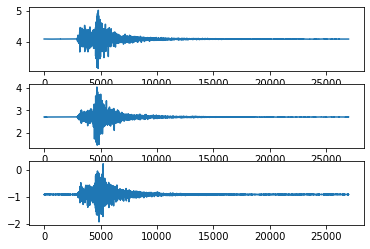

pgaZ:1.1509260788683842, pgaN:1.2917156419642677, pgaE: 0.9983927745732181
pgvZ:0.05623121853885847, pgvN:0.07808657634536192, pgvE: 0.06926317454620813
station: TWQ1, distance: 122.6, intensity: 1, pga: 1.422767824586878, pgv: 0.11845223046662044,  waveType: Velocity
original intensity: 1
original pga: 1.5
original pgv: 0.1


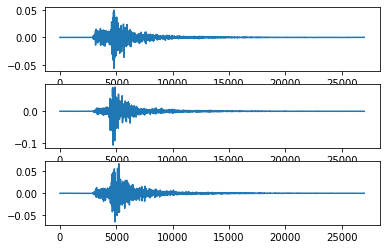

pgaZ:0.6806022240654958, pgaN:1.3014294428817934, pgaE: 0.7475300350145558
pgvZ:0.04623927572732171, pgvN:0.08994141113889761, pgvE: 0.052437909589362945
station: NSY, distance: 122.8, intensity: 1, pga: 1.6373214528888789, pgv: 0.09195859966319732,  waveType: Velocity
original intensity: 1
original pga: 1.8
original pgv: 0.2


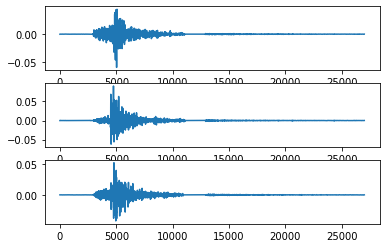

pgaZ:0.2605156382508565, pgaN:0.20485400069155035, pgaE: 0.10631008108855612
pgvZ:0.220025074247047, pgvN:0.8815458160249549, pgvE: 0.4589552262662686
station: NSY, distance: 122.8, intensity: 2, pga: 3.7804028431101693, pgv: 1.0788259552366948,  waveType: Acceleration
original intensity: 1
original pga: 1.8
original pgv: 0.2


pgaZ:0.2941254732313, pgaN:0.843068402539859, pgaE: 0.6610821995979524
pgvZ:0.01095850064246076, pgvN:0.03130714791781501, pgvE: 0.03680895718887768
station: HGSD, distance: 127.5, intensity: 1, pga: 0.9323797795689741, pgv: 0.0379795540337475,  waveType: Velocity


pgaZ:0.7700517482218969, pgaN:1.4169596172686807, pgaE: 2.137865935792392
pgvZ:0.03826939182098225, pgvN:0.10930335077122848, pgvE: 0.10514189781444763
station: SML, distance: 129.6, intensity: 1, pga: 2.3193715996685182, pgv: 0.11447217171102386,  waveType: Velocity
original intensity: 2
original pga: 2.9
original pgv: 0.2


pgaZ:4.720744298858424, pgaN:2.636969244932152, pgaE: 2.1395437944677234
pgvZ:1.9717327019664, pgvN:0.5777569492069976, pgvE: 0.35355099939422185
station: SML, distance: 129.6, intensity: 2, pga: 5.442887632484155, pgv: 2.088874494895144,  waveType: Acceleration
original intensity: 2
original pga: 2.9
original pgv: 0.2


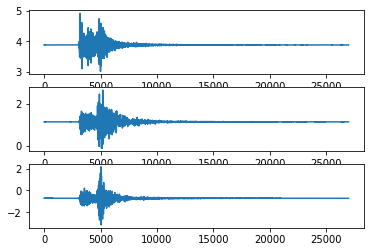

pgaZ:1.8509014549025724, pgaN:-0.011317045477306905, pgaE: -0.013658606812452212
pgvZ:0.5694402395653292, pgvN:1.1251093963590062, pgvE: 1.3519774214118447
station: EHY, distance: 130.9, intensity: 2, pga: 4.738740225490639, pgv: 1.9573344270307007,  waveType: Acceleration
original intensity: 1
original pga: 1.3


pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: EHY, distance: 130.9, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 1
original pga: 1.3


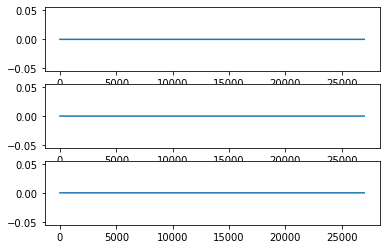

pgaZ:0.2763366547780308, pgaN:0.25034667902140406, pgaE: 0.2067115626540854
pgvZ:0.013837952113195398, pgvN:0.018018558514101262, pgvE: 0.014588139000719603
station: EHYH, distance: 131.0, intensity: 0, pga: 0.3530897165509241, pgv: 0.021610506087537364,  waveType: Velocity
original intensity: 1
original pga: 2.5
original pgv: 0.1


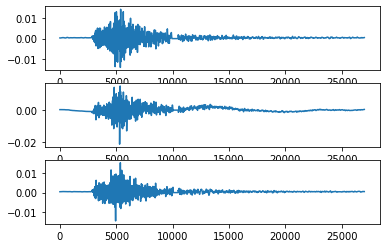

pgaZ:1.2265140662949334, pgaN:18.34358242048718, pgaE: 104.58472683489111
pgvZ:7.171373828960547, pgvN:107.63671461552849, pgvE: 92.10556282843388
station: EHYH, distance: 131.0, intensity: 7, pga: 201.9896074294933, pgv: 145.51071176228973,  waveType: Acceleration
original intensity: 1
original pga: 2.5
original pgv: 0.1


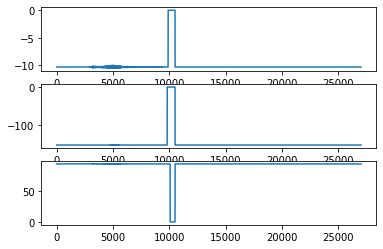

pgaZ:0.602204535412706, pgaN:0.1805361927802768, pgaE: 5.685264932403693
pgvZ:3.4535024609151304, pgvN:1.0840307007159153, pgvE: 3.8393221545044653
station: EHYH, distance: 131.0, intensity: 3, pga: 8.23259357270772, pgv: 5.964522040206352,  waveType: Acceleration
original intensity: 1
original pga: 2.5
original pgv: 0.1


pgaZ:0.32261974669626814, pgaN:0.6847488333054842, pgaE: 0.6371857097385613
pgvZ:0.017819704460193205, pgvN:0.039547782016835745, pgvE: 0.034780703250302955
station: TYC, distance: 131.5, intensity: 1, pga: 0.8091057776517024, pgv: 0.044320956492484596,  waveType: Velocity
original intensity: 1
original pga: 0.8
original pgv: 0.1


pgaZ:1.9880363954585414, pgaN:5.011612141823806, pgaE: 0.002571099839146558
pgvZ:0.8333489935980039, pgvN:2.1406751956464833, pgvE: 0.30984167420294584
station: TYC, distance: 131.5, intensity: 2, pga: 5.327215514977666, pgv: 2.3207205277349927,  waveType: Acceleration
original intensity: 1
original pga: 0.8
original pgv: 0.1


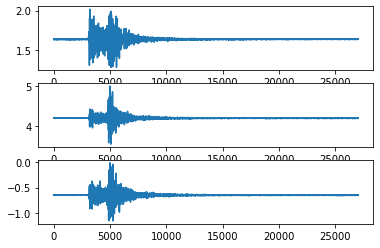

pgaZ:0.9525234865263733, pgaN:1.1035424249263155, pgaE: 2.337451058448961
pgvZ:0.037998438997726765, pgvN:0.06894047687734152, pgvE: 0.09005195149861919
station: SSLB, distance: 132.0, intensity: 2, pga: 2.568718607882641, pgv: 0.12452427409539103,  waveType: Velocity


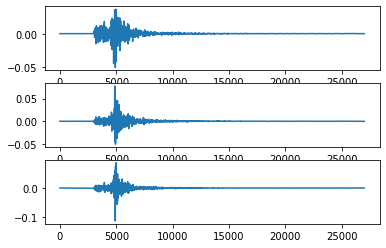

pgaZ:8.018503145897993, pgaN:8.099162654896212, pgaE: 4.779333879640458
pgvZ:6.667347270299347, pgvN:6.648017661366508, pgvE: 2.898716366905863
station: WDJ, distance: 136.7, intensity: 3, pga: 11.800439779766602, pgv: 9.762723659132106,  waveType: Acceleration
original intensity: 1
original pga: 1.4
original pgv: 0.1


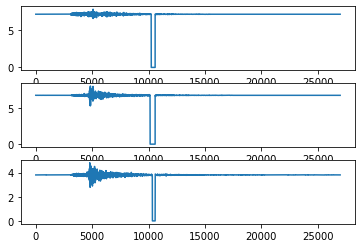

pgaZ:1.4062221131535204, pgaN:2.1787886471231817, pgaE: -0.01386901668852432
pgvZ:0.5233765426883757, pgvN:0.6244615839693384, pgvE: 1.378898616451357
station: TCU, distance: 137.5, intensity: 2, pga: 4.157538014706405, pgv: 1.6795629356346964,  waveType: Acceleration
original intensity: 1
original pga: 1.1
original pgv: 0.1


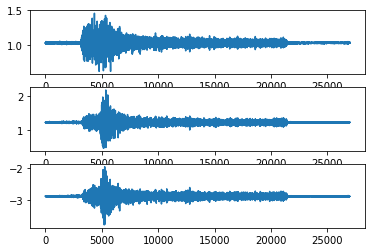

pgaZ:0.17133732350533024, pgaN:0.32704741159265316, pgaE: 0.4857214152722165
pgvZ:0.023254516467553304, pgvN:0.027005415085106274, pgvE: 0.031841871238598954
station: TCU, distance: 137.5, intensity: 0, pga: 0.48724957630290416, pgv: 0.0380530492045359,  waveType: Velocity
original intensity: 1
original pga: 1.1
original pgv: 0.1


pgaZ:2.785849201504892, pgaN:1.7349096699249482, pgaE: 3.0067418249446503
pgvZ:0.9145523295747182, pgvN:0.07656159613363578, pgvE: 0.5253116452139137
station: WWF, distance: 140.1, intensity: 2, pga: 3.901346103392385, pgv: 1.05550185735089,  waveType: Acceleration
original intensity: 1
original pga: 2.3
original pgv: 0.1


pgaZ:0.4630607390663101, pgaN:0.7780006511221469, pgaE: 0.6011986511014243
pgvZ:0.015990690151525374, pgvN:0.02673170527685459, pgvE: 0.03145821441633158
station: YULB, distance: 143.2, intensity: 1, pga: 0.9442429596738877, pgv: 0.034031173802465585,  waveType: Velocity


pgaZ:15.363419274707375, pgaN:3.8967327525013276, pgaE: -0.03034110412959785
pgvZ:6.990819015022633, pgvN:0.9259392533137282, pgvE: 3.007238097960675
station: ECB, distance: 144.2, intensity: 3, pga: 17.021471566304903, pgv: 7.745053491631461,  waveType: Acceleration
original intensity: 2
original pga: 3.3
original pgv: 0.3


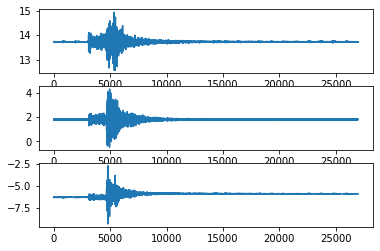

pgaZ:0.662002601483492, pgaN:1.0241538393781537, pgaE: 0.8989228291281307
pgvZ:0.053253995276636934, pgvN:0.04563260997380683, pgvE: 0.04486498460717183
station: WHY, distance: 146.3, intensity: 1, pga: 1.2144810418638483, pgv: 0.06744156570414651,  waveType: Velocity
original intensity: 2
original pga: 6.4
original pgv: 0.3


pgaZ:0.32890746112264735, pgaN:1.083678470079818, pgaE: 0.9846482293016614
pgvZ:0.11721803720720231, pgvN:0.04733626276670329, pgvE: 0.049596610769322126
station: WHY, distance: 146.3, intensity: 1, pga: 1.277329966119259, pgv: 0.11723126444431639,  waveType: Acceleration
original intensity: 2
original pga: 6.4
original pgv: 0.3


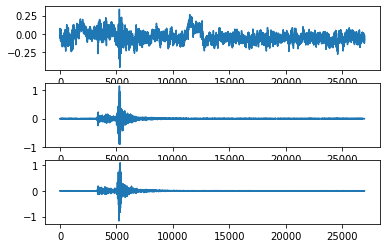

pgaZ:-0.031074532840477766, pgaN:9.841903724548933, pgaE: 2.424547703930775
pgvZ:3.0804256006854702, pgvN:1.8251473218203451, pgvE: 1.2707579895197116
station: WHY, distance: 146.3, intensity: 3, pga: 11.563765358706634, pgv: 3.9904381203071964,  waveType: Acceleration
original intensity: 2
original pga: 6.4
original pgv: 0.3


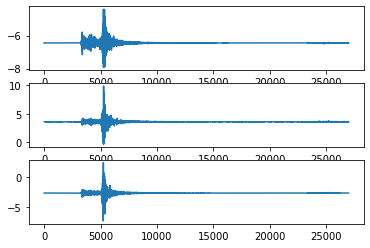

pgaZ:0.1471045926749984, pgaN:0.18728817509831033, pgaE: 0.16339470615668222
pgvZ:0.010747968644693575, pgvN:0.014023445311261424, pgvE: 0.011289991378945133
station: EYUL, distance: 146.6, intensity: 0, pga: 0.22157588156749464, pgv: 0.01697841694734547,  waveType: Velocity
original intensity: 1
original pga: 1.0
original pgv: 0.1


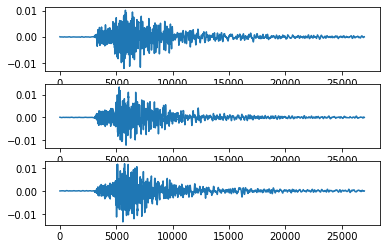

pgaZ:3.6718017474072635, pgaN:-0.008301957276530233, pgaE: -0.007256674520163231
pgvZ:1.6705730646595869, pgvN:0.8230311851907142, pgvE: 0.7192451464562857
station: EYUL, distance: 146.6, intensity: 2, pga: 4.475121532504825, pgv: 2.0361261092507874,  waveType: Acceleration
original intensity: 1
original pga: 1.0
original pgv: 0.1


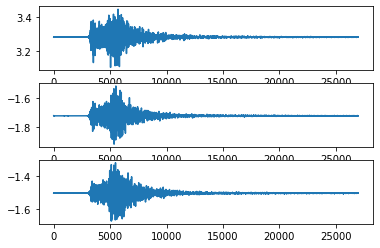

pgaZ:-0.029087662439282583, pgaN:-0.03199733043982258, pgaE: -0.006249173319341581
pgvZ:2.881832313208868, pgvN:3.172359757555074, pgvE: 0.6216675829618346
station: EYUL, distance: 146.6, intensity: 3, pga: 10.134928588119491, pgv: 4.61151357277596,  waveType: Acceleration
original intensity: 1
original pga: 1.0
original pgv: 0.1


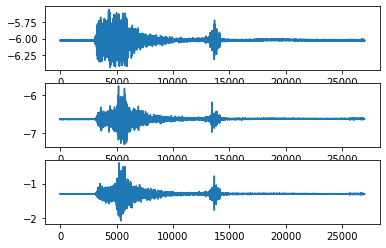

pgaZ:0.28465208365375855, pgaN:0.27366758471124025, pgaE: 0.35634400612188327
pgvZ:0.013878755020267773, pgvN:0.015339796089810138, pgvE: 0.0152003211569189
station: TWF1, distance: 146.9, intensity: 0, pga: 0.3933897371675479, pgv: 0.02382956424134778,  waveType: Velocity
original intensity: 0
original pga: 0.4


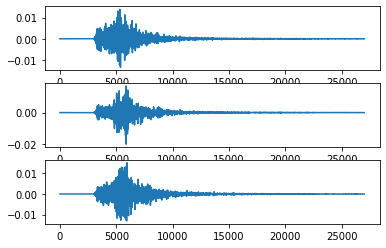

pgaZ:2.8256282238240162, pgaN:-0.02658228198633828, pgaE: -0.009995972041111318
pgvZ:1.2860320935650322, pgvN:2.6330565519606823, pgvE: 0.9878342782369078
station: TWF1, distance: 146.9, intensity: 2, pga: 7.163739712077166, pgv: 3.2593256384307483,  waveType: Acceleration
original intensity: 0
original pga: 0.4


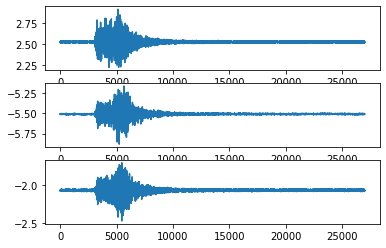

pgaZ:-0.01802912052400712, pgaN:3.591360409357652, pgaE: -0.021122145702267097
pgvZ:1.7806732746294314, pgvN:0.33718399026801354, pgvE: 2.094463714043821
station: WNT1, distance: 148.2, intensity: 2, pga: 7.239324390416273, pgv: 2.946586062071257,  waveType: Acceleration
original intensity: 2
original pga: 2.9
original pgv: 0.1


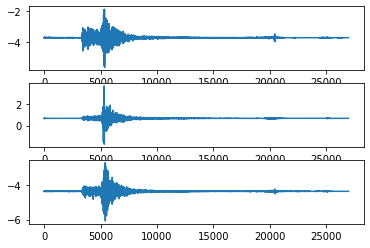

pgaZ:0.4289892174149219, pgaN:0.6904904767674443, pgaE: 0.5578291293218232
pgvZ:0.02617351740368458, pgvN:0.04485206963724181, pgvE: 0.04465891575619978
station: WJS, distance: 148.7, intensity: 1, pga: 0.8094790935291244, pgv: 0.0553277699663398,  waveType: Velocity


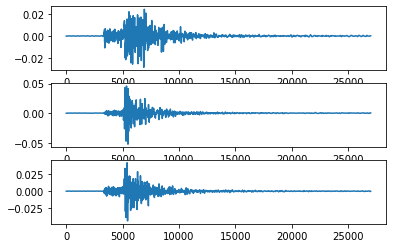

pgaZ:-0.012749178336933434, pgaN:0.6201310084215342, pgaE: -0.25407934073854
pgvZ:1.2630786981916513, pgvN:0.06765601793073255, pgvE: 25.181220988416236
station: WJS, distance: 148.7, intensity: 4, pga: 59.01436390694843, pgv: 26.850975037946892,  waveType: Acceleration


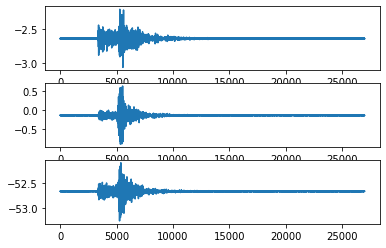

pgaZ:13.99183301866961, pgaN:5.717226173809202, pgaE: 7.734653365199864
pgvZ:14.641135960270518, pgvN:5.986502386639074, pgvE: 8.207514087115271
station: WJS, distance: 148.7, intensity: 3, pga: 16.93516117705632, pgv: 17.713352922800027,  waveType: Acceleration


pgaZ:0.9580507457109664, pgaN:4.032672169808837, pgaE: 3.7860561073500127
pgvZ:0.047619823836008365, pgvN:0.14198583863857422, pgvE: 0.13489564761602446
station: WNT, distance: 148.7, intensity: 2, pga: 4.977061292842037, pgv: 0.2585897872765776,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


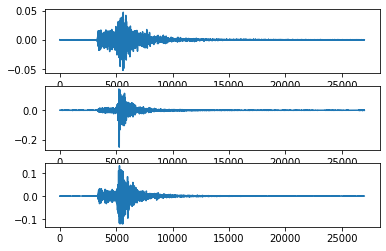

pgaZ:6.972479919091349, pgaN:0.012111725613555883, pgaE: 3.3708103717754354
pgvZ:3.172057189174705, pgvN:0.9408616269150372, pgvE: 0.8647897246737478
station: WNT, distance: 148.7, intensity: 3, pga: 8.09759397482279, pgv: 3.437106251213541,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


pgaZ:-0.013649589246334835, pgaN:-0.008976987069847828, pgaE: 1.002063028626401
pgvZ:1.3888358395109694, pgvN:0.9044204741081336, pgvE: 0.226069002585843
station: WWC, distance: 150.2, intensity: 2, pga: 4.672739979773641, pgv: 1.781484453804431,  waveType: Acceleration
original intensity: 1
original pga: 1.9
original pgv: 0.1


pgaZ:0.38039665811456946, pgaN:0.43541191759511527, pgaE: 0.6290393849230308
pgvZ:0.046652539673780906, pgvN:0.03713881906154125, pgvE: 0.04911585700178907
station: WCHH, distance: 152.5, intensity: 0, pga: 0.6967909553766917, pgv: 0.0504269857393333,  waveType: Velocity
original intensity: 3
original pga: 9.3
original pgv: 0.3


pgaZ:-0.012070512387783696, pgaN:46.50375108371708, pgaE: -0.27859125504926285
pgvZ:1.1966623220098018, pgvN:21.15909257420358, pgvE: 27.61036020396456
station: WCHH, distance: 152.5, intensity: 4, pga: 79.6664161647286, pgv: 36.24854320205205,  waveType: Acceleration
original intensity: 3
original pga: 9.3
original pgv: 0.3


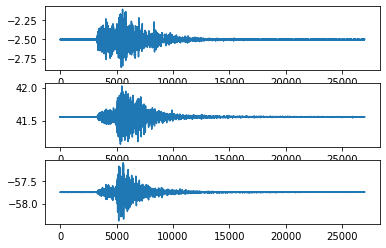

pgaZ:5.074538699881504, pgaN:693.668989271705, pgaE: 0.9889817284495317
pgvZ:1.7614676220743501, pgvN:315.6205480533477, pgvE: 1.5679552160997714
station: WCHH, distance: 152.5, intensity: 7, pga: 693.6895080233661, pgv: 315.62988318769175,  waveType: Acceleration
original intensity: 3
original pga: 9.3
original pgv: 0.3


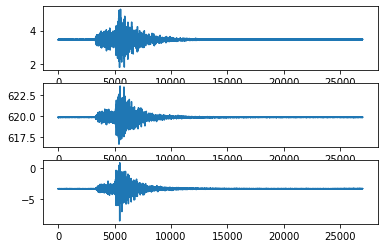

pgaZ:3.1106789145193376, pgaN:2.001243953294788, pgaE: 3.1584939958004092
pgvZ:0.766292347947696, pgvN:0.30700552371886536, pgvE: 0.725812639129147
station: WCH1, distance: 153.4, intensity: 2, pga: 4.391480678422568, pgv: 1.105038047867086,  waveType: Acceleration
original intensity: 2
original pga: 6.0
original pgv: 0.3


pgaZ:0.14976255677088796, pgaN:-0.029595651997228096, pgaE: 4.922241708360023
pgvZ:0.9707601162810215, pgvN:2.932572446265704, pgvE: 1.305785230909541
station: WYL, distance: 154.8, intensity: 3, pga: 8.788206471649886, pgv: 3.5397796887115436,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.2


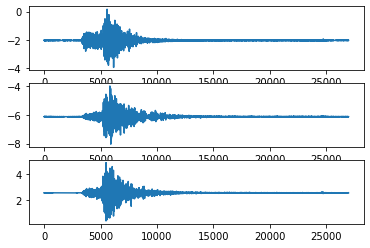

pgaZ:0.3467757997893534, pgaN:0.40423865478719856, pgaE: 0.35367975029586374
pgvZ:0.018011363815878114, pgvN:0.022454306792966977, pgvE: 0.01556874268991244
station: CHKH, distance: 159.1, intensity: 0, pga: 0.44577837348487914, pgv: 0.025753608124056075,  waveType: Velocity
original intensity: 2
original pga: 3.5
original pgv: 0.2


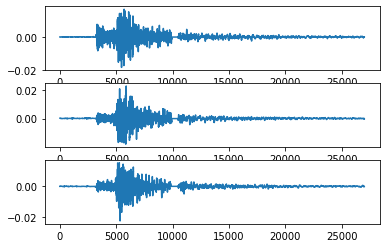

pgaZ:30.36916729316064, pgaN:88.61802905279539, pgaE: 7.224616460305408
pgvZ:26.474979341086055, pgvN:62.15000702368266, pgvE: 41.07255128415523
station: CHKH, distance: 159.1, intensity: 6 strong, pga: 115.70657961027742, pgv: 85.31909001144795,  waveType: Acceleration
original intensity: 2
original pga: 3.5
original pgv: 0.2


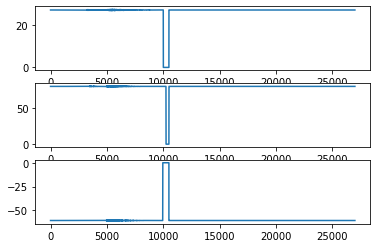

pgaZ:8.973596354236715, pgaN:0.2093971573292032, pgaE: 6.543902896776477
pgvZ:7.24014180215432, pgvN:1.2349973713076483, pgvE: 5.080935947879297
station: CHKH, distance: 159.1, intensity: 3, pga: 10.858385804235557, pgv: 8.984398772079029,  waveType: Acceleration
original intensity: 2
original pga: 3.5
original pgv: 0.2


pgaZ:0.5486840585958528, pgaN:1.2036065291473268, pgaE: 1.4517997699674625
pgvZ:0.02728921092869699, pgvN:0.05906426408099112, pgvE: 0.07062848933517654
station: FULB, distance: 162.5, intensity: 1, pga: 1.6194020495541017, pgv: 0.09023563480930552,  waveType: Velocity
original intensity: 1
original pga: 1.6
original pgv: 0.1


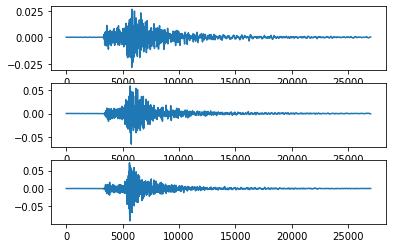

pgaZ:0.5338416018160193, pgaN:1.2173038893357992, pgaE: 1.4311686266983925
pgvZ:0.02495395509681165, pgvN:0.05796687464086641, pgvE: 0.06909203945758258
station: FULB, distance: 162.5, intensity: 1, pga: 1.6148668201274194, pgv: 0.08746404611106899,  waveType: Acceleration
original intensity: 1
original pga: 1.6
original pgv: 0.1


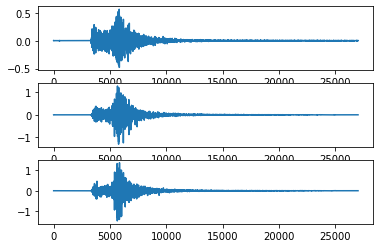

pgaZ:0.6372467240375036, pgaN:1.9041536879927756, pgaE: 1.3881080177311003
pgvZ:0.03712558243616351, pgvN:0.1221624173502107, pgvE: 0.11744017612367097
station: ALS, distance: 163.2, intensity: 1, pga: 2.17375861143125, pgv: 0.156625139659179,  waveType: Acceleration
original intensity: 1
original pga: 2.1
original pgv: 0.2


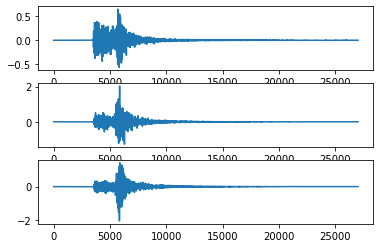

pgaZ:0.6470020803045461, pgaN:2.0083510125588933, pgaE: 1.4163752533389329
pgvZ:0.042455051729753904, pgvN:0.1239205658741969, pgvE: 0.12226608843813691
station: ALS, distance: 163.2, intensity: 1, pga: 2.244094518831642, pgv: 0.1646634783077183,  waveType: Velocity
original intensity: 1
original pga: 2.1
original pgv: 0.2


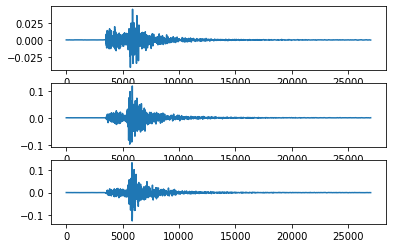

pgaZ:0.6481000096878404, pgaN:1.2607105433348842, pgaE: 1.1649622517571745
pgvZ:0.026623602606866376, pgvN:0.11641366030638638, pgvE: 0.11725256626565707
station: ALS, distance: 163.2, intensity: 1, pga: 2.1216023521944196, pgv: 0.1254183036531989,  waveType: Velocity
original intensity: 1
original pga: 2.1
original pgv: 0.2


pgaZ:2.8266108745854996, pgaN:-0.03749203406067703, pgaE: 4.424185757234937
pgvZ:1.1179897664407754, pgvN:3.718949993863081, pgvE: 1.5295248134999735
station: ALS, distance: 163.2, intensity: 3, pga: 9.782980942542858, pgv: 4.390126593817801,  waveType: Acceleration
original intensity: 1
original pga: 2.1
original pgv: 0.2


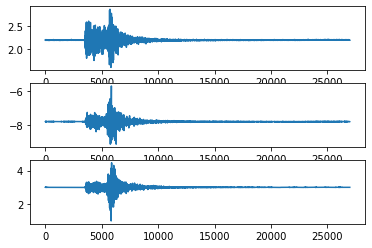

pgaZ:2.2286457800344293, pgaN:3.69844437480113, pgaE: 7.014025973126137
pgvZ:0.22599989615863672, pgvN:0.46832276467161327, pgvE: 0.8058386775494307
station: CHN5, distance: 167.2, intensity: 2, pga: 7.683256757615693, pgv: 0.8121454706170217,  waveType: Velocity
original intensity: 2
original pga: 4.0
original pgv: 0.3


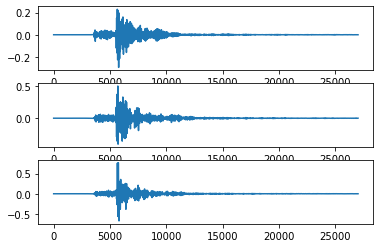

pgaZ:4.795573432759635, pgaN:1.95767136357432, pgaE: -0.05361093349548667
pgvZ:1.8692654604184578, pgvN:0.16200511789921682, pgvE: 5.313496204643439
station: CHN5, distance: 167.2, intensity: 3, pga: 15.433150153884185, pgv: 5.961093962011518,  waveType: Acceleration
original intensity: 2
original pga: 4.0
original pgv: 0.3


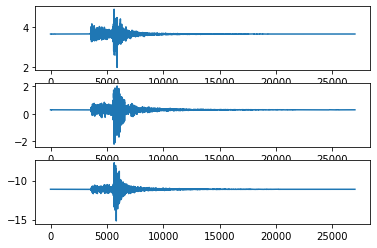

pgaZ:-0.021037981751838256, pgaN:3.4327280450446813, pgaE: 6.782656870939568
pgvZ:2.0868998000337924, pgvN:0.7934354452904548, pgvE: 2.589437325618443
station: CHK, distance: 169.7, intensity: 3, pga: 8.300603859135277, pgv: 3.5026626981393725,  waveType: Acceleration
original intensity: 2
original pga: 2.7
original pgv: 0.1


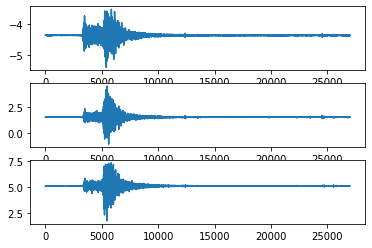

pgaZ:0.6149880052330176, pgaN:1.53300518150129, pgaE: 1.9080592560898644
pgvZ:0.02507314281426872, pgvN:0.08214321087961737, pgvE: 0.07993387423883445
station: CHK, distance: 169.7, intensity: 2, pga: 2.52799310978877, pgv: 0.09769728684323506,  waveType: Velocity
original intensity: 2
original pga: 2.7
original pgv: 0.1


pgaZ:1.264643142769931, pgaN:2.2704718855122894, pgaE: 4.736012080717136
pgvZ:0.06901464550492219, pgvN:0.20524346801726484, pgvE: 0.33294209409967135
station: WGK, distance: 170.4, intensity: 2, pga: 4.914628925543585, pgv: 0.33870602402357664,  waveType: Velocity
original intensity: 2
original pga: 4.6
original pgv: 0.4


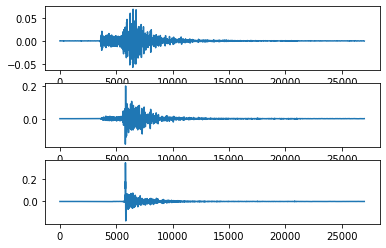

pgaZ:3.1238331621191646, pgaN:-0.016393935201389605, pgaE: 3.7291687992253477
pgvZ:0.9579221155701302, pgvN:1.6290972918167537, pgvE: 0.29604485044298606
station: WGK, distance: 170.4, intensity: 2, pga: 7.344189536465557, pgv: 1.9944174248064988,  waveType: Acceleration
original intensity: 2
original pga: 4.6
original pgv: 0.4


pgaZ:4.893123586241169, pgaN:6.480203162320136, pgaE: 5.0754091649398605
pgvZ:1.2137488689193752, pgvN:0.21821960840013074, pgvE: 0.7714238644501308
station: WDL, distance: 171.3, intensity: 2, pga: 6.863233634535534, pgv: 1.4405112730260945,  waveType: Acceleration
original intensity: 3
original pga: 13.5
original pgv: 0.6


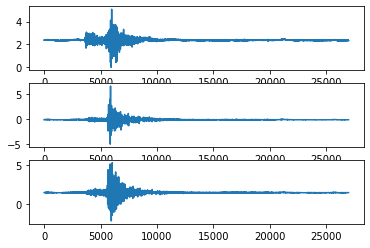

pgaZ:1.6938657132952802e-05, pgaN:2.0154563354940575e-05, pgaE: 1.652975279398764e-05
pgvZ:3.86122999529458e-06, pgvN:7.047937195691621e-06, pgvE: 3.100333102383556e-06
station: EHD, distance: 171.4, intensity: 0, pga: 2.2185408619184365e-05, pgv: 2.2557720741800824e-05,  waveType: Velocity
original intensity: 1
original pga: 2.2
original pgv: 0.1


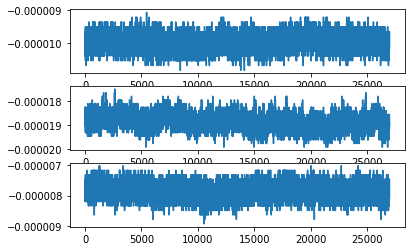

pgaZ:-1.5498926688167042e-05, pgaN:0.20794109285523574, pgaE: -0.0001382789475763808
pgvZ:0.002391440137106204, pgvN:0.09514050303940069, pgvE: 0.013886926733987462
station: EHD, distance: 171.4, intensity: 0, pga: 0.21062584111599936, pgv: 0.09630406807279725,  waveType: Acceleration
original intensity: 1
original pga: 2.2
original pgv: 0.1


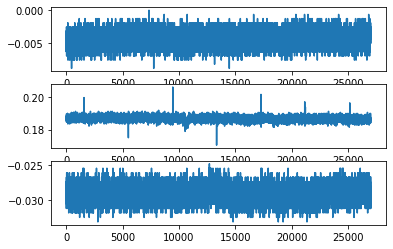

pgaZ:0.37109688779742234, pgaN:0.45756413937631596, pgaE: 0.18245573575209936
pgvZ:2.005744306182142, pgvN:1.9782715386987864, pgvE: 1.0588781457522263
station: EHD, distance: 171.4, intensity: 2, pga: 5.973564582533383, pgv: 4.786194657502364,  waveType: Acceleration
original intensity: 1
original pga: 2.2
original pgv: 0.1


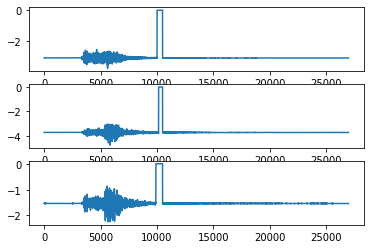

pgaZ:0.6867474099423775, pgaN:1.2398878743161725, pgaE: 1.24141695165917
pgvZ:0.04358139478810044, pgvN:0.04969230418723137, pgvE: 0.09744331585020956
station: WDLH, distance: 173.2, intensity: 1, pga: 1.4111365672915106, pgv: 0.1153141801991629,  waveType: Velocity


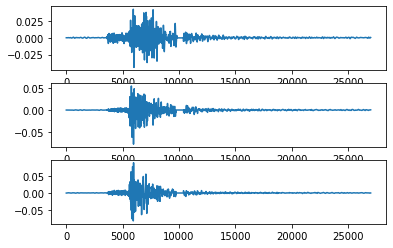

pgaZ:2.8820237618159505, pgaN:5.052833122231388, pgaE: 5.301133883501016
pgvZ:12.812316246997934, pgvN:28.193857797042106, pgvE: 25.986475521073594
station: WDLH, distance: 173.2, intensity: 4, pga: 73.95584367235531, pgv: 63.40606346108861,  waveType: Acceleration


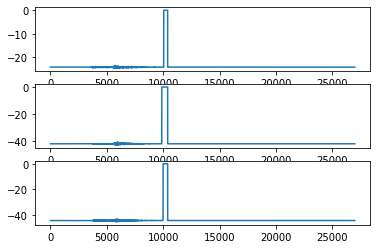

pgaZ:1.3451617514607415, pgaN:4.984548463273923, pgaE: 1.4793489347288216
pgvZ:0.19540008981216853, pgvN:3.382103197882842, pgvE: 14.746888139997912
station: WDLH, distance: 173.2, intensity: 3, pga: 14.436699166134943, pgv: 15.263601306855149,  waveType: Acceleration


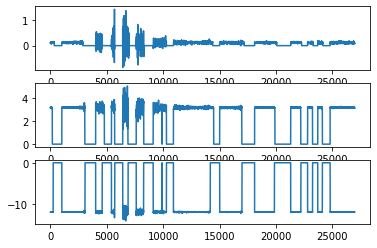

pgaZ:-0.0059110145899399814, pgaN:4.070659986771438, pgaE: 4.932758456433867
pgvZ:0.5862971026772037, pgvN:1.6668583044102525, pgvE: 2.053940541668349
station: ECS, distance: 176.1, intensity: 2, pga: 6.289041306395683, pgv: 2.717967556989738,  waveType: Acceleration
original intensity: 1
original pga: 1.0
original pgv: 0.1


pgaZ:0.215570158561096, pgaN:1.0362002023676253, pgaE: 0.8808866150855672
pgvZ:0.02468001557502401, pgvN:0.042611951099055995, pgvE: 0.05544975777605987
station: WRL, distance: 176.4, intensity: 1, pga: 1.1017082160454192, pgv: 0.05602852409223387,  waveType: Velocity
original intensity: 3
original pga: 8.2
original pgv: 0.5


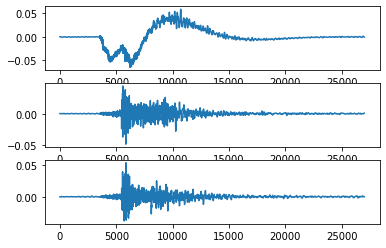

pgaZ:52.91571911171017, pgaN:143.89170109635552, pgaE: -0.5519654283335081
pgvZ:24.076703843001244, pgvN:65.47132086298328, pgvE: 54.70162667043007
station: WRL, distance: 176.4, intensity: 6 strong, pga: 199.74348489296793, pgv: 90.88372388167815,  waveType: Acceleration
original intensity: 3
original pga: 8.2
original pgv: 0.5


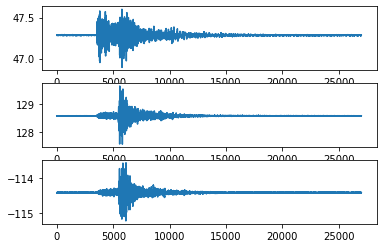

pgaZ:9.252753768133408, pgaN:2.455017870349155, pgaE: 4.729673848371339
pgvZ:6.792785669734326, pgvN:0.23391752339860217, pgvE: 0.8418004342019616
station: WRL, distance: 176.4, intensity: 3, pga: 9.331923477616083, pgv: 6.847179950117177,  waveType: Acceleration
original intensity: 3
original pga: 8.2
original pgv: 0.5


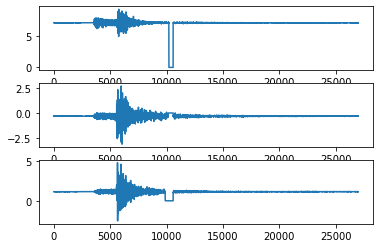

pgaZ:0.6290487908209484, pgaN:1.032320580922162, pgaE: 0.8419928709648635
pgvZ:0.02134766184171372, pgvN:0.03508338214760974, pgvE: 0.04395852079569421
station: ELD, distance: 177.0, intensity: 1, pga: 1.0677044458422553, pgv: 0.05558448296810687,  waveType: Velocity
original intensity: 1
original pga: 1.1
original pgv: 0.1


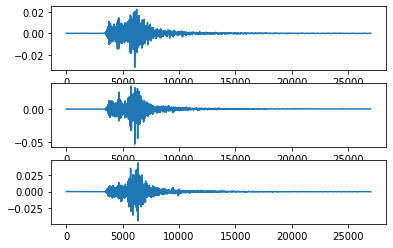

pgaZ:0.609017424336852, pgaN:0.993994236580444, pgaE: 0.8681570580898017
pgvZ:0.019668544032244842, pgvN:0.034017976095706795, pgvE: 0.0425819872427726
station: ELD, distance: 177.0, intensity: 1, pga: 1.0864051237995107, pgv: 0.05276790476390124,  waveType: Acceleration
original intensity: 1
original pga: 1.1
original pgv: 0.1


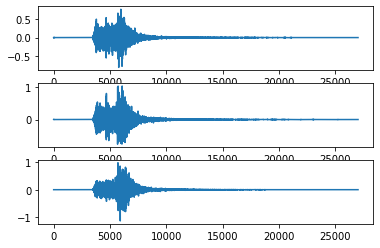

pgaZ:0.5883438889570838, pgaN:1.1149950411260936, pgaE: 0.8660862827167938
pgvZ:0.022532906590577346, pgvN:0.03371570870476334, pgvE: 0.03887206767414939
station: ELD, distance: 177.0, intensity: 1, pga: 1.140174650713598, pgv: 0.04542713906490655,  waveType: Velocity
original intensity: 1
original pga: 1.1
original pgv: 0.1


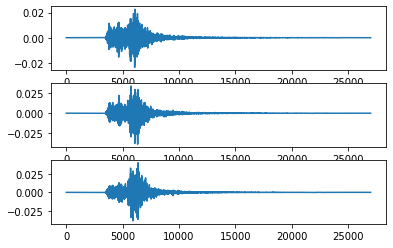

pgaZ:2.0912548664928456, pgaN:5.2613520646886105, pgaE: -0.00602523709409341
pgvZ:0.7609372532962452, pgvN:2.1420159162348282, pgvE: 0.5968310196507871
station: ELD, distance: 177.0, intensity: 2, pga: 5.64815507836582, pgv: 2.3603143018964508,  waveType: Acceleration
original intensity: 1
original pga: 1.1
original pgv: 0.1


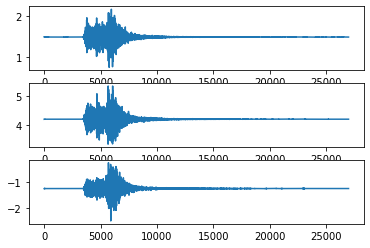

pgaZ:0.24307989763674698, pgaN:0.2525372445880367, pgaE: 0.2032359672883188
pgvZ:0.008803276586774142, pgvN:0.011628435056500493, pgvE: 0.014023664330182848
station: ELD, distance: 177.0, intensity: 0, pga: 0.2868490997739552, pgv: 0.017973587203226032,  waveType: Velocity
original intensity: 1
original pga: 1.1
original pgv: 0.1


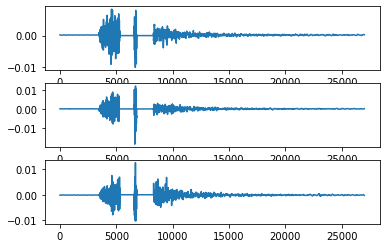

pgaZ:9.824256150459219, pgaN:5.153829220236341, pgaE: 2.6427407699491035
pgvZ:5.371762719695678, pgvN:2.837551554818747, pgvE: 20.533275831215946
station: ELD, distance: 177.0, intensity: 4, pga: 27.188258627525567, pgv: 22.538251369150075,  waveType: Acceleration
original intensity: 1
original pga: 1.1
original pgv: 0.1


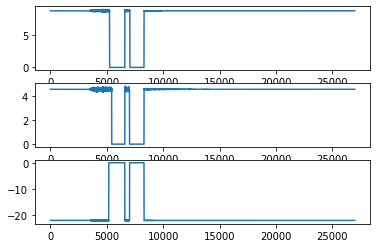

pgaZ:3.912134680859127, pgaN:0.12936183678401944, pgaE: 2.7511143142072996
pgvZ:2.5576568754416376, pgvN:0.883111659355351, pgvE: 1.8173662474144003
station: ELD, distance: 177.0, intensity: 2, pga: 4.778389070861753, pgv: 3.364622293379202,  waveType: Acceleration
original intensity: 1
original pga: 1.1
original pgv: 0.1


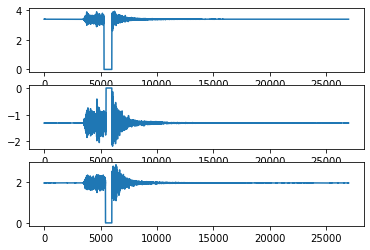

pgaZ:0.26888256606570404, pgaN:0.9144630455377981, pgaE: 0.958188159983011
pgvZ:0.015712325094710884, pgvN:0.048204032637249934, pgvE: 0.05350156822435317
station: RLNB, distance: 178.5, intensity: 1, pga: 1.2702431097995919, pgv: 0.07811325994311691,  waveType: Velocity


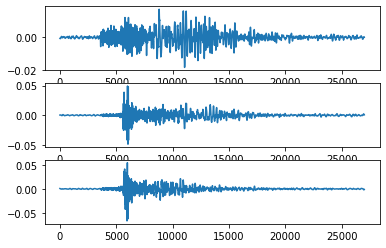

pgaZ:0.46271608912037443, pgaN:0.7221193708896254, pgaE: 0.8131494912292856
pgvZ:0.05049584353431856, pgvN:0.06781695474761903, pgvE: 0.05337772854291261
station: WCKO, distance: 184.1, intensity: 1, pga: 0.9048174806486824, pgv: 0.08370731984687009,  waveType: Velocity
original intensity: 3
original pga: 8.7
original pgv: 0.4


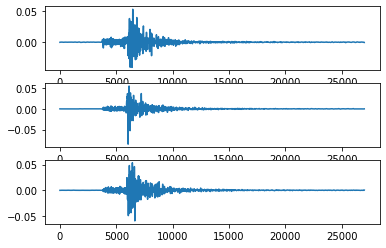

pgaZ:4.973764004127856, pgaN:44.24324441455249, pgaE: -0.0552034452336638
pgvZ:2.2628977998168587, pgvN:20.130920802199302, pgvE: 5.470994662658086
station: WCKO, distance: 184.1, intensity: 4, pga: 46.326574274528774, pgv: 21.07897457692624,  waveType: Acceleration
original intensity: 3
original pga: 8.7
original pgv: 0.4


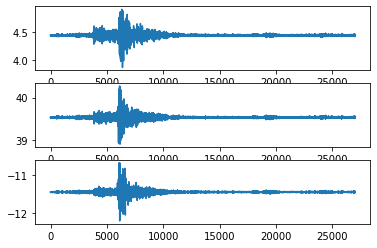

pgaZ:5.697105547476106, pgaN:0.655862792086008, pgaE: 0.9000728113275495
pgvZ:3.794652410717239, pgvN:3.841122685451003, pgvE: 4.208750030879148
station: WCKO, distance: 184.1, intensity: 3, pga: 12.857007910345175, pgv: 9.514154359656455,  waveType: Acceleration
original intensity: 3
original pga: 8.7
original pgv: 0.4


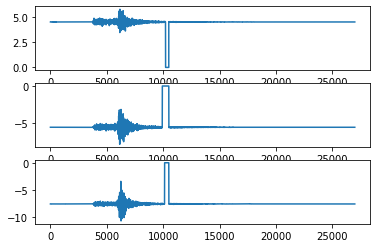

pgaZ:0.17767773679308851, pgaN:0.22032019056110463, pgaE: 0.26983398112949336
pgvZ:0.008338714071612243, pgvN:0.012144455475598866, pgvE: 0.01385015815029679
station: EDH, distance: 185.2, intensity: 0, pga: 0.29291684628382353, pgv: 0.01650634236784784,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


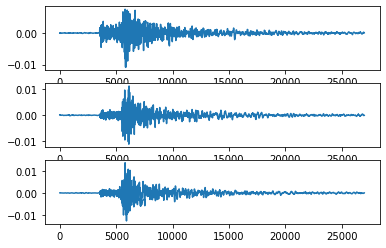

pgaZ:23.676323642511495, pgaN:18.451064126065027, pgaE: -0.007778133451789756
pgvZ:10.772640428491677, pgvN:8.395180995194696, pgvE: 0.7708219557389988
station: EDH, distance: 185.2, intensity: 4, pga: 30.071014783299574, pgv: 13.68221091781293,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


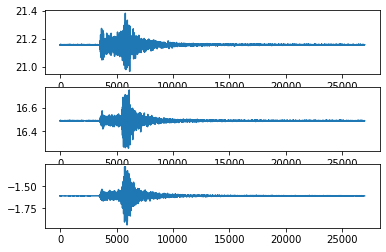

pgaZ:0.24644942465623387, pgaN:-0.028471462087928556, pgaE: 0.027742697154536214
pgvZ:0.479327949581988, pgvN:2.8293710474850915, pgvE: 0.8232524461024859
station: EDH, distance: 185.2, intensity: 2, pga: 7.981281541790457, pgv: 3.178754643653457,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


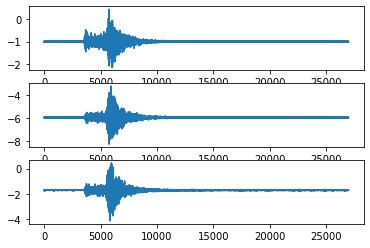

pgaZ:0.3836635794048917, pgaN:0.7281844590557713, pgaE: 0.7606565486474104
pgvZ:0.029323583160889725, pgvN:0.04575635580412506, pgvE: 0.038904337143892624
station: WTK, distance: 186.0, intensity: 1, pga: 1.0054510016024127, pgv: 0.05296030774899904,  waveType: Velocity
original intensity: 2
original pga: 4.5
original pgv: 0.2


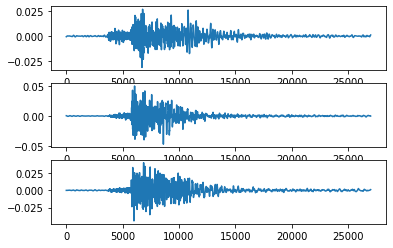

pgaZ:28.50717555341159, pgaN:18.52232805308763, pgaE: -0.020710551445438975
pgvZ:12.970757141831252, pgvN:8.427441589987255, pgvE: 2.0529605857031474
station: WTK, distance: 186.0, intensity: 4, pga: 34.33375807119408, pgv: 15.62179569685538,  waveType: Acceleration
original intensity: 2
original pga: 4.5
original pgv: 0.2


pgaZ:6.134608543510768, pgaN:-0.05572555275001134, pgaE: -0.04906157138927047
pgvZ:2.5473163547364535, pgvN:5.523368432522528, pgvE: 4.860144636789823
station: WTK, distance: 186.0, intensity: 3, pga: 19.76237465684519, pgv: 8.23883112654882,  waveType: Acceleration
original intensity: 2
original pga: 4.5
original pgv: 0.2


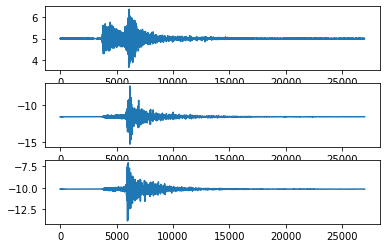

pgaZ:1.1295729839604978, pgaN:1.8344863665898148, pgaE: 1.8209388944626725
pgvZ:0.03314273523694168, pgvN:0.10762504070193687, pgvE: 0.07574400536533407
station: WTC, distance: 186.4, intensity: 1, pga: 2.317459699756087, pgv: 0.10866358134346413,  waveType: Velocity
original intensity: 1
original pga: 2.3
original pgv: 0.1


pgaZ:2.1671071093076075, pgaN:0.10567021536824807, pgaE: 1.6887218854577495
pgvZ:0.5114396254282946, pgvN:0.789996453382324, pgvE: 0.09539591801054453
station: WTC, distance: 186.4, intensity: 2, pga: 3.707340594041801, pgv: 0.9890093742041038,  waveType: Acceleration
original intensity: 1
original pga: 2.3
original pgv: 0.1


pgaZ:2.433978351749791, pgaN:0.3300130920600821, pgaE: 4.5009662270665585
pgvZ:0.43056267951138605, pgvN:1.1126393231917815, pgvE: 0.3560676255136741
station: CHN2, distance: 188.1, intensity: 2, pga: 7.179103790475718, pgv: 1.3102080391758826,  waveType: Acceleration
original intensity: 2
original pga: 5.0
original pgv: 0.3


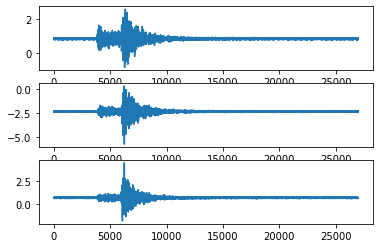

pgaZ:1.6336020896153092, pgaN:3.380511171940703, pgaE: 3.1009746950679027
pgvZ:0.08331965113072871, pgvN:0.17243485795063254, pgvE: 0.2358484195983687
station: CHN2, distance: 188.1, intensity: 2, pga: 4.390878100340836, pgv: 0.2898055346001317,  waveType: Velocity
original intensity: 2
original pga: 5.0
original pgv: 0.3


pgaZ:1.6416739684080806, pgaN:4.151835893950827, pgaE: 3.6096302606395967
pgvZ:0.1973538547270169, pgvN:0.2607893992580089, pgvE: 0.37725742940153917
station: CHN4, distance: 191.4, intensity: 2, pga: 4.584334601990666, pgv: 0.4824408211442743,  waveType: Velocity
original intensity: 1
original pga: 2.2
original pgv: 0.2


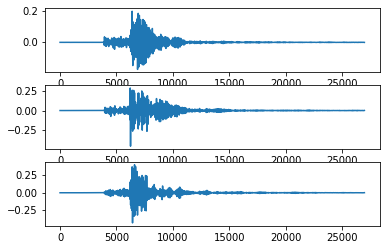

pgaZ:2.475566528620981, pgaN:11.700663001920208, pgaE: 2.3388084321070264
pgvZ:0.8292084499003585, pgvN:5.18297968430781, pgvE: 0.3738083013320093
station: CHN4, distance: 191.4, intensity: 3, pga: 11.965651550887793, pgv: 5.262185639777294,  waveType: Acceleration
original intensity: 1
original pga: 2.2
original pgv: 0.2


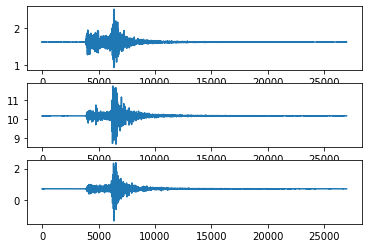

pgaZ:0.35782100714374626, pgaN:0.6973863345409713, pgaE: 0.6221266379177506
pgvZ:0.023678289139740634, pgvN:0.026618353446943927, pgvE: 0.028959083118593448
station: TPUB, distance: 192.7, intensity: 0, pga: 0.728284890086435, pgv: 0.03574712787614345,  waveType: Velocity


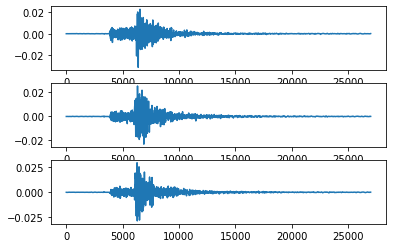

pgaZ:0.2008744502443216, pgaN:0.26039467733158134, pgaE: 0.24600011972984692
pgvZ:0.02179903077694649, pgvN:0.015472976601517986, pgvE: 0.019262538796738435
station: STYH, distance: 193.4, intensity: 0, pga: 0.29576902257010984, pgv: 0.023876631085904657,  waveType: Velocity
original intensity: 1
original pga: 1.9
original pgv: 0.1


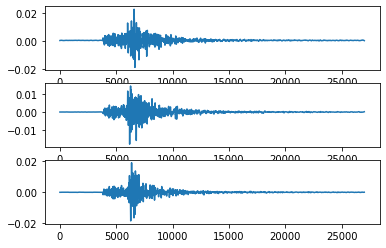

pgaZ:30.932344711864776, pgaN:-0.019758028943956195, pgaE: -0.40036609635540904
pgvZ:14.073677077957301, pgvN:1.959872529278214, pgvE: 39.678836459346485
station: STYH, distance: 193.4, intensity: 5 strong, pga: 97.9949880863294, pgv: 44.58837504096652,  waveType: Acceleration
original intensity: 1
original pga: 1.9
original pgv: 0.1


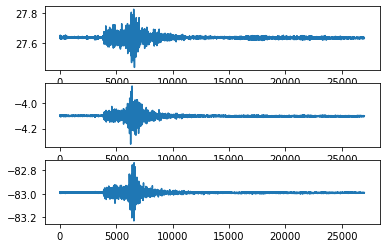

pgaZ:2.265254395026056, pgaN:0.11154164044004143, pgaE: 4.081343343448684
pgvZ:0.9702795378665661, pgvN:0.6237444752820024, pgvE: 1.6549270761548724
station: STYH, distance: 193.4, intensity: 2, pga: 4.783226439720231, pgv: 1.9770909893764637,  waveType: Acceleration
original intensity: 1
original pga: 1.9
original pgv: 0.1


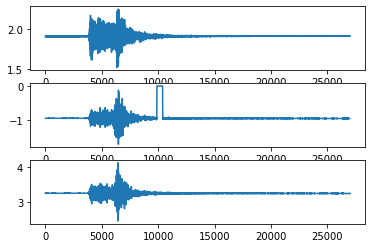

pgaZ:1.8600835246757572, pgaN:8.572633899750816, pgaE: -0.02050143656785438
pgvZ:0.5690292574845187, pgvN:3.325297358075576, pgvE: 2.029225098012089
station: CHY, distance: 193.9, intensity: 3, pga: 10.217527551384558, pgv: 4.006242480135264,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.2


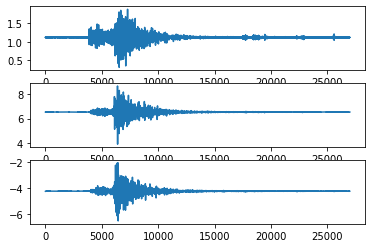

pgaZ:16.068145889058076, pgaN:8.204331785827353, pgaE: 11.292414620540704
pgvZ:12.430007754339087, pgvN:7.17940863449673, pgvE: 9.571307890882169
station: CHY, distance: 193.9, intensity: 3, pga: 21.276289286128375, pgv: 17.010123219457444,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.2


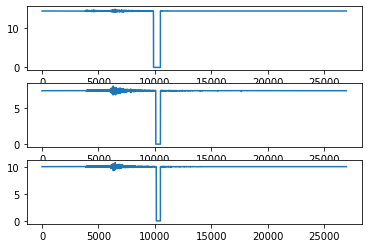

pgaZ:0.38109333386867744, pgaN:0.5829837312566426, pgaE: 0.7028088912233365
pgvZ:0.018754773194607742, pgvN:0.02931355172005434, pgvE: 0.05474351424786375
station: CHY, distance: 193.9, intensity: 1, pga: 0.8036314144484872, pgv: 0.06227429779937085,  waveType: Velocity
original intensity: 2
original pga: 2.8
original pgv: 0.2


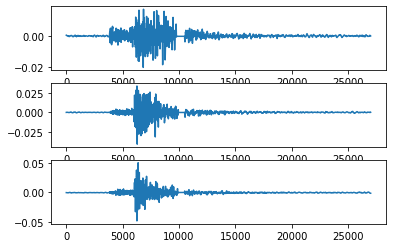

pgaZ:0.6910938134809372, pgaN:-0.06029701179610889, pgaE: -0.09515135966875016
pgvZ:0.05372762357896728, pgvN:5.977335481543236, pgvE: 9.428286432314003
station: CHY, distance: 193.9, intensity: 4, pga: 26.130243837437696, pgv: 11.888895336784303,  waveType: Acceleration
original intensity: 2
original pga: 2.8
original pgv: 0.2


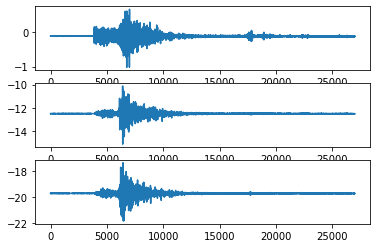

pgaZ:-0.028992977995050136, pgaN:3.5208251063553933, pgaE: 6.708653657970998
pgvZ:2.873392100601457, pgvN:1.355415061023455, pgvE: 3.027485512000254
station: STY, distance: 194.9, intensity: 3, pga: 9.918787959980975, pgv: 4.513016526466964,  waveType: Acceleration
original intensity: 1
original pga: 0.9


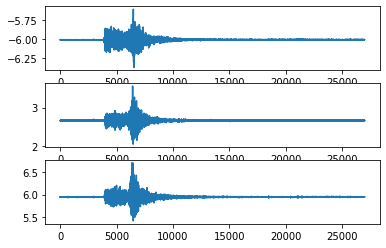

pgaZ:0.3466715556790196, pgaN:0.7955831133454411, pgaE: 0.6040970960694687
pgvZ:0.016495823349749146, pgvN:0.03684893529165721, pgvE: 0.03552495886978203
station: STY, distance: 194.9, intensity: 1, pga: 0.8860515851139057, pgv: 0.039333587226603225,  waveType: Velocity
original intensity: 1
original pga: 0.9


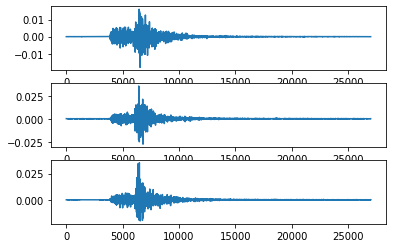

pgaZ:4.46225644120867, pgaN:-0.017554195375158652, pgaE: 1.3849767174871292
pgvZ:1.5580075563095683, pgvN:1.9920129281772985, pgvE: 0.595345914605135
station: WML, distance: 195.1, intensity: 2, pga: 6.6099018742043505, pgv: 2.7050714315743507,  waveType: Acceleration
original intensity: 2
original pga: 2.6
original pgv: 0.1


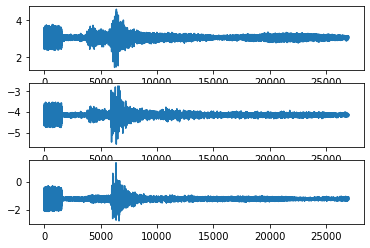

pgaZ:8.14797495958601, pgaN:11.035133830158745, pgaE: 10.330424770891728
pgvZ:3.707170691895666, pgvN:5.021004313724891, pgvE: 4.700446184032993
station: WTP, distance: 197.7, intensity: 3, pga: 17.172109670585268, pgv: 7.813308722064199,  waveType: Acceleration
original intensity: 0
original pga: 0.5


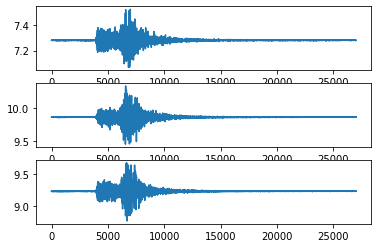

pgaZ:0.2695310831579766, pgaN:0.41761605032190746, pgaE: 0.4417004529665578
pgvZ:0.021275964408077358, pgvN:0.024891573479655493, pgvE: 0.024480439530648355
station: WTP, distance: 197.7, intensity: 0, pga: 0.5124671083086086, pgv: 0.02708241533787765,  waveType: Velocity
original intensity: 0
original pga: 0.5


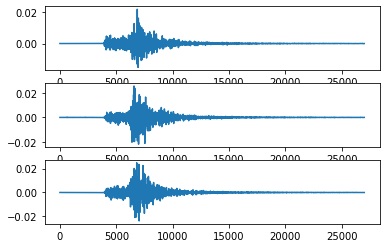

pgaZ:0.0954971953859868, pgaN:0.1896645044216938, pgaE: 0.16022847330257975
pgvZ:0.01179097183930691, pgvN:0.011015512787312448, pgvE: 0.008123387800603217
station: LONT, distance: 198.9, intensity: 0, pga: 0.19723389449731574, pgv: 0.01238331908113499,  waveType: Velocity
original intensity: 0
original pga: 0.6


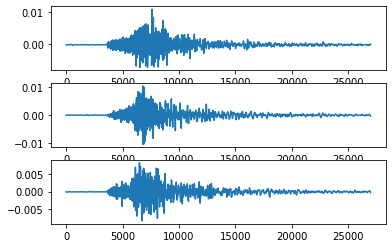

pgaZ:1.5924568572417794, pgaN:-0.009512782550873912, pgaE: 1.5892735201454389
pgvZ:0.7246159986589317, pgvN:0.9428550044615587, pgvE: 0.722944157104867
station: LONT, distance: 198.9, intensity: 2, pga: 3.151544941462459, pgv: 1.4337960079485397,  waveType: Acceleration
original intensity: 0
original pga: 0.6


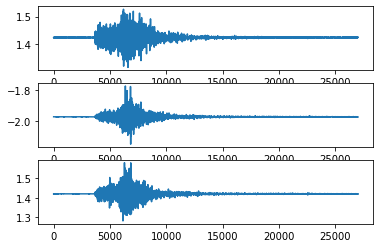

pgaZ:5.432992349789741, pgaN:0.634374256106156, pgaE: 7.091895974267511
pgvZ:4.6588079637548665, pgvN:3.5178596070366126, pgvE: 5.210804523336597
station: LONT, distance: 198.9, intensity: 3, pga: 10.71162919257322, pgv: 8.659333443863387,  waveType: Acceleration
original intensity: 0
original pga: 0.6


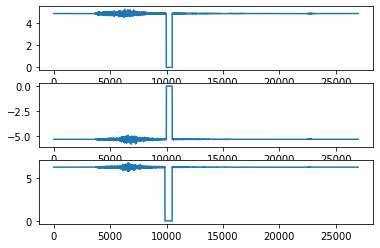

pgaZ:1.2073891904482918, pgaN:4.061875680809175, pgaE: 2.9046716234649383
pgvZ:0.044345757922370686, pgvN:0.1382614078060504, pgvE: 0.10988632737717446
station: WSF, distance: 202.9, intensity: 2, pga: 4.127762816418889, pgv: 0.16208796080589166,  waveType: Velocity
original intensity: 2
original pga: 4.0
original pgv: 0.2


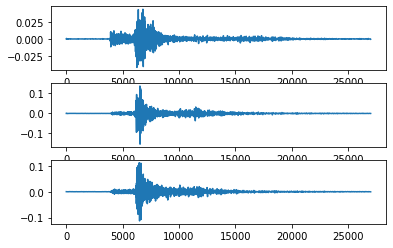

pgaZ:-0.007120871377354597, pgaN:7.205034415050325, pgaE: 1.2870046362831264
pgvZ:0.7146382801030728, pgvN:1.7161134645233127, pgvE: 0.8780940019762578
station: WSF, distance: 202.9, intensity: 2, pga: 7.836401335149649, pgv: 2.0964065115338273,  waveType: Acceleration
original intensity: 2
original pga: 4.0
original pgv: 0.2


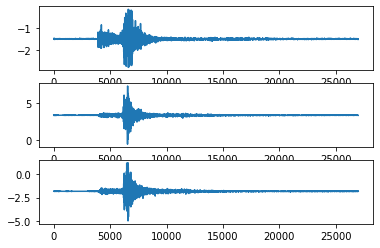

pgaZ:-0.0019387767152358442, pgaN:0.7411276577638891, pgaE: 1.841968184089687
pgvZ:0.19225704484415806, pgvN:0.17402601289769126, pgvE: 0.6977616968872166
station: TWL, distance: 204.9, intensity: 1, pga: 1.9665175625843245, pgv: 0.7478138699710348,  waveType: Acceleration
original intensity: 0
original pga: 0.5
original pgv: 0.1


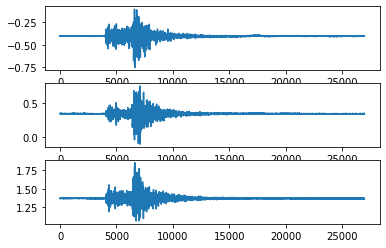

pgaZ:0.2807456670289621, pgaN:0.43726217832965913, pgaE: 0.45335469935656764
pgvZ:0.021175342055557846, pgvN:0.02958420511863006, pgvE: 0.024986735250847155
station: TWL, distance: 204.9, intensity: 0, pga: 0.6576785727252299, pgv: 0.03522024169034506,  waveType: Velocity
original intensity: 0
original pga: 0.5
original pgv: 0.1


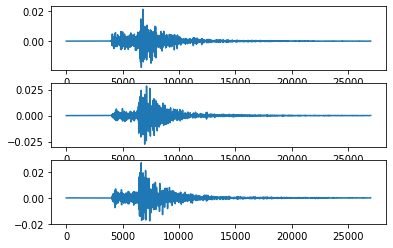

pgaZ:3.771319974427687, pgaN:0.14434261734957202, pgaE: 0.1680563882552642
pgvZ:0.21316349970231302, pgvN:0.014519108109789838, pgvE: 0.020972815875494762
station: SNS, distance: 208.6, intensity: 2, pga: 3.845047549885465, pgv: 0.2132080323218752,  waveType: Velocity
original intensity: 0
original pga: 0.7


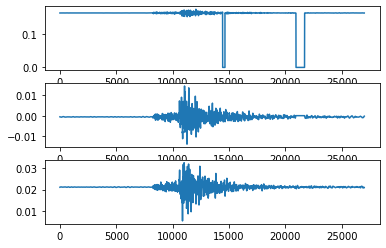

pgaZ:2.5601073440548103, pgaN:3.9813694070872216, pgaE: 5.186877509169028
pgvZ:2.000356943602373, pgvN:2.8776218914072507, pgvE: 3.706449497259908
station: SNS, distance: 208.6, intensity: 2, pga: 7.005130251205226, pgv: 4.743309704644238,  waveType: Acceleration
original intensity: 0
original pga: 0.7


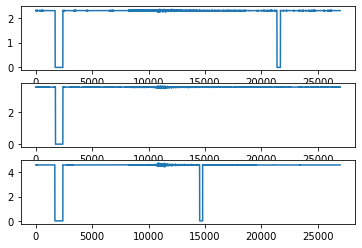

pgaZ:0.989821416018801, pgaN:-0.0077746449208643586, pgaE: 6.311485610821019
pgvZ:0.37201418731143426, pgvN:0.7708393478095681, pgvE: 2.8721113753942142
station: SNS, distance: 208.6, intensity: 2, pga: 6.614659086514666, pgv: 3.0102148734973646,  waveType: Acceleration
original intensity: 0
original pga: 0.7


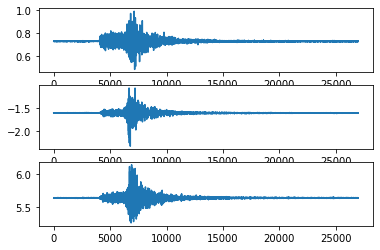

pgaZ:0.3986604895461327, pgaN:0.6939385309000273, pgaE: 0.4294484538059342
pgvZ:0.018808749816044582, pgvN:0.03814372099143601, pgvE: 0.02340787213358477
station: CHN1, distance: 209.0, intensity: 0, pga: 0.7935831077937638, pgv: 0.04567070189436259,  waveType: Velocity
original intensity: 1
original pga: 0.8
original pgv: 0.1


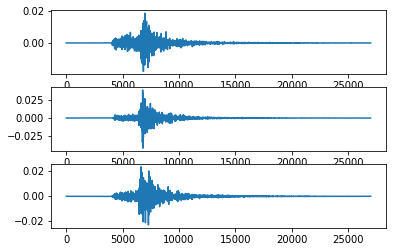

pgaZ:-0.02979103259643791, pgaN:-0.010146264809734252, pgaE: -0.01017331750808638
pgvZ:2.95436018074167, pgvN:1.0072536268021253, pgvE: 1.0091791521279119
station: CHN1, distance: 209.0, intensity: 2, pga: 7.675571161965038, pgv: 3.492972175758984,  waveType: Acceleration
original intensity: 1
original pga: 0.8
original pgv: 0.1


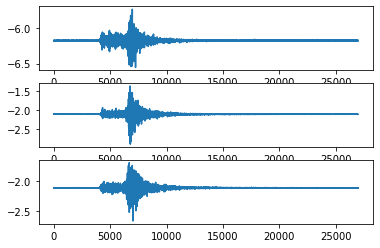

pgaZ:0.270274492093223, pgaN:0.49878882324586304, pgaE: 0.5808400599235404
pgvZ:0.018797703553698347, pgvN:0.04909301481029017, pgvE: 0.036273382583491214
station: WSL, distance: 209.5, intensity: 0, pga: 0.6448230641212491, pgv: 0.050367709553110374,  waveType: Velocity
original intensity: 2
original pga: 5.9
original pgv: 0.4


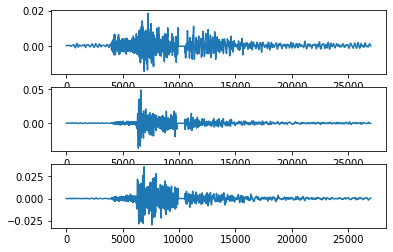

pgaZ:24.39049093801372, pgaN:3.2832678512852906, pgaE: 3.051928488620447
pgvZ:18.56993785465491, pgvN:14.054306366942404, pgvE: 17.28536037208429
station: WSL, distance: 209.5, intensity: 4, pga: 48.695291536380616, pgv: 38.631123123765846,  waveType: Acceleration
original intensity: 2
original pga: 5.9
original pgv: 0.4


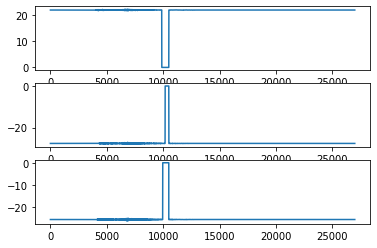

pgaZ:-0.005006252122829921, pgaN:-0.03410142920054365, pgaE: 7.313482744744411
pgvZ:0.49729443272997764, pgvN:3.3807405743490744, pgvE: 2.335444745765007
station: WSL, distance: 209.5, intensity: 3, pga: 9.728988712111631, pgv: 4.3235597869533064,  waveType: Acceleration
original intensity: 2
original pga: 5.9
original pgv: 0.4


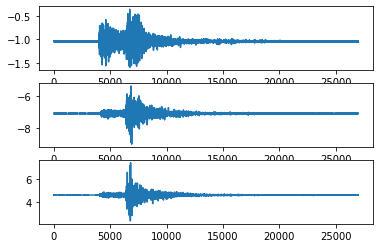

pgaZ:0.36681632057075664, pgaN:0.37003940823499665, pgaE: 0.3101841164836615
pgvZ:0.01573144002266841, pgvN:0.018281445676664048, pgvE: 0.018484845523480717
station: TWG, distance: 210.0, intensity: 0, pga: 0.4970736730692535, pgv: 0.02307882977847481,  waveType: Velocity
original intensity: 0
original pga: 0.5


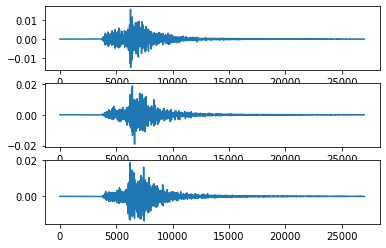

pgaZ:1.3262487809742782, pgaN:2.932217623048385, pgaE: 2.2248162386273473
pgvZ:0.5371932554163288, pgvN:1.2784181501969334, pgvE: 0.9700722746161071
station: TWG, distance: 210.0, intensity: 2, pga: 3.7640343802958167, pgv: 1.6923267351184315,  waveType: Acceleration
original intensity: 0
original pga: 0.5


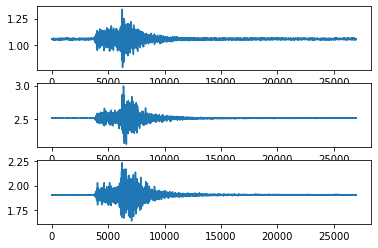

pgaZ:0.35564530544593803, pgaN:0.425037204801506, pgaE: 0.31737447433730404
pgvZ:0.01449785239603865, pgvN:0.022688670373770013, pgvE: 0.017356056301788724
station: TWGB, distance: 210.0, intensity: 0, pga: 0.4798054284225044, pgv: 0.025984078062188186,  waveType: Velocity


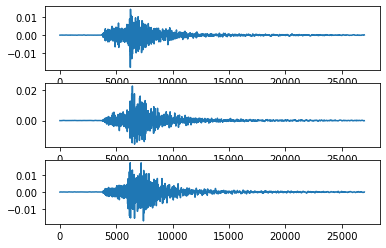

pgaZ:0.1374469320086567, pgaN:0.23740079167183367, pgaE: 0.26921430818488673
pgvZ:0.007160972119186156, pgvN:0.012213147553671984, pgvE: 0.016739773234242746
station: LDU, distance: 211.6, intensity: 0, pga: 0.2862143356168227, pgv: 0.017038240087232853,  waveType: Velocity
original intensity: 1
original pga: 0.9


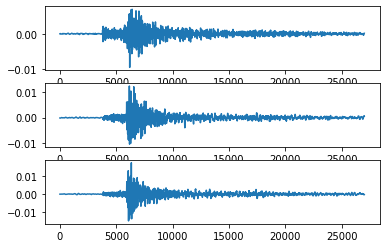

pgaZ:45.76095752952304, pgaN:-0.12622074160606833, pgaE: -0.05145358397048716
pgvZ:20.821390819397216, pgvN:12.508790072815941, pgvE: 5.099085393973915
station: LDU, distance: 211.6, intensity: 4, pga: 55.6219771340295, pgv: 25.30782426979139,  waveType: Acceleration
original intensity: 1
original pga: 0.9


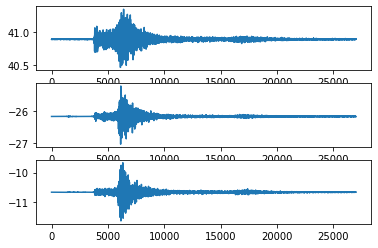

pgaZ:2.1949266680969477, pgaN:0.5257442827576264, pgaE: 6.254848261101116
pgvZ:1.590484229258129, pgvN:3.1202940013506586, pgvE: 3.9041740226974753
station: LDU, distance: 211.6, intensity: 3, pga: 8.088326972193215, pgv: 5.547817580342109,  waveType: Acceleration
original intensity: 1
original pga: 0.9


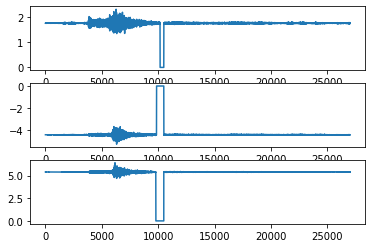

pgaZ:0.19298394815955663, pgaN:0.4793721152266719, pgaE: 0.41110934024929346
pgvZ:0.01161223558467325, pgvN:0.033157044627048056, pgvE: 0.02596499706861102
station: SGS, distance: 213.2, intensity: 0, pga: 0.6367251887961074, pgv: 0.03370426619659534,  waveType: Velocity
original intensity: 0
original pga: 0.5


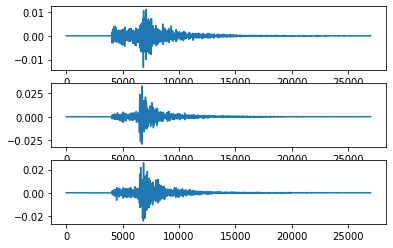

pgaZ:2.5658021088003773, pgaN:4.0520494793045705, pgaE: -0.011542484630241306
pgvZ:1.1667897801281972, pgvN:1.8203534418915412, pgvE: 1.143907421168079
station: SGS, distance: 213.2, intensity: 2, pga: 5.4546822280462175, pgv: 2.48157107072464,  waveType: Acceleration
original intensity: 0
original pga: 0.5


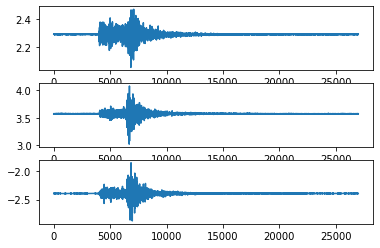

pgaZ:14.676925202919078, pgaN:-0.06097803467820603, pgaE: 4.861873633295332
pgvZ:6.679171871714445, pgvN:6.045131741548085, pgvE: 1.8137233586361883
station: ICHU, distance: 215.4, intensity: 3, pga: 20.76987038397176, pgv: 9.451737409138314,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


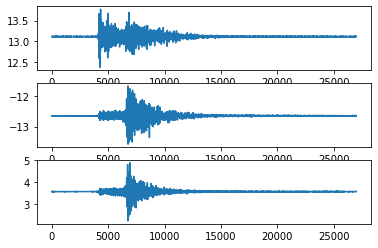

pgaZ:0.16647811445301247, pgaN:0.2717049984394363, pgaE: 0.3475331274361564
pgvZ:0.008556036106526539, pgvN:0.01906483612422569, pgvE: 0.0175880372347257
station: ICHU, distance: 215.4, intensity: 0, pga: 0.43541029394248526, pgv: 0.027047175943141055,  waveType: Velocity
original intensity: 1
original pga: 2.4
original pgv: 0.1


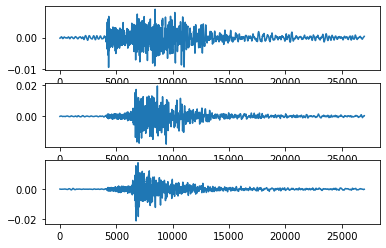

pgaZ:-0.02522213243030073, pgaN:-0.08456974090412478, pgaE: 3.4686093050498745
pgvZ:2.4999184262098515, pgvN:8.382338351981316, pgvE: 0.9162592528941538
station: ICHU, distance: 215.4, intensity: 3, pga: 20.57035322683696, pgv: 9.360247018692036,  waveType: Acceleration
original intensity: 1
original pga: 2.4
original pgv: 0.1


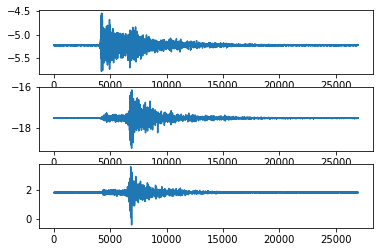

pgaZ:1.2346485174777448, pgaN:-0.002551971211217414, pgaE: 1.4062610687019697
pgvZ:0.5313648426419725, pgvN:0.25255988192957, pgvE: 0.4527576219131823
station: SLG, distance: 217.0, intensity: 1, pga: 1.8685264947813491, pgv: 0.7480407006992834,  waveType: Acceleration
original intensity: 0
original pga: 0.6


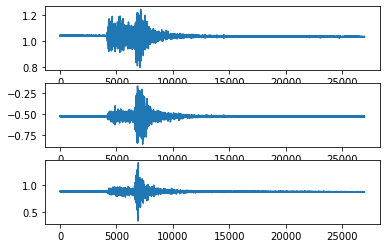

pgaZ:0.8862640191390332, pgaN:3.820630987041037, pgaE: 2.7304468828461066
pgvZ:0.1015239081228214, pgvN:0.38892391649773533, pgvE: 0.29811487924089664
station: CHN8, distance: 220.9, intensity: 2, pga: 3.8370156045767394, pgv: 0.39897694286195035,  waveType: Velocity
original intensity: 1
original pga: 1.5
original pgv: 0.1


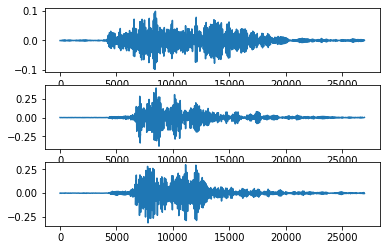

pgaZ:0.6015975214850605, pgaN:5.724629434973939, pgaE: -0.01862578281544017
pgvZ:0.11720880717102489, pgvN:2.179308406844274, pgvE: 1.8460985677377586
station: CHN8, distance: 220.9, intensity: 2, pga: 7.103645640329357, pgv: 2.936643530780422,  waveType: Acceleration
original intensity: 1
original pga: 1.5
original pgv: 0.1


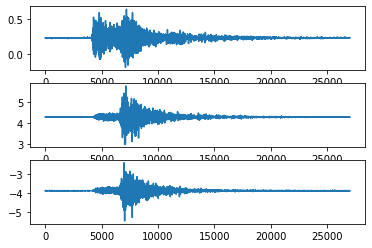

pgaZ:5.243101869408398, pgaN:2.188518933469849, pgaE: -0.008877793842556691
pgvZ:2.3857423113994454, pgvN:0.7725324213577817, pgvE: 0.887872048081985
station: CHN3, distance: 229.5, intensity: 2, pga: 5.890340330846104, pgv: 2.6800511771995366,  waveType: Acceleration
original intensity: 1
original pga: 0.9
original pgv: 0.1


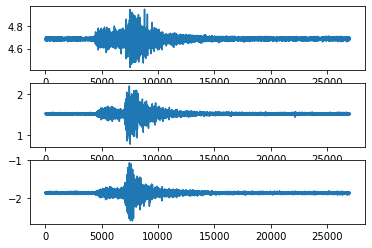

pgaZ:0.27777710147689544, pgaN:0.7231185583552423, pgaE: 0.7027535492980618
pgvZ:0.015422320037580853, pgvN:0.038861486674340535, pgvE: 0.04942927430356713
station: CHN3, distance: 229.5, intensity: 1, pga: 0.9279266611391688, pgv: 0.05905034200071509,  waveType: Velocity
original intensity: 1
original pga: 0.9
original pgv: 0.1


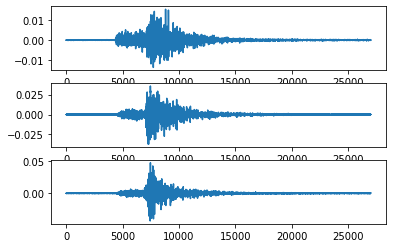

pgaZ:5.58466686858775, pgaN:3.4486887547002287, pgaE: -0.033465690789268636
pgvZ:2.54160098607875, pgvN:1.4055048991643009, pgvE: 3.3197630913615397
station: SSH, distance: 230.5, intensity: 3, pga: 10.051774585184095, pgv: 4.575500736711651,  waveType: Acceleration
original intensity: 0
original pga: 0.8
original pgv: 0.1


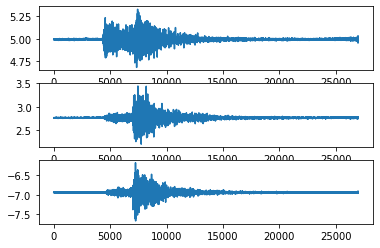

pgaZ:0.39447595984662376, pgaN:1.042578866317566, pgaE: 1.1347152448157307
pgvZ:0.01437920712247772, pgvN:0.05982986091303668, pgvE: 0.060414574163506075
station: SCL, distance: 234.5, intensity: 1, pga: 1.1902752482569952, pgv: 0.07673823247938216,  waveType: Velocity
original intensity: 1
original pga: 1.4
original pgv: 0.1


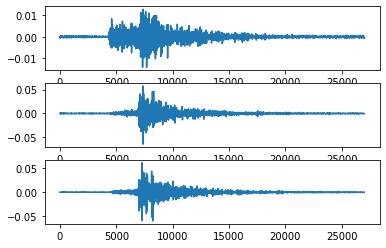

pgaZ:2.1769278207399023, pgaN:7.339373231113013, pgaE: -0.010461879623842412
pgvZ:0.91049679196154, pgvN:3.1643639632110223, pgvE: 1.034778891424252
station: SCL, distance: 234.5, intensity: 2, pga: 7.828758709701479, pgv: 3.471961042977126,  waveType: Acceleration
original intensity: 1
original pga: 1.4
original pgv: 0.1


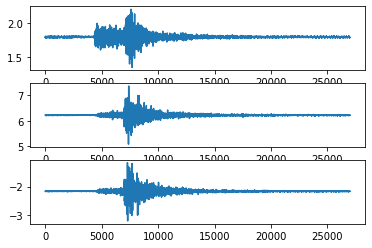

pgaZ:0.00010490532495326468, pgaN:1.8599970199854235e-05, pgaE: 2.3288626986262694e-05
pgvZ:3.917433799104131e-05, pgvN:2.510383986235431e-05, pgvE: 5.343637517699599e-06
station: SHH, distance: 234.9, intensity: 0, pga: 0.00010563949303051932, pgv: 8.046465969841575e-05,  waveType: Velocity
original intensity: 1
original pga: 1.4
original pgv: 0.1


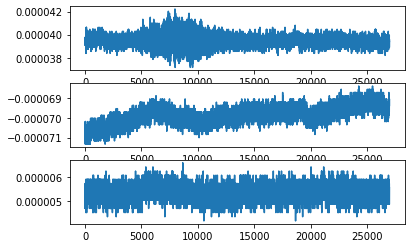

pgaZ:-5.914249360404763e-05, pgaN:-0.0006815070049530969, pgaE: -0.0013009527403272942
pgvZ:0.006056551114191868, pgvN:0.06749763139782244, pgvE: 0.1301093383515129
station: SHH, distance: 234.9, intensity: 0, pga: 0.34144712186188614, pgv: 0.1557108014367854,  waveType: Acceleration
original intensity: 1
original pga: 1.4
original pgv: 0.1


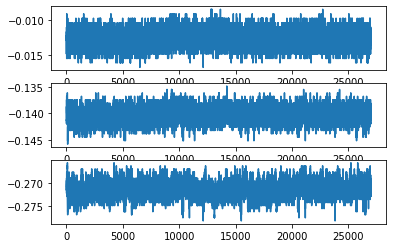

pgaZ:3.9234591024886454, pgaN:1.8737470810555066, pgaE: -0.010011001317973613
pgvZ:1.7849174283281277, pgvN:0.6774764500487868, pgvE: 0.9920882014563666
station: SHH, distance: 234.9, intensity: 2, pga: 4.796345748894448, pgv: 2.1820834227873225,  waveType: Acceleration
original intensity: 1
original pga: 1.4
original pgv: 0.1


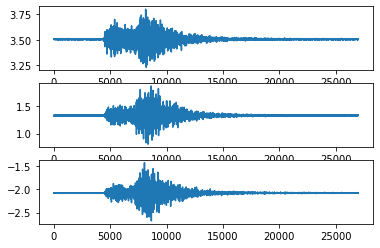

pgaZ:0.04880198704701705, pgaN:0.041110707111299195, pgaE: 0.05837451026297778
pgvZ:0.005784431422373776, pgvN:0.00511726291770922, pgvE: 0.006373979642341383
station: SCS, distance: 236.1, intensity: 0, pga: 0.06549737521228931, pgv: 0.007494796556737139,  waveType: Velocity
original intensity: 1
original pga: 0.8
original pgv: 0.1


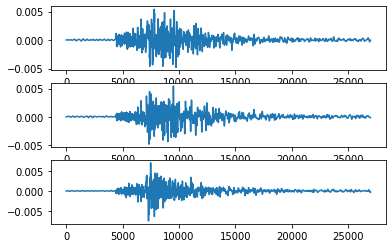

pgaZ:20.01565642173657, pgaN:16.846571189572245, pgaE: 5.392329636538659
pgvZ:9.107166628592527, pgvN:7.665335622682096, pgvE: 2.4535617726111543
station: SCS, distance: 236.1, intensity: 4, pga: 26.711620724834784, pgv: 12.153921983513275,  waveType: Acceleration
original intensity: 1
original pga: 0.8
original pgv: 0.1


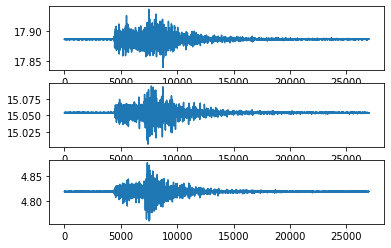

pgaZ:-0.003785874841611699, pgaN:-0.0036701494097720402, pgaE: -0.02351630950643043
pgvZ:0.37485500297928875, pgvN:0.3640199719183771, pgvE: 2.3300668323046256
station: SCS, distance: 236.1, intensity: 2, pga: 5.589428119949552, pgv: 2.5432237824246697,  waveType: Acceleration
original intensity: 1
original pga: 0.8
original pgv: 0.1


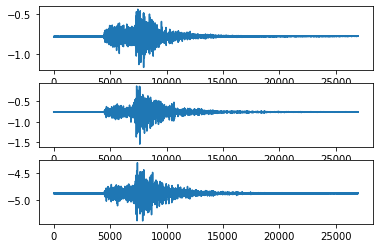

pgaZ:0.20516782630167021, pgaN:0.28770912398954596, pgaE: 0.0018373707227932366
pgvZ:0.006436680414413391, pgvN:0.012305611053563082, pgvE: 5.574911426350176e-05
station: ECL, distance: 237.4, intensity: 0, pga: 0.29753108494948954, pgv: 0.01534585305063321,  waveType: Velocity
original intensity: 0
original pga: 0.3


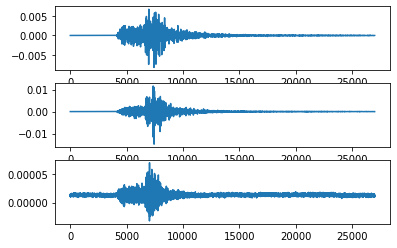

pgaZ:2.6801217936264012, pgaN:-0.014372497463411146, pgaE: -0.006228132331734371
pgvZ:1.219393785685497, pgvN:1.4242856436147209, pgvE: 0.6168277922957626
station: ECL, distance: 237.4, intensity: 2, pga: 4.514740014274559, pgv: 2.054110475331824,  waveType: Acceleration
original intensity: 0
original pga: 0.3


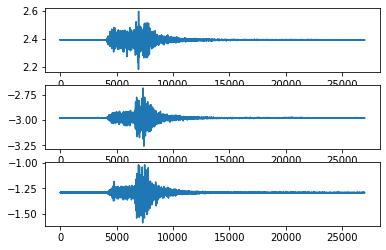

pgaZ:0.5959597690446939, pgaN:0.8024254681817553, pgaE: 0.7524637728466025
pgvZ:0.040533414359133234, pgvN:0.07335295954136492, pgvE: 0.05469737944546208
station: SSD, distance: 239.6, intensity: 1, pga: 1.0278311836257732, pgv: 0.08191549104578345,  waveType: Velocity
original intensity: 0
original pga: 0.5


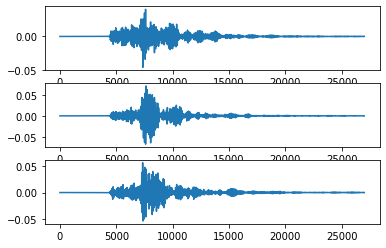

pgaZ:-0.002018431882605999, pgaN:1.9336267006003172, pgaE: 3.6496660409460384
pgvZ:0.20024647383790511, pgvN:0.8259666211548694, pgvE: 1.6505937861748115
station: SSD, distance: 239.6, intensity: 2, pga: 4.083128162972287, pgv: 1.8579902349215431,  waveType: Acceleration
original intensity: 0
original pga: 0.5


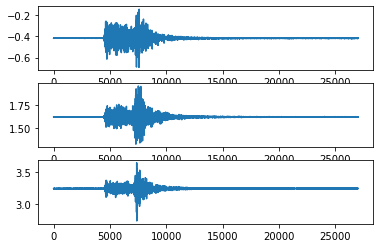

pgaZ:0.0, pgaN:0.0, pgaE: 0.0
pgvZ:0.0, pgvN:0.0, pgvE: 0.0
station: TAI1, distance: 241.8, intensity: 0, pga: 0.0, pgv: 0.0,  waveType: Velocity
original intensity: 0
original pga: 0.7
original pgv: 0.1


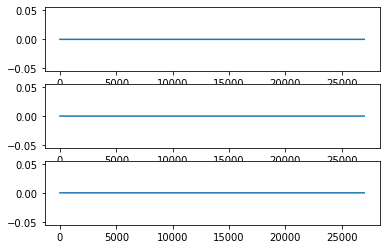

pgaZ:-0.020793004538982873, pgaN:-0.009531567386066453, pgaE: -0.024386504636757216
pgvZ:2.0564418038854506, pgvN:0.9490892854015887, pgvE: 2.419765968047999
station: TAI1, distance: 241.8, intensity: 2, pga: 7.757218039596996, pgv: 3.528987347055674,  waveType: Acceleration
original intensity: 0
original pga: 0.7
original pgv: 0.1


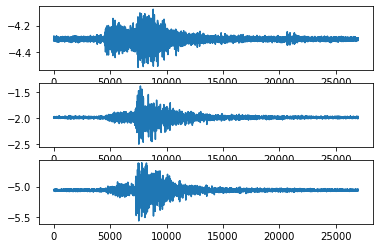

pgaZ:0.08949846417132513, pgaN:0.08845172756640131, pgaE: 0.09478553596541402
pgvZ:0.0073551242577425974, pgvN:0.007467471599502913, pgvE: 0.007750427881924414
station: SMG, distance: 242.9, intensity: 0, pga: 0.1221332025382554, pgv: 0.008931596163360516,  waveType: Velocity
original intensity: 0
original pga: 0.3


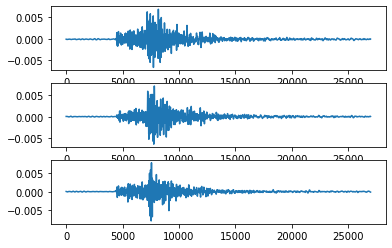

pgaZ:2.2872861312098602, pgaN:1.255867949185026, pgaE: -0.0033557833286985907
pgvZ:1.0407523915142358, pgvN:0.5714205272742925, pgvE: 0.33251656187474
station: SMG, distance: 242.9, intensity: 2, pga: 2.722963863752028, pgv: 1.2389742502693486,  waveType: Acceleration
original intensity: 0
original pga: 0.3


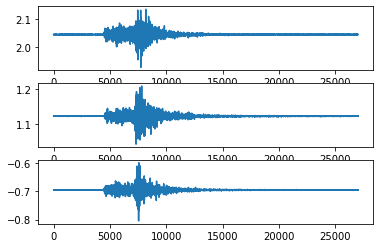

pgaZ:5.8302831459710625, pgaN:2.942713146368357, pgaE: 3.0726997005102237
pgvZ:2.653143509371612, pgvN:1.3394400568341311, pgvE: 1.3983513662272935
station: SMG, distance: 242.9, intensity: 2, pga: 7.217565079271472, pgv: 3.284609062065419,  waveType: Acceleration
original intensity: 0
original pga: 0.3


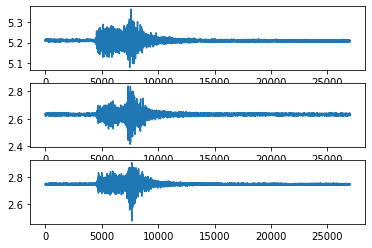

pgaZ:0.09348652158102808, pgaN:0.2716642375896674, pgaE: 0.22106068251552202
pgvZ:0.006033534563568899, pgvN:0.02045721866535516, pgvE: 0.011444746656505822
station: SCK, distance: 245.5, intensity: 0, pga: 0.36912903477014886, pgv: 0.020726997498781652,  waveType: Velocity
original intensity: 2
original pga: 3.0
original pgv: 0.1


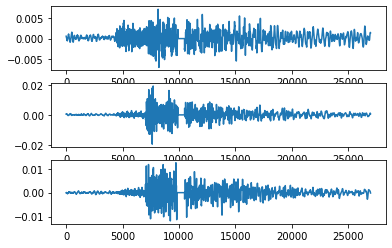

pgaZ:35.667998237482834, pgaN:2.108009116684772, pgaE: 71.10260256987408
pgvZ:16.22574589708232, pgvN:9.025150566206143, pgvE: 307.6338285807379
station: SCK, distance: 245.5, intensity: 7, pga: 669.5041631063509, pgv: 549.1444510379054,  waveType: Acceleration
original intensity: 2
original pga: 3.0
original pgv: 0.1


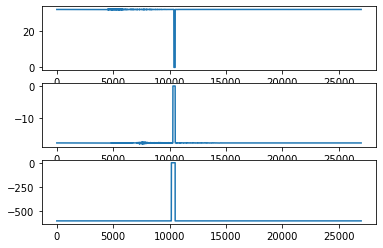

pgaZ:1.9273841837923404, pgaN:0.18947395328422958, pgaE: 1.1272110559731348
pgvZ:1.4671224050882028, pgvN:1.0700215502051709, pgvE: 0.05029250039593294
station: SCK, distance: 245.5, intensity: 2, pga: 3.2170658896156383, pgv: 1.8242048622136664,  waveType: Acceleration
original intensity: 2
original pga: 3.0
original pgv: 0.1


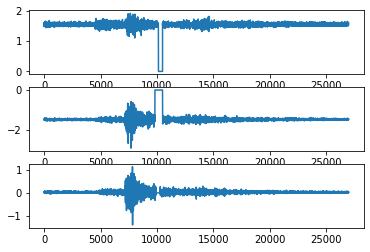

pgaZ:0.3691161427579649, pgaN:1.2261414663174381, pgaE: 0.8376974043713964
pgvZ:0.04546899531079451, pgvN:0.14794956404274845, pgvE: 0.09657984888907449
station: TWM1, distance: 245.7, intensity: 1, pga: 1.318781378574386, pgv: 0.15338414997888938,  waveType: Velocity
original intensity: 0
original pga: 0.3


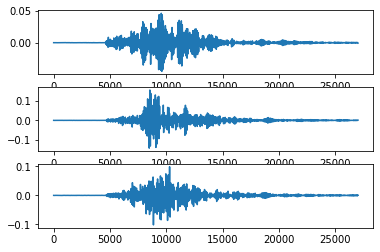

pgaZ:8.858451208614957, pgaN:3.4055602089306714, pgaE: 2.39951970143108
pgvZ:4.030647858504822, pgvN:1.5493787013503388, pgvE: 1.0507461399844589
station: TWM1, distance: 245.7, intensity: 3, pga: 9.767590733164667, pgv: 4.444183161184945,  waveType: Acceleration
original intensity: 0
original pga: 0.3


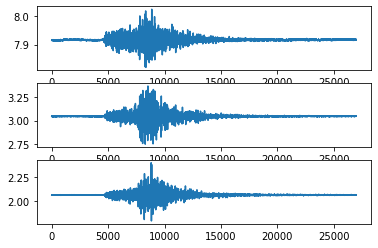

pgaZ:1.3888513928718684, pgaN:4.467999273142299, pgaE: 1.5236568931445404
pgvZ:0.5876875914507217, pgvN:2.031555732410911, pgvE: 0.6561096324441863
station: TAI, distance: 247.6, intensity: 2, pga: 4.871617026633818, pgv: 2.2142585484144717,  waveType: Acceleration
original intensity: 0
original pga: 0.4


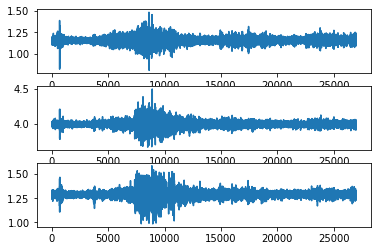

pgaZ:0.08645035881436257, pgaN:0.3647224075465378, pgaE: 0.3443141813944083
pgvZ:0.008540543973248216, pgvN:0.02405200506965726, pgvE: 0.026816450087754642
station: SGL, distance: 249.9, intensity: 0, pga: 0.3654766853248969, pgv: 0.03486108100000209,  waveType: Velocity
original intensity: 0
original pga: 0.4


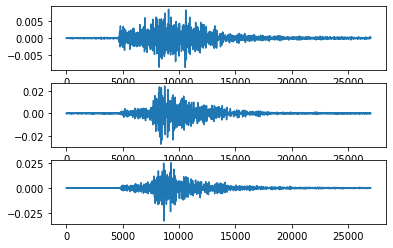

pgaZ:-0.011258431297543961, pgaN:1.2181865864639505, pgaE: 3.5940695980000834
pgvZ:1.1156679338124578, pgvN:0.4447570962748199, pgvE: 1.6348775974512146
station: SGL, distance: 249.9, intensity: 2, pga: 4.549278497777069, pgv: 2.0692116408815515,  waveType: Acceleration
original intensity: 0
original pga: 0.4


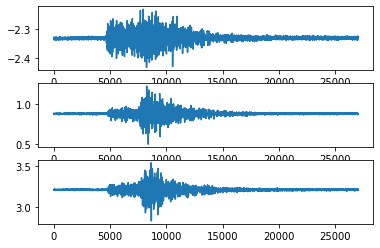

pgaZ:0.15324288979610984, pgaN:0.1490769210691873, pgaE: 0.23697423383724742
pgvZ:0.013562275371945251, pgvN:0.011763775860755086, pgvE: 0.013562654335261196
station: MASB, distance: 252.2, intensity: 0, pga: 0.24484601091893696, pgv: 0.01607485059921284,  waveType: Velocity


pgaZ:4.9006339673008625, pgaN:-0.005834365277942286, pgaE: 1.4830243575054438
pgvZ:2.2300913088827468, pgvN:0.5778003703504215, pgvE: 0.5853797592167119
station: SPT, distance: 254.3, intensity: 2, pga: 5.244055481996782, pgv: 2.3863850525584316,  waveType: Acceleration
original intensity: 0
original pga: 0.4


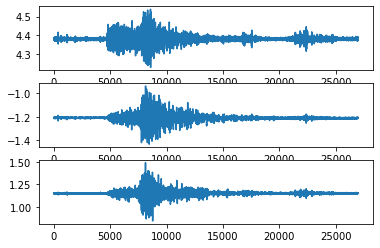

pgaZ:0.07417805322306183, pgaN:0.12468578380247988, pgaE: 0.13305177596774873
pgvZ:0.004813029962434993, pgvN:0.005364136338459771, pgvE: 0.005920090363965182
station: VWUC, distance: 261.0, intensity: 0, pga: 0.17911026745748357, pgv: 0.007585916940573739,  waveType: Velocity


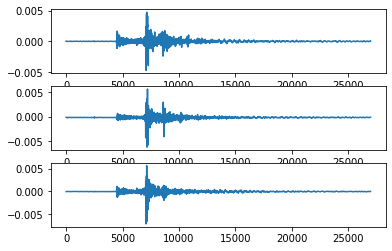

pgaZ:4.470035395973193, pgaN:3.0121411689183413, pgaE: 2.777442784250111
pgvZ:2.0330637409469605, pgvN:1.3592408742618722, pgvE: 1.1848787299963817
station: EAS, distance: 263.4, intensity: 2, pga: 5.974135092273298, pgv: 2.7175028121080698,  waveType: Acceleration
original intensity: 0
original pga: 0.5


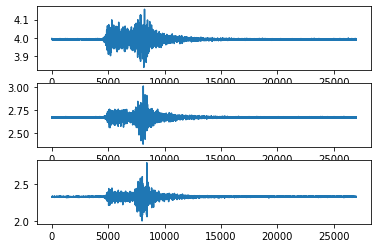

pgaZ:0.49855252602836914, pgaN:0.847270030009604, pgaE: 0.9779380854641567
pgvZ:0.054307707148672925, pgvN:0.11704245223173058, pgvE: 0.058998330715253795
station: EAS, distance: 263.4, intensity: 1, pga: 1.2818214447267484, pgv: 0.12235565493797756,  waveType: Velocity
original intensity: 0
original pga: 0.5


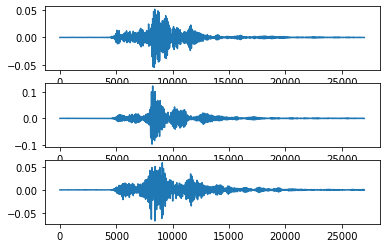

pgaZ:5.320113420614459, pgaN:-0.02141221074570936, pgaE: 0.28328144125284843
pgvZ:2.421221477419801, pgvN:2.1186319083067495, pgvE: 0.04290228081174389
station: TAW, distance: 264.0, intensity: 2, pga: 7.271786024902182, pgv: 3.3096873176269472,  waveType: Acceleration
original intensity: 0
original pga: 0.3


pgaZ:0.06385604329785491, pgaN:0.00010384705012482307, pgaE: 0.19525132253055524
pgvZ:0.004458802118186613, pgvN:1.0452934171727218e-05, pgvE: 0.01622013757883234
station: TAW, distance: 264.0, intensity: 0, pga: 0.19526847128926897, pgv: 0.017990261713344086,  waveType: Velocity
original intensity: 0
original pga: 0.3


pgaZ:0.09155243210965076, pgaN:0.09631951734286631, pgaE: 0.05653158547124801
pgvZ:0.005805696245461832, pgvN:0.007704442862008325, pgvE: 0.00515541377448024
station: TAWH, distance: 266.3, intensity: 0, pga: 0.09980550974767222, pgv: 0.012787183614384256,  waveType: Velocity
original intensity: 0
original pga: 0.5


pgaZ:1.8712875747235254, pgaN:-0.27971723546535615, pgaE: 59.83285421581237
pgvZ:0.8513836319407228, pgvN:27.721770465959054, pgvE: 27.22398367336747
station: TAWH, distance: 266.3, intensity: 5 strong, pga: 88.28143677053245, pgv: 40.16809217692174,  waveType: Acceleration
original intensity: 0
original pga: 0.5


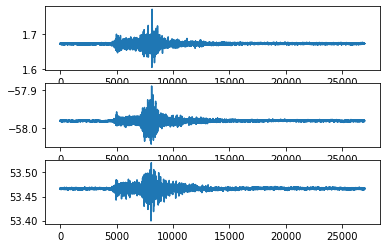

pgaZ:-0.012588522299856924, pgaN:-0.017426446521829158, pgaE: 5.119763979453758
pgvZ:1.2508421130354037, pgvN:1.7289560346382613, pgvE: 2.3287279445963853
station: TAWH, distance: 266.3, intensity: 2, pga: 7.147156370589595, pgv: 3.253727787823203,  waveType: Acceleration
original intensity: 0
original pga: 0.5


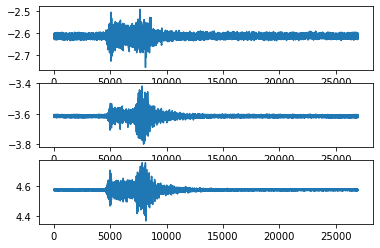

pgaZ:0.24370757998838072, pgaN:0.5040751188212048, pgaE: 0.3901387422138716
pgvZ:0.009111363495230613, pgvN:0.020215591073263286, pgvE: 0.014915465742087873
station: PNG, distance: 267.3, intensity: 0, pga: 0.5243463331976627, pgv: 0.025306528077217443,  waveType: Velocity
original intensity: 0
original pga: 0.6


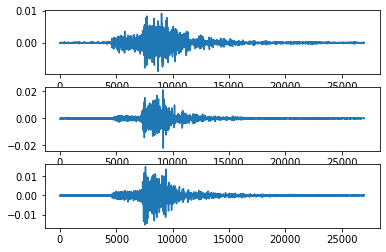

pgaZ:0.1946307656600128, pgaN:0.25657257474825806, pgaE: 0.2578173273176152
pgvZ:0.007015711427616846, pgvN:0.016533291031765304, pgvE: 0.010545688831482655
station: PNG, distance: 267.3, intensity: 0, pga: 0.37143325454027787, pgv: 0.016984041592237393,  waveType: Velocity
original intensity: 0
original pga: 0.6


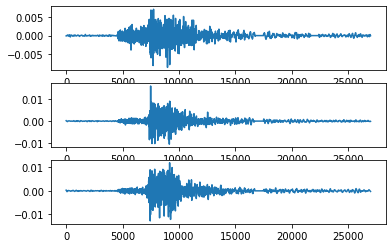

pgaZ:0.19535145004615814, pgaN:0.3046855307559035, pgaE: 0.25638741310420315
pgvZ:0.006825226264354385, pgvN:0.01879081345392967, pgvE: 0.010562423619352612
station: PNG, distance: 267.3, intensity: 0, pga: 0.3925135740259045, pgv: 0.01917104611796872,  waveType: Acceleration
original intensity: 0
original pga: 0.6


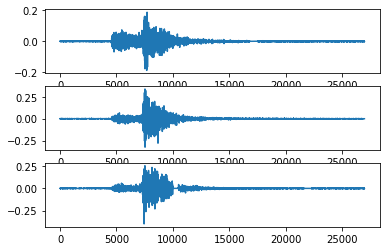

pgaZ:0.24237813607310005, pgaN:0.5426181048270284, pgaE: 0.4666658398115378
pgvZ:0.011065868881099745, pgvN:0.0358540775745829, pgvE: 0.023304174446806755
station: PNG, distance: 267.3, intensity: 0, pga: 0.5963058636833026, pgv: 0.036029112004457915,  waveType: Acceleration
original intensity: 0
original pga: 0.6


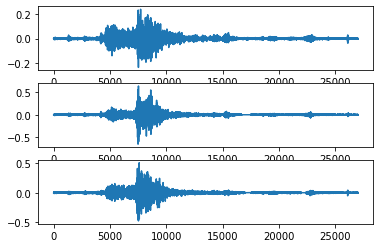

pgaZ:7.0484025209060635, pgaN:3.584903368242541, pgaE: 12.661700410586644
pgvZ:6.064253615863101, pgvN:2.229679225013694, pgvE: 11.110526086196456
station: SSP, distance: 267.8, intensity: 3, pga: 14.863059063614278, pgv: 12.845744698519848,  waveType: Acceleration
original intensity: 0
original pga: 0.6
original pgv: 0.1


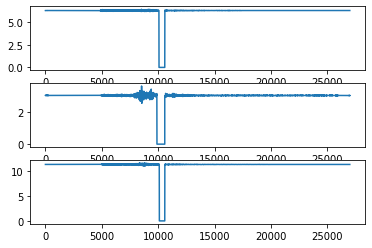

pgaZ:0.1900306532953219, pgaN:0.2925497741304617, pgaE: 0.3868902086756146
pgvZ:0.0076816837292992745, pgvN:0.017745286556885703, pgvE: 0.018961167509802472
station: PHUB, distance: 268.9, intensity: 0, pga: 0.47165008525574065, pgv: 0.02187893708940683,  waveType: Velocity


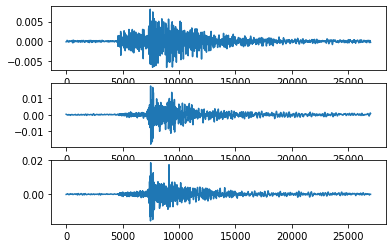

pgaZ:-0.043134598691641525, pgaN:-0.04035816496755905, pgaE: -0.022064906241452405
pgvZ:4.276139103820573, pgvN:4.00108364591668, pgvE: 2.1875948409749006
station: WSS, distance: 272.0, intensity: 3, pga: 14.632472688571358, pgv: 6.657408475340839,  waveType: Acceleration


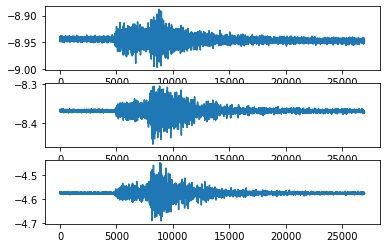

pgaZ:0.06063297853969968, pgaN:0.10801071147960194, pgaE: 0.15508859611308115
pgvZ:0.005194428227787936, pgvN:0.00415029800314362, pgvE: 0.004503801498178059
station: MATB, distance: 273.1, intensity: 0, pga: 0.15890465498210576, pgv: 0.0058135536498450735,  waveType: Velocity


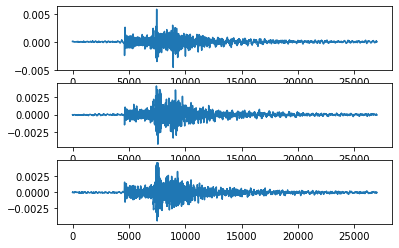

pgaZ:0.7706090834568498, pgaN:-0.017548183664413734, pgaE: 1.174165728617945
pgvZ:0.3491051289047925, pgvN:1.7397303464553842, pgvE: 0.5345562306470899
station: WDG, distance: 273.6, intensity: 2, pga: 4.3068817570699, pgv: 1.9593231121632573,  waveType: Acceleration
original intensity: 0
original pga: 0.2


pgaZ:0.6975058811593298, pgaN:1.0384651177294126, pgaE: 0.8801053563319061
pgvZ:0.05141428628004079, pgvN:0.05330472717304167, pgvE: 0.06655290013248273
station: WDG, distance: 273.6, intensity: 1, pga: 1.2364523320408494, pgv: 0.08125964318799005,  waveType: Velocity
original intensity: 0
original pga: 0.2


pgaZ:0.08894654804947884, pgaN:0.1578562646564718, pgaE: 0.1788103191178916
pgvZ:0.0069656383936355214, pgvN:0.00881031340163315, pgvE: 0.014110917279087042
station: SCZ, distance: 275.4, intensity: 0, pga: 0.21589956693913992, pgv: 0.01742789512620028,  waveType: Velocity
original intensity: 0
original pga: 0.3


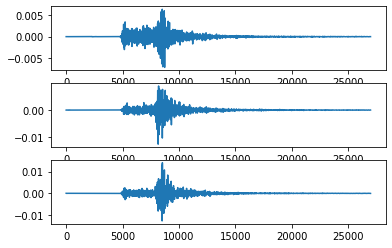

pgaZ:3.336867692151929, pgaN:9.044079194333232, pgaE: -0.0013962198205070538
pgvZ:1.5180447220560371, pgvN:4.115124831162556, pgvE: 0.13840277011804913
station: SCZ, distance: 275.4, intensity: 3, pga: 9.645444995869166, pgv: 4.388672031506974,  waveType: Acceleration
original intensity: 0
original pga: 0.3


pgaZ:0.09132639031143185, pgaN:0.1498856869650474, pgaE: 0.1919275821362946
pgvZ:0.010603685176245731, pgvN:0.011498662526900412, pgvE: 0.015647957926500276
station: SCZ, distance: 275.4, intensity: 0, pga: 0.24845840125643737, pgv: 0.01872446307496256,  waveType: Velocity
original intensity: 0
original pga: 0.3


pgaZ:7.145444585589362, pgaN:-0.00228473664906404, pgaE: 1.380477598956572
pgvZ:3.2512033267044664, pgvN:0.2263940592452084, pgvE: 0.6047083476477016
station: SCZ, distance: 275.4, intensity: 2, pga: 7.2873259284643, pgv: 3.3157377972274857,  waveType: Acceleration
original intensity: 0
original pga: 0.3


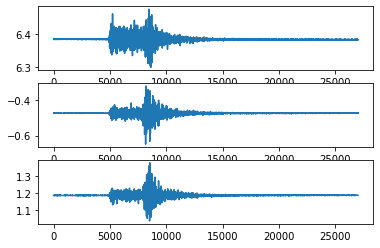

pgaZ:-0.018045652728555645, pgaN:-0.018179413292630054, pgaE: 0.3863659309790942
pgvZ:1.7931145825903356, pgvN:1.8032123585352755, pgvE: 0.022404231514490027
station: MSU, distance: 275.7, intensity: 2, pga: 5.94797402842733, pgv: 2.7079379210716534,  waveType: Acceleration
original intensity: 0
original pga: 0.4


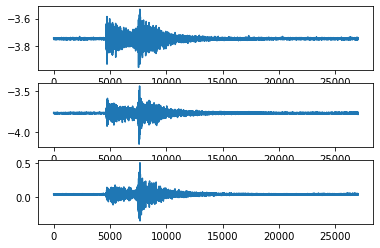

pgaZ:6.372092040164957, pgaN:-0.021917194448282416, pgaE: 3.680201842297338
pgvZ:2.8993383714183745, pgvN:2.1789260485798696, pgvE: 0.9358802014873163
station: LAY, distance: 279.0, intensity: 3, pga: 8.940677283658214, pgv: 3.8299764648499464,  waveType: Acceleration
original intensity: 1
original pga: 2.0
original pgv: 0.1


pgaZ:0.41511576461471816, pgaN:1.804445682042417, pgaE: 0.0006054393693812232
pgvZ:0.01415548048987113, pgvN:0.07196153032405009, pgvE: 2.4165686317716807e-05
station: LAY, distance: 279.0, intensity: 1, pga: 1.808458598549374, pgv: 0.07197859725452856,  waveType: Velocity
original intensity: 1
original pga: 2.0
original pgv: 0.1


pgaZ:0.05328257886383426, pgaN:0.07374549032322615, pgaE: 0.03545494294579852
pgvZ:0.004537129230620246, pgvN:0.00562602878379452, pgvE: 0.006134428039246093
station: LAY, distance: 279.0, intensity: 0, pga: 0.08024910964737436, pgv: 0.006138729558255435,  waveType: Velocity
original intensity: 1
original pga: 2.0
original pgv: 0.1


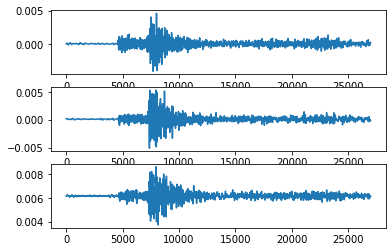

pgaZ:-0.0741973935187825, pgaN:27.49300986249765, pgaE: -0.03036229052291386
pgvZ:7.341185865648194, pgvN:12.509737013122177, pgvE: 3.0093506071859846
station: LAY, distance: 279.0, intensity: 4, pga: 33.19124618140045, pgv: 15.10133333248741,  waveType: Acceleration
original intensity: 1
original pga: 2.0
original pgv: 0.1


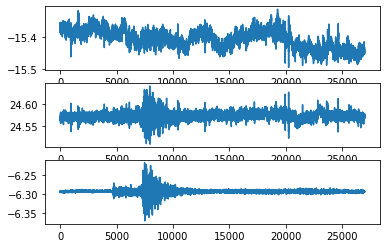

pgaZ:0.03275530600246749, pgaN:0.06364636021609907, pgaE: 0.046876814515073875
pgvZ:0.003542732165174038, pgvN:0.004158588935631894, pgvE: 0.004441010365900027
station: SLIU, distance: 282.5, intensity: 0, pga: 0.07115614679341924, pgv: 0.005650914305542338,  waveType: Velocity
original intensity: 0
original pga: 0.1


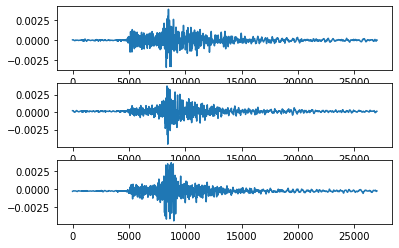

pgaZ:1.6584610269994582, pgaN:-0.002107119764531673, pgaE: 0.3376578907977101
pgvZ:0.754511865666491, pgvN:0.20880456326893587, pgvE: 0.1479614380368642
station: SLIU, distance: 282.5, intensity: 1, pga: 1.7592973546772552, pgv: 0.8004236977581805,  waveType: Acceleration
original intensity: 0
original pga: 0.1


pgaZ:-0.008733512784678675, pgaN:-0.03834118820339661, pgaE: 1.8546950769251997
pgvZ:0.8651320374160556, pgvN:3.8000066340480565, pgvE: 0.8439211159950861
station: SLIU, distance: 282.5, intensity: 3, pga: 9.308080798284747, pgv: 4.235316263059964,  waveType: Acceleration
original intensity: 0
original pga: 0.1


pgaZ:0.3105155576326382, pgaN:0.5463473498546779, pgaE: 0.47108865386602805
pgvZ:0.019051497278805268, pgvN:0.028812496498775056, pgvE: 0.029654872566464093
station: LYUB, distance: 282.5, intensity: 0, pga: 0.5876477237886838, pgv: 0.031608311611623516,  waveType: Velocity


pgaZ:0.6073372622208666, pgaN:0.2395167475373994, pgaE: 0.9740035913180665
pgvZ:3.4863288858647135, pgvN:1.0028979835308651, pgvE: 4.198668594660744
station: WLCH, distance: 290.7, intensity: 3, pga: 11.062481217234122, pgv: 8.771855748138403,  waveType: Acceleration


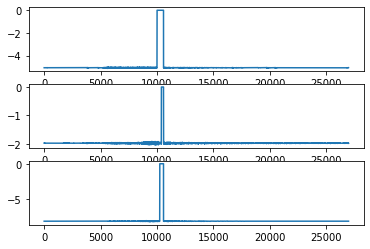

pgaZ:0.0441099189559114, pgaN:0.0836628677062191, pgaE: 0.06862222430387468
pgvZ:0.0035802328938360794, pgvN:0.004929732572899449, pgvE: 0.006083873494189747
station: WLC, distance: 291.6, intensity: 0, pga: 0.09548516021424049, pgv: 0.007386038346612015,  waveType: Velocity


pgaZ:-0.03280891139038642, pgaN:-0.015411020494595617, pgaE: -0.03913924280478438
pgvZ:3.2517829793796285, pgvN:1.5292724139381968, pgvE: 3.879078831788794
station: WLC, distance: 291.6, intensity: 3, pga: 12.376160223675889, pgv: 5.630957454326648,  waveType: Acceleration


pgaZ:0.09768053179918758, pgaN:0.19499878844361598, pgaE: 0.1641670533336926
pgvZ:0.005818038462004292, pgvN:0.008357803095089735, pgvE: 0.007666781760882382
station: PTMZ, distance: 294.7, intensity: 0, pga: 0.24706461840214394, pgv: 0.009873973491839126,  waveType: Velocity


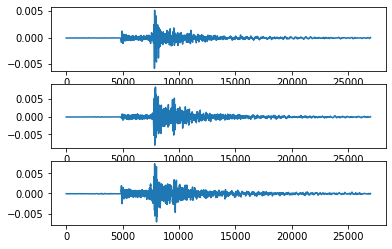

pgaZ:0.045126378523431494, pgaN:0.05229946001147457, pgaE: 0.05127414195884683
pgvZ:0.004144430906758402, pgvN:0.006453534594541801, pgvE: 0.007969114608314298
station: VCHM, distance: 297.4, intensity: 0, pga: 0.07513706743137448, pgv: 0.009208664546001733,  waveType: Velocity


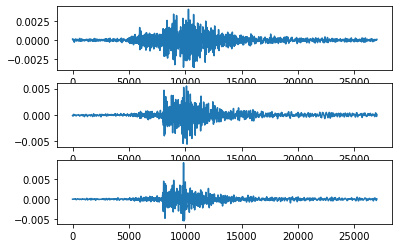

pgaZ:0.048924848818002735, pgaN:0.000424797176187659, pgaE: 6.820678765241671e-05
pgvZ:0.002005619383262046, pgvN:2.4170317087430027e-05, pgvE: 2.7453346353734917e-06
station: SMS, distance: 300.8, intensity: 0, pga: 0.04892673642917256, pgv: 0.0020057685120702766,  waveType: Velocity
original intensity: 0
original pga: 0.8


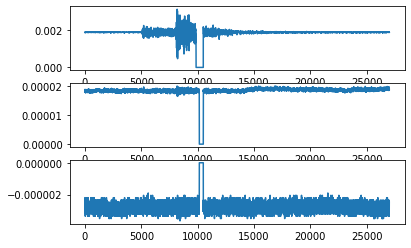

pgaZ:4.854888845210539, pgaN:3.7895355123641665, pgaE: 4.275550901798149
pgvZ:4.022123867620554, pgvN:3.286573762845503, pgvE: 3.715601369409963
station: SMS, distance: 300.8, intensity: 2, pga: 7.494832782724759, pgv: 6.349213596421123,  waveType: Acceleration
original intensity: 0
original pga: 0.8


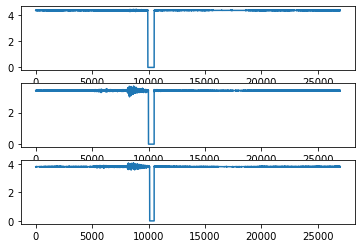

pgaZ:8.150275983130534, pgaN:4.57821273937087, pgaE: 0.23791056917689185
pgvZ:3.7077618203397735, pgvN:2.083271619022059, pgvE: 0.012082390293787113
station: SMS, distance: 300.8, intensity: 3, pga: 9.348109034430497, pgv: 4.252933754492942,  waveType: Acceleration
original intensity: 0
original pga: 0.8


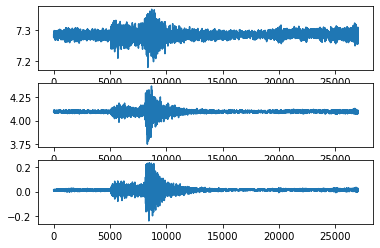

pgaZ:2.855080694840282, pgaN:-0.013927630868287263, pgaE: -0.01649763721173943
pgvZ:1.2992919085021628, pgvN:1.3796267508597335, pgvE: 1.6352998357729591
station: HEN, distance: 306.2, intensity: 2, pga: 5.7656098935613, pgv: 2.6228395636741566,  waveType: Acceleration
original intensity: 0
original pga: 0.4


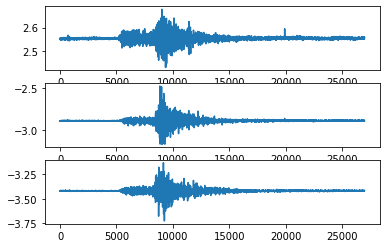

pgaZ:0.043313363258696905, pgaN:0.16786069129837666, pgaE: 0.11691997462632815
pgvZ:0.004964991354552062, pgvN:0.012105470041484458, pgvE: 0.012224212967072615
station: HEN, distance: 306.2, intensity: 0, pga: 0.17390790164702963, pgv: 0.012575236714810664,  waveType: Velocity
original intensity: 0
original pga: 0.4


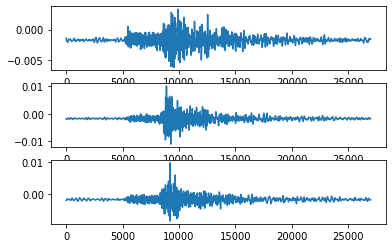

pgaZ:0.062042148890856, pgaN:0.07754729009908586, pgaE: 0.12708988125742163
pgvZ:0.0044674534431650365, pgvN:0.00837417005329871, pgvE: 0.009244476429998686
station: TWKB, distance: 309.9, intensity: 0, pga: 0.1357362362828119, pgv: 0.01147851790769077,  waveType: Velocity


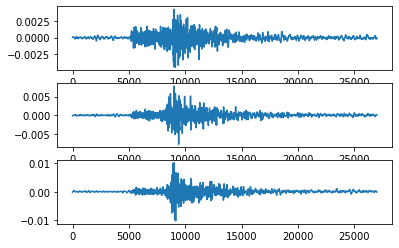

pgaZ:-0.038109737339717294, pgaN:-0.027655372354306023, pgaE: 2.181694066207709
pgvZ:3.778179679068189, pgvN:2.740465189013788, pgvE: 0.9926956023562771
station: TWK1, distance: 309.9, intensity: 3, pga: 11.139923245095886, pgv: 5.068830980753561,  waveType: Acceleration


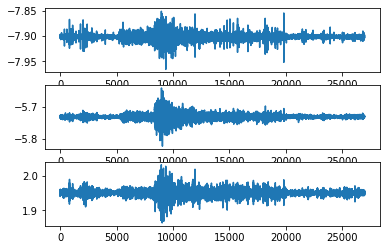

pgaZ:0.0536552589579845, pgaN:0.20429913902722863, pgaE: 0.07726448712300578
pgvZ:0.003509780348746801, pgvN:0.03127618168630811, pgvE: 0.006856374316161975
station: TWK1, distance: 309.9, intensity: 0, pga: 0.23778647450340298, pgv: 0.032133759105402525,  waveType: Velocity


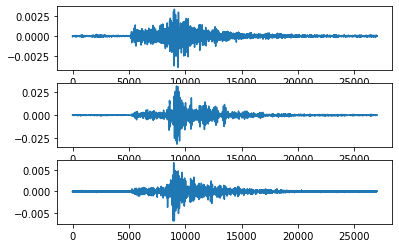

pgaZ:2.413106311587849, pgaN:-0.012883096126357874, pgaE: 3.1512479136857414
pgvZ:1.0907414860860531, pgvN:1.288528705300806, pgvE: 1.4325602036870206
station: SNW, distance: 310.5, intensity: 2, pga: 4.9834554597912435, pgv: 2.2634953143929235,  waveType: Acceleration
original intensity: 0
original pga: 0.5


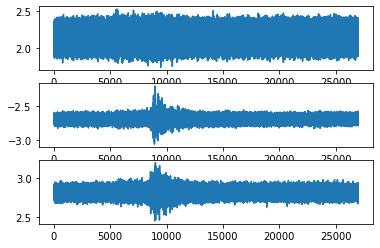

pgaZ:0.13220219080936826, pgaN:0.2220900828855406, pgaE: 0.26879822771746037
pgvZ:0.00698380713629249, pgvN:0.011272348009961783, pgvE: 0.01630563617002318
station: SEB, distance: 312.4, intensity: 0, pga: 0.27024409170918234, pgv: 0.01798804184883516,  waveType: Velocity
original intensity: 0
original pga: 0.3


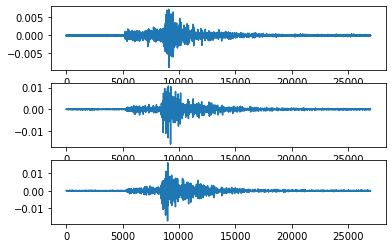

pgaZ:7.254190548853435, pgaN:5.530715351515029, pgaE: 2.296542465612902
pgvZ:3.300544052797288, pgvN:2.517211085074698, pgvE: 1.0444436944457653
station: SEB, distance: 312.4, intensity: 3, pga: 9.406710376902327, pgv: 4.280280986354284,  waveType: Acceleration
original intensity: 0
original pga: 0.3


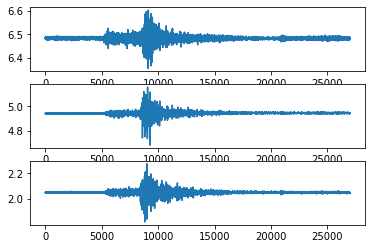

pgaZ:0.05101668998356127, pgaN:0.09005743508267743, pgaE: 0.05918413847784385
pgvZ:0.00416554361171082, pgvN:0.004211917158294366, pgvE: 0.003972656038495753
station: LYJJ, distance: 316.4, intensity: 0, pga: 0.11322062545107306, pgv: 0.007877760739576443,  waveType: Velocity


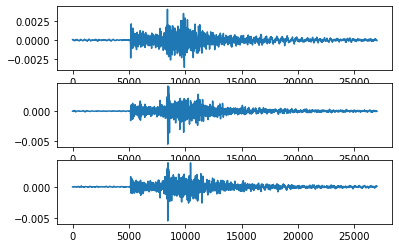

pgaZ:0.04140747834042411, pgaN:0.11142047868498867, pgaE: 0.03166794398879264
pgvZ:0.0037310227151158234, pgvN:0.0074165421778734225, pgvE: 0.001301225268959017
station: XPSS, distance: 321.3, intensity: 0, pga: 0.12524715146805324, pgv: 0.008319235687065392,  waveType: Velocity


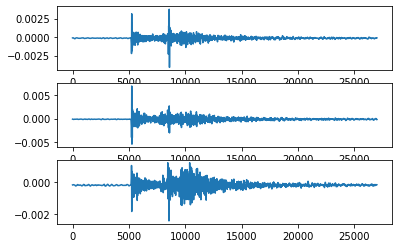

pgaZ:0.0143664480371332, pgaN:0.02113309103033865, pgaE: 0.019245437412671127
pgvZ:0.0007611032636328193, pgvN:0.001494187959536229, pgvE: 0.00217024572998618
station: JMJ, distance: 337.4, intensity: 0, pga: 0.024142861694537294, pgv: 0.0023589615951764894,  waveType: Velocity


pgaZ:0.04848989964639516, pgaN:0.06531637987753582, pgaE: 0.02924987068985517
pgvZ:0.0031889998501970856, pgvN:0.00362088496510284, pgvE: 0.30295295206884776
station: MHZQ, distance: 344.7, intensity: 0, pga: 0.07009244871395251, pgv: 0.8575650330685798,  waveType: Velocity


pgaZ:0.06892534708792285, pgaN:0.08524688074425033, pgaE: 0.09923065341010899
pgvZ:0.003952783161509869, pgvN:0.004232841419767484, pgvE: 0.003258368968569021
station: KMNB, distance: 364.0, intensity: 0, pga: 0.10300978325494355, pgv: 0.005633001983752387,  waveType: Velocity


pgaZ:3.085279476560007, pgaN:-0.018382308530271018, pgaE: 5.82906820547477
pgvZ:1.4034624210107245, pgvN:1.8216599854643305, pgvE: 2.6521422457365227
station: KNM, distance: 374.3, intensity: 2, pga: 7.8539825882113865, pgv: 3.573393136146771,  waveType: Acceleration


pgaZ:0.050591903030974446, pgaN:0.07292174044905818, pgaE: 0.09108598169677992
pgvZ:0.0023180565217864302, pgvN:0.0034372727306103495, pgvE: 0.0029998106091503676
station: KNM, distance: 374.3, intensity: 0, pga: 0.09744253083717547, pgv: 0.003840490836089933,  waveType: Velocity


pgaZ:0.08873539895687425, pgaN:0.09421223297966581, pgaE: 0.05221775950165881
pgvZ:0.005370095290144872, pgvN:0.0041249477989483835, pgvE: 0.0033765743896449745
station: AXDP, distance: 408.0, intensity: 0, pga: 0.12560730009925553, pgv: 0.005514548932022879,  waveType: Velocity


pgaZ:0.03632299201032943, pgaN:0.05595848904417386, pgaE: 0.0718622598409452
pgvZ:0.0025183826390234674, pgvN:0.003747054720374301, pgvE: 0.0030747983339736813
station: ZPLA, distance: 434.6, intensity: 0, pga: 0.08544101184804329, pgv: 0.005523754684902515,  waveType: Velocity


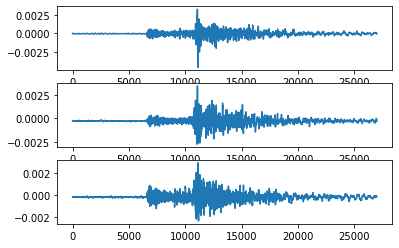

pgaZ:0.07038068863451294, pgaN:0.06288029191246643, pgaE: 0.07275602415006524
pgvZ:0.0025415049444615094, pgvN:0.0025528903736719974, pgvE: 0.003009788101004087
station: DSXP, distance: 471.6, intensity: 0, pga: 0.08957963023407102, pgv: 0.00504428520848246,  waveType: Velocity


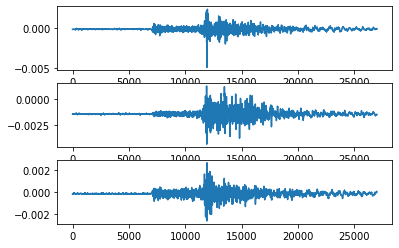

pgaZ:0.027318868662562525, pgaN:0.01858756008848831, pgaE: 0.01913057861794842
pgvZ:0.002772406352869766, pgvN:0.001898813498175613, pgvE: 0.0017205332120705566
station: SXFK, distance: 483.5, intensity: 0, pga: 0.031211702415312334, pgv: 0.0032769130608076716,  waveType: Velocity


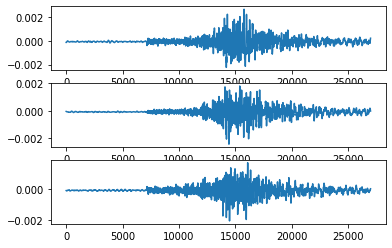

pgaZ:0.007787644691610066, pgaN:0.003892041490326963, pgaE: 0.005965905926513009
pgvZ:0.0003563957171591283, pgvN:0.00023480728421004663, pgvE: 0.0002683744489964139
station: JOW, distance: 682.0, intensity: 0, pga: 0.010008451149375673, pgv: 0.00045468278231572905,  waveType: Velocity


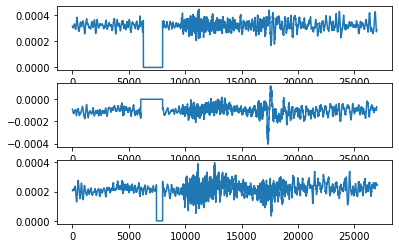

pgaZ:0.002942468243230961, pgaN:0.007862875395245411, pgaE: 0.009407454689972505
pgvZ:0.0003232876456939117, pgvN:0.0006194801420690304, pgvE: 0.0009156371658217412
station: VDOS, distance: 685.3, intensity: 0, pga: 0.010232491771084658, pgv: 0.0009503445378518294,  waveType: Velocity


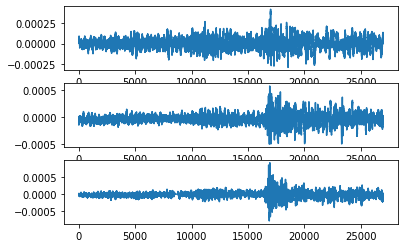

pgaZ:0.0023365390139104864, pgaN:0.002712750631905378, pgaE: 0.0019578151489149423
pgvZ:0.03903107994008483, pgvN:0.04806178240696852, pgvE: 0.02771492512066722
station: HKPS, distance: 839.1, intensity: 0, pga: 0.0027716483834676633, pgv: 0.19272486234222486,  waveType: Velocity


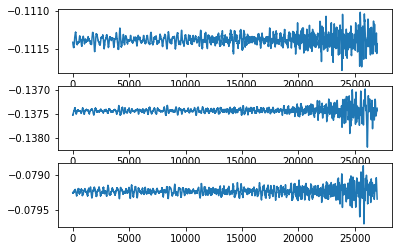

KeyboardInterrupt: 

In [183]:
# 每個檔案都去修改
for file in tqdm(files):
    f = open(os.path.join(root, file), 'r')
    p = json.load(f)
    
    if float(p['mag']) > 5:
        print(p['mag'], p['ori_time'], p['lat'], p['lon'])
        modify(p)
    
    p = modify(p)
    
    with open(os.path.join(root, file), 'w') as f:
        json.dump(p, f)

In [1]:
%run read_c.ipynb

In [34]:
afile = '/mnt/nas6/new_CWB_data/CWB_data/2020/felt/12/24101815.A20'
a = unpackAfile(afile)

EHP Ch1 SMT 01 0.00031153 	pga:  15.22634028


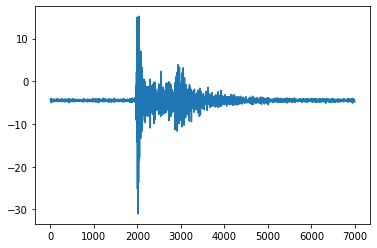

EHP Ch2 SMT 01 0.00031153 	pga:  17.18243715


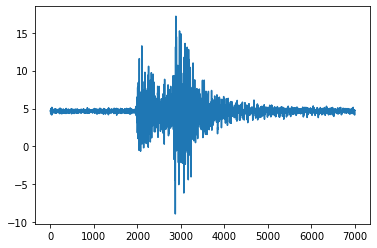

EHP Ch3 SMT 01 0.00031153 	pga:  12.69671668


In [48]:
# issue: EHP, ENA
for i in range(len(a)):
    if a[i].stats.station == 'EHP':
            _, factor, _ = get_factor(a[i])
            d = np.array(a[i].data[:7000])
            print(a[i].stats.station, a[i].stats.channel, a[i].stats.network, a[i].stats.location, factor, '\tpga: ', max(d*factor))
        
            #plt.figure(figsize=(50, 10), dpi=300)
            plt.plot(d*factor)
            plt.show()
            
            
# waveform 訊號異常狀況
# 